<a href="https://colab.research.google.com/github/Pietrosittoni/NoVax_Speech_on_Twitter/blob/main/Vaxcamp_Filtering_and_working_on_italian_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.0 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9076 sha256=9657a8327c8229c729c2cd9437247dfb049f29bfb452d8044a068a3db5723697
  Stored in directory: /root/.cache/pip/wheels/04/eb/68/b70fc5f1163b5a3e9e6aaaea5fb57a8ff4c0c4988505a4fe0f
Successfully built python-igraph


In [ ]:
!pip install --upgrade scipy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 29.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import requests 
import pandas as pd 
import time
import itertools
import igraph as ig
import networkx as nx
import networkx.algorithms.community as nx_comm

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=c4e53ff82af6ddb715ec6e19af697d218ad9953da6ad79e59276abe3db7255f8
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


If you want to load the results you have previously saved, simply execute the next code, specifying the path to the file.

You will need to either upload it to the Colab workspace or copy the path to the file on Drive.

# *Load data*


In [ ]:
path = "/content/drive/MyDrive/Network_Science_covid_project/Nuovi_tweets/df_tweets_vaxcamp.pkl"
tweets_df = pd.read_pickle(path)


# *Filtering Twitter data*

## Step 1: Preprocessing the data

In [ ]:
tweets_df = tweets_df[tweets_df['lang']=="it"]

In [ ]:
tweets_df.shape

(27175, 14)

In [ ]:
tweets_filtered = tweets_df.copy() 
column_list = ["id","author_id","created_at", "text","entities","public_metrics", "lang"]
unique_hashtags_postgp = tweets_filtered[column_list]

## Step 2: Extracting hashtags

In [ ]:
tweets_filtered.loc[tweets_filtered["entities"].isnull(), "entities"] = None

In [ ]:
tweets_filtered["hashtags"] = ""

In [ ]:
unique_hashtags = {}
index = 0
for idx, row in tweets_filtered.iterrows():
  if row["entities"] is not None and "hashtags" in row["entities"]:
    hl = []
    for hashtag in row["entities"]["hashtags"]:
      tag = "#"+hashtag["tag"]
      if  tag not in ["#nogreenpassobbligatorio","#NoVaccinoObbligatorio","#DittaturaSanitaria", "#novaccinoCOVID","#nocavie","#primule","#ProVaccino"]:    
        if tag=="#nogreenpassobbligatorio":
          print("problem")
        tag = tag.lower()
        unique_hashtags.setdefault(tag, 0)
        unique_hashtags[tag] += 1
        hl.append(tag)
        tweets_filtered.at[idx,"hashtags"] = [hl]

In [ ]:
i = 0
for idx, row in tweets_filtered.iterrows():
  if len(row["hashtags"])==1 and (type(row["hashtags"][0]) is list):
    tweets_filtered.loc[idx,"hashtags"] = row["hashtags"][0]
    if i==1:
      print("problem")
i = 1

In [ ]:
unique_hashtags = dict(sorted(unique_hashtags.items(), key=lambda item: item[1], reverse=True))

In [ ]:
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df.to_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/freq_hashtag_vaxcamp.csv")

In [ ]:
uh_df[0:5]

,Hashtag,Count
0,#dittaturasanitaria,3383
1,#arcuri,1603
2,#draghi,1419
3,#covid19,1401
4,#dpcm,1196


## Step3 : Extracting Words

In [ ]:
import re
import string
# NLTK tools
import nltk
nltk.download('words')
#words = set(nltk.corpus.words.words())
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("italian")
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
stop_words.append('rt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
pp=pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/60000_parole_italiane.txt',header=None)
words=[str(pp[0][i]) for i in range(len(pp))]

In [ ]:
'''def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub("_[A-Za-z0-9]+", "",tweet)
    tweet = str.lower(tweet) #to lowercase
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w in words and not w in stop_words)
     #remove stop words
    lemma_function = WordNetLemmatizer()
    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize
    tweet = [i for i in tweet.split(' ') if len(i)>2]
    tweet = " ".join(tweet)
    return tweet'''

'def cleaner(tweet):\n    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions\n    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags\n    tweet = re.sub("_[A-Za-z0-9]+", "",tweet)\n    tweet = str.lower(tweet) #to lowercase\n    tweet = re.sub(r"(?:\\@|http?\\://|https?\\://|www)\\S+", "", tweet) # remove http links\n    tweet = " ".join(tweet.split())\n    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w in words and not w in stop_words)\n     #remove stop words\n    lemma_function = WordNetLemmatizer()\n    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize\n    tweet = [i for i in tweet.split(\' \') if len(i)>2]\n    tweet = " ".join(tweet)\n    return tweet'

In [ ]:
from nltk.stem.snowball import SnowballStemmer


def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub("_[A-Za-z0-9]+", "",tweet)
    tweet = str.lower(tweet) #to lowercase
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w in words and not w in stop_words)
     #remove stop words
    snow_stemmer = SnowballStemmer(language='italian')
    tweet = " ".join(snow_stemmer.stem(w) for w in nltk.wordpunct_tokenize(tweet)) #lemmatize
    tweet = [i for i in tweet.split(' ') if len(i)>2]
    tweet = " ".join(tweet)
    return tweet

In [ ]:
def clean_2(tweet):
  first = ['tropp', 'poc', 'pront', 'vers', 'ari', 'nemmen', 'introdu', 'conosc', 'fall', 'becc', 'avvi', 'conseguent', 'ennesim', 'ammess', 'agenz', 'conten', 'mister', 'rivel', 'conteng', 'sufficient', 'vapor', 'dovrebber', 'contest', 'larg', 'atti', 'esecutor', 'eco', 'glorios', 'rinnov', 'polizz', 'furgon', 'aere', 'vettur', 'scred', 'dia', 'distes', 'bac', 'rimprover', 'verific', 'inaccett', 'scrittur', 'amant', 'stizz', 'osass', 'vizios', 'tecnolog', 'cristian', 'notturn', 'vorrann', 'fantasm', 'cavall', 'candel', 'provin', 'guardin', 'legger', 'massai', 'capolavor', 'apost', 'assenz', 'andarven', 'farcel', 'cavial', 'ottus', 'direzion', 'disappunt', 'ribell', 'alzan', 'dirm', 'fus', 'silur', 'palett', 'esigt', 'concentr', 'inert', 'sboccin', 'polig' , 'scelt', 'mand', 'giall', 'almen', 'gioc', 'test', 'tip', 'priv', 'inform', 'schif', 'piac', 'decess', 'list', 'atto', 'manc', 'esatt', 'regol', 'butt', 'sperimental', 'soprattutt', 'pro', 'mass', 'azion', 'malatt', 'complic', 'risc', 'error', 'prenot', 'que', 'fest', 'pezz', 'potrebb', 'cervell', 'propagand', 'sann', 'var', 'ore', 'pall', 'ferm', 'donn', 'spess', 'doman', 'nazional', 'riman', 'permett', 'evit', 'dur', 'complet', 'crimin', 'scriv', 'consens', 'ricatt', 'contrar', 'termin', 'dittator', 'ignor', 'davant', 'vann', 'tent', 'efficac', 'centinai', 'piscin', 'probabil', 'rif', 'stran', 'gestion', 'tocc', 'specif', 'uso', 'assol', 'decid', 'import', 'vad', 'tal', 'purtropp', 'vot', 'confin', 'tram', 'viet', 'usa', 'insiem', 'premess', 'cerc', 'pseud', 'super', 'giur', 'simbol', 'rom', 'coragg', 'dietr', 'dit', 'esemp', 'lett', 'concord', 'bastard', 'tolt', 'disastr', 'bel', 'terribil', 'buffon', 'applic', 'tagl', 'norm', 'comment', 'val', 'onest', 'scopp', 'pensier', 'natural', 'dire', 'spaz', 'gest', 'facil', 'beh', 'infatt', 'cominc', 'cors', 'progett', 'grav', 'global', 'distrutt', 'peggior', 'rovin', 'necessar', 'grad', 'ricover', 'staser', 'ridicol', 'soprus', 'enorm', 'minim', 'vuot', 'tranquill', 'consider', 'circol', 'ced', 'messagg', 'divers', 'nemic', 'autorizz', 'real', 'circ', 'condann', 'pecor', 'padiglion', 'blocc', 'accad', 'aiut', 'schi', 'impres', 'programm', 'dovrest', 'process', 'famigl', 'costos', 'segn', 'der', 'tre', 'cris', 'titol', 'lament', 'ester', 'ottobr', 'precis', 'padr', 'spiet', 'fatem', 'favor', 'line', 'indic', 'violenz', 'costrett', 'impegn', 'resistt', 'sogn', 'scop', 'bott', 'bocc', 'consegut', 'calc', 'miser', 'colleg', 'potrebber', 'adegu', 'util', 'bugiard', 'inter', 'viagg', 'qual', 'posizion', 'immed', 'spiagg', 'pazient', 'decision', 'merit', 'stim', 'fisic', 'romp', 'scegl', 'nonost', 'lim', 'augur', 'sier', 'elimin', 'giugn', 'abus', 'uomin', 'compr', 'espert', 'reazion', 'settor', 'sprec', 'ammett', 'period', 'difficil', 'stell', 'sospett', 'palazz', 'cal', 'brev', 'ulterior', 'elezion', 'licenz', 'domen', 'soluzion', 'sai', 'libr', 'pazz', 'nazion', 'compleann', 'manten', 'moral', 'raccont', 'epidem', 'smett', 'storic', 'odi', 'piuttost', 'nat', 'abbass', 'richiest', 'pied', 'emorrag', 'alta', 'piu', 'indag', 'organizz', 'mov', 'garant', 'oppur', 'rifer', 'compres', 'permess', 'chies', 'sfid', 'infam', 'modell', 'provoc', 'elettor', 'simil', 'avven', 'affar', 'consum', 'ottien', 'mancanz', 'fiduc', 'giustiz', 'vacanz', 'resist', 'preved', 'anticip', 'estern', 'ton', 'addi', 'question', 'batt', 'esce', 'spost', 'obbed', 'amor', 'rid', 'aliment', 'benven', 'accus', 'pecc', 'tortur', 'sapp', 'best', 'contatt', 'content', 'verd', 'spreg', 'spunt', 'tragic', 'band', 'dirl', 'grafic', 'corrott', 'nott', 'nord', 'spec', 'differt', 'pagh', 'gua', 'bass', 'estratt', 'debb', 'fang', 'mill', 'diss', 'gross', 'caric', 'fastid', 'gravid', 'ricev', 'rinchius', 'cultural', 'grupp', 'diffond', 'realizz', 'ridott', 'cancell', 'propost', 'combin', 'guid', 'scopert', 'funzional', 'delir', 'acqua', 'cor', 'perc', 'otten', 'frattemp', 'ignobil', 'fam', 'istru', 'sangu', 'territor', 'dunqu', 'analizz', 'imput', 'veloc', 'div', 'bug', 'pen', 'scopr', 'mascher', 'stuf', 'pression', 'soggett', 'infett', 'ret', 'pagin', 'perfett', 'corr', 'entramb', 'stil', 'sosten', 'sintom', 'attend', 'verrann', 'risors', 'singol', 'turism', 'dannos', 'invasion', 'capac', 'decin', 'sfrutt', 'consent', 'indagin', 'pessim', 'sbatt', 'lav', 'talment', 'patrimon', 'tecnic', 'tem', 'natal', 'ognun', 'attorn', 'riport', 'rar', 'nasc', 'invoc', 'raccom', 'diffusion', 'salt', 'commess', 'entra', 'ginocc', 'russ', 'condizion', 'ber', 'malgrad', 'padron', 'inquiet', 'dispon', 'laborator', 'aut', 'muoi', 'contemporane', 'valg', 'ammal', 'relat', 'proclam', 'sput', 'imparzial', 'tend', 'negoz', 'imposs', 'strateg', 'sostegn', 'anim', 'guadagn', 'risolv', 'gamb', 'ero', 'magistr', 'valut', 'vincol', 'sollev', 'soffr', 'intend', 'febbr', 'dicembr', 'abbracc', 'sab', 'mont', 'sping', 'infanz', 'tirann', 'costu', 'cultur', 'statist', 'unit', 'andrebb', 'sanzion', 'fontan', 'presunt', 'entrat', 'alzi', 'sort', 'debol', 'propos', 'fenomen', 'strag', 'revoc', 'tolg', 'giardin', 'fan', 'per', 'fed', 'catt', 'anonim', 'dovrem', 'religion', 'argoment', 'discors', 'riflett', 'abbatt', 'primar', 'clim', 'negat', 'segret', 'acquist', 'potr', 'dars', 'saper', 'discern', 'canal', 'bue', 'discut', 'grec', 'siring', 'pell', 'bimb', 'quot', 'suon', 'ciec', 'ingann', 'assoc', 'ripart', 'oro', 'sperper', 'restrizion', 'andrann', 'tren', 'solitudin', 'sapre', 'obiett', 'usciam', 'farv', 'farm', 'insult', 'spall', 'stagion', 'pac', 'dedic', 'prefer', 'manier', 'premier', 'dorm', 'pan', 'piant', 'nipot', 'tentat', 'marin', 'oggett', 'strett', 'accopp', 'dibatt', 'stipend', 'fatec', 'crep', 'inadegu', 'rifiut', 'soc', 'apertur', 'esperit', 'esasper', 'stranier', 'pagliacc', 'schier', 'abol', 'onda', 'chieder', 'distanz', 'intenzion', 'vorrebber', 'proced', 'macchin', 'averl', 'alberg', 'entran', 'sbarc', '#pirlo', 'concess', 'colpevol', 'desider', 'conoscent', 'andiam', 'peraltr', 'spazz', 'minor', 'prevent', 'tard', 'arrog', 'lacrim', 'sovr', 'princip', 'infezion', 'moss', 'teor', 'cia', 'valor', 'burattin', 'canzon', '#assembramenti', 'ner', 'avvelen', 'regal', 'gratis', 'sconfitt', 'vessazion', 'manipol', 'col', 'alber', 'avall', 'azzecc', 'psicolog', 'music', 'oppost', 'vant', 'quell', 'trad', 'nascond', 'viss', 'trasfer', 'ami', 'patet', 'unific', 'rad', 'parent', 'copert', 'tesser', 'scioper', 'inferior', 'determin', 'resident', 'affatt', 'potrem', 'fratell', 'diffus', 'modern', 'illumin', 'magl', 'bomb', 'amat', 'comp', 'deb', 'potrest', 'cattol', 'bibb', 'sessant', 'rimang', 'affitt', 'rinv', 'sci', 'dip', 'ostacol', 'indott', 'edif', 'cretin', 'eccezion', 'interfer', 'piagnucol', 'regg', 'stracc', 'scamb', 'alluc', 'camion', 'curv', 'volut', 'ribellion', 'cess', 'svilupp', 'comprension', 'umil', 'dovre', 'vedrem', 'raggiung', 'scaten', 'assassin', 'soffoc', 'ombra', 'dolor', 'cammin', 'soppress', 'accert', 'ingiust', 'aman', 'liev', 'meravigl', 'occasion', 'vent', 'docc', 'insens', 'assiem', 'favol', 'impotent', 'chiav', 'avvien', 'sant', 'interpret', 'animal', 'ribalt', 'dand', 'fusar', 'scal', 'signific', 'brivid', 'mazz', 'obbiett', '#voxclamantis', '#psicosi', 'dovra', 'impar', 'scars', 'analis', 'produc', 'tavol', 'sacc', 'istruzion', 'urlat', 'ginecolog', 'condott', 'uscend', 'diec', 'vicar', 'idolatr', 'poll', 'penos', 'attim', 'monet', 'carneval', 'stregu', 'maestr', 'demenz', 'estiv', 'muse', 'diam', 'traffic', 'contemporan', 'produzion', 'sorpres', 'capital', 'insist', 'carr', 'nuot', 'ran', 'vid', 'pai', 'banan', 'record', 'decenn', 'dimission', 'dent', 'casual', 'television', 'esport', 'sacrific', 'espression', 'vedra', 'amput', 'scord', 'carc', '#gramellini', '#leparole', 'ergastol', 'smess', 'dimentic', 'strem', 'assalt', 'pretest', 'sin', 'promoss', 'ciascun', 'version', 'est', 'esecut', 'pist', 'riconosc', 'ripres', 'usand', 'gia', 'osa', 'sen', 'mogl', 'smont', 'luss', 'conosct', 'liberal', 'ladr', 'riprend', 'sensazion', 'rapport', 'fargl', 'modif', 'ingenu', 'baratt', 'cib', 'piogg', 'classif', 'sospes', 'beat', '#ultimora', 'classic', 'salvezz', 'urlav', 'sord', 'camerier', 'intorn', 'contrib', 'impaur', 'scolp', 'dipint', '#convenzionedifaro', 'appos', 'ped', 'rimed', 'contant', 'dopp', 'oltranz', 'intelligt', 'string', 'assistt', 'appell', 'scarp', 'salut', 'cifr', 'verbal', 'radun', 'prosciug', 'risp', 'pignor', 'pont', 'fess', 'industr', 'frett', 'allung', 'epoc', '#lectiomagistralis', 'quadr', 'conversion', 'parroc', 'pugn', 'abitu', 'amar', 'osere', 'sacr', 'spazzatur', 'incroc', 'coll', 'tort', 'riform', 'lastric', 'van', 'soccomb', 'capit', 'eman', 'stend', 'suprem', 'infermier', '#zone', 'are', 'arte', 'aggett', 'rived', 'convinc', 'ferr', 'dub', 'terrorizz', 'trappol', 'delus', 'emozion', 'venditor', 'mit', 'grig', 'panic', 'inclus', 'sostanzial', 'felic', 'proiett', 'devast', 'frustr', 'sospend', 'ress', 'perfin', 'idol', 'impazz', 'vatten', 'affond', 'divertent', 'pieg', 'sottopost', 'disturb', 'inett', 'incur', '#israele', 'gigantesc', 'sfugg', 'sciacall', 'pascol', 'sfasc', 'pianet', 'riten', 'carn', 'forn', 'suonator', 'carrier', 'necess', 'macc', 'degn', 'schifos', 'element', 'frac', 'rang', 'galopp', 'bavagl', 'prescind', 'trasmess', 'sopper', 'indegn', 'vantagg', 'contratt', 'recuper', 'dubit', 'alti', 'sched', 'potra', 'stringent', 'vest', 'pir', 'vision', 'creator', 'giudiz', 'statal', 'gio', 'cel', 'schien', 'argin', 'venner', 'palm', 'tess', 'migl', 'redd', 'novembr', 'incident', 'arbitr', 'bad', 'tradizion', 'compars', 'sfiduc', 'coron', 'minestr', 'alien', 'andand', 'valang', 'parallel', 'erba', 'spettacol', 'agir', 'ambient', 'ideal', 'regn', 'esso', 'standard', 'sugger', 'evviv', 'cio', 'forcon', 'legittim', 'pov', 'tossic', 'cucin', 'dispett', 'telefon', 'vital', 'farsel', 'rimoss', 'dargl', '#veronajuve', 'togliet', 'coinvolt', 'agit', 'essers', 'latr', 'illus', 'particol', 'cott', 'idone', 'manteng', 'parer', 'colt', 'incaten', 'tra', 'triangol', 'entri', 'timid', 'proib', 'bosc', 'velen', 'asin', 'utop', 'dolos',     'assent', 'intimid', 'sintet', 'strisc', 'organ', 'estension', 'superflu', 'prezios', 'lec', 'introdott', 'farsen', 'sfil', 'inutilizz', 'satir', 'disgreg', 'pett', 'propag', 'alzat', 'profitt', 'success', 'confusion', 'bestiam', 'sforz', 'supplic', 'tub', 'andrebber', 'richied', 'divin', 'infel', 'immun', 'schem', 'altezz', 'apprezz', 'vertic', 'verrebb', 'stort', 'linguagg', 'ricalc', 'barc', 'simpat', 'melm', 'schiaff', 'declin', 'svag', 'vas', 'coloss', 'tabacc', 'dart', 'sepolt', 'biciclett', 'promuov', 'dirc', 'gol', 'partig', 'vag', 'verif', 'raggiunt', 'dicas', 'deris', 'richiam', 'energ', 'errat', 'iron', 'profez', 'titolar', 'quart', 'disag', '#partenio', '#cutolo', '#avellino', 'retr', 'litig', 'esclusion', 'emess', 'sillab', 'crudel', 'profil', 'diab', 'commut', 'esplosion', 'bollettin', 'cent', 'prod', 'indefin', 'soffochin', 'giungl', 'andret', 'top', 'stimol', 'gabinett', 'stitic', 'psicos', 'cicc', 'rotol', 'odios', 'divid', 'ossession', 'sped', 'rivinc', 'chi', 'smettil', 'zucchin', 'parler', 'feltr', 'edicol', 'sii', 'colon', 'urland', 'eccess', 'ered', 'soggiorn', 'pav', 'perpetu', 'sensibil', 'crist', 'andrem', 'voless', 'sventol', 'innamor', 'mandant', 'alba', 'comunal', 'disonest', 'ornat', 'rispl', 'andarsen', 'svolazz', 'esse', 'ape', 'altrov', 'docil', 'soffert', 'residu', 'ros', 'stip', 'preoccupat', 'sev', 'equo', 'ambizion', 'soffion', 'beff', 'inerm', 'modific', 'omagg', 'dioces', 'ramoscell', 'past', 'inerent', 'conflitt', 'giacent', 'depress', 'urban', 'sottomett', 'secondar', 'guinzagl', 'cellul', 'elenc', 'spicciol', 'sconfort', 'carbon', 'lodevol', 'emerg', '#comitatotecnicoscientifico', 'vampir', 'festos', 'balz', 'smarr', 'pazzesc', 'sfond', 'serial', 'modic', 'colm', 'sdogan', 'autom', 'calor', 'pilot', 'pigr', 'disgel', 'suppost', 'fisc', 'utent', 'atom', 'grappol', 'bersagl', 'inizial', 'impiant', 'raffiner', 'lin', 'agost', 'produtt', 'steril', 'usass', 'interromp', 'continent', 'visibil', 'abrog', 'tes', 'condivid', 'fluss', 'collezion', '#soldipubblici', 'original', 'carot', 'propend', 'opzion', 'nev', 'lascin', 'prefiss', 'colonnell', 'masson', 'terren', 'fertil', 'somar', 'ricchezz', 'manic', 'discend', 'reclusion', 'ril', 'durezz', 'ric', 'essi', 'riteng', 'diar', 'pred', 'ston', 'ripos', 'rem', 'sfreg', 'solert', 'annid', 'caratterist', 'dispiac', 'ripar', 'sopprim', 'argut', 'talent', 'conged', 'telef', 'lettur', 'ras', 'prostr', 'miet', 'prigion', 'alli', 'cabin', 'giog', 'infantil', 'allegr', 'sciogl', 'indirizz', 'fargliel', 'indiffert', 'compromess', 'bigliett', 'diminu', 'fresc', 'allontan', 'braccett', 'disuman', 'tos', 'mater', 'autonom', 'ammiss', 'retroscen', 'dispost', 'dispot', 'estinzion', 'appartenent', 'nervos', 'scettic', 'aggiorn', 'evolu', 'travest', 'limon', 'spint', 'spars', 'contegg', 'lice', 'raffic', 'sorrident', 'inaugur', 'psic', 'guarder', 'prescritt', 'adorn', 'prelud', 'aggir', 'erro', 'salvatagg', 'sman', 'inquilin', 'margher', 'usci', 'apro', 'percep', 'terminal', 'deciser', 'saponett', 'rincar', 'passegger', 'tesor', '#shoah', 'questor', 'ambit', '#vaccinepassports', 'lib', '#personalenondocente', 'orett', 'confid', 'brigl', 'sussult', 'vog', 'trasmett', 'sconfigg', 'bis', 'sicar', 'serratur', 'maiuscol', 'degrad', 'conc', 'burocraz', 'bronz', 'torbid', 'subdol', 'orizzont', 'compaesan', 'plural', 'trot', '#giornalisti', 'autor', 'diciamol', 'distant', 'sorc', 'frang', 'opportun', 'scafandr', 'alziam', '#zangrillo', '#mafia', 'malign', 'travagl', 'orgogl', 'confort', 'raccolg', 'murator', 'deten', 'esam', 'rassegn', 'artigian', 'corte', 'benefic', 'minorenn', 'raccatt', 'procedess', 'lumac', 'ritegn', 'origin', 'codest', 'patent', 'disaccord', 'sod', 'appropr', 'sost', 'denigr', 'dilett', 'moder', 'rianim', 'cadav', 'noi', 'vertical', 'pod', 'affinc', 'fung', 'parrocc', 'radic', 'deprezz', 'farmen', 'biolog', 'attuabil', 'ignot', 'occhial', 'ragg', 'barcamen', 'trasport', 'puntal', 'direbber', 'diabol', 'trav', 'margin', 'risultin', 'coesion', 'cenn', 'referendum', 'vietin', 'legam', 'dill', 'bistur', 'traspar', 'esplicit', 'vider', 'abbandon', 'mantien', 'component', 'birr', 'matern', 'scrupol', 'offrend', 'palc', 'essenzial', 'trasparent', 'biond', 'stampell', 'telepat', 'apprend', 'storc', 'rinfacc', 'ufo', 'vaiol', 'inadatt', 'brevett', 'monopol', 'usav', 'nucle', 'occident', 'ove', 'coltiv', 'profug', 'entusiast', 'seppell', 'reciproc', 'deturp', 'svuot', 'concert', 'conclus', 'pueril', 'terziar', 'trapel', 'carcer', 'dad', 'evapor', 'oscen', 'paradis', 'interrott', 'meritevol', 'accamp', 'letam', 'potenz', 'equazion', 'contamin', 'tond', 'mostrin', 'sunt', 'popolin', 'geran', '#vivere', 'capitol', 'negazion', 'ghiacc', 'cognom', 'install', 'crisantem', 'spogliato', 'incursion', 'prelev', 'seguent', 'termometr', 'collaud', 'bland', 'pasticc', 'scomod', 'tener', 'presum', 'pallon', 'qualor', 'fedel', 'basilar', 'addett', 'sgomber', 'presuppost', 'mucc', 'germ', 'integral', 'zii', 'sporad', 'spauracc', 'riscatt', 'bicc', 'eccit', 'ricamb', 'fett', 'dargliel', 'marmell', 'sottratt', 'sett', 'vanegg', 'magnif', 'conced', 'coordin', 'aprirann', 'venitem', 'detest', 'meccan', 'stilett', '#5g', 'prefett', 'oca', 'restitu', 'misc', 'rinasc', 'con', 'scart', 'concors', 'penalizz', 'dira', 'locomot', 'aeroplan', 'costruzion', 'furios', 'aritmet', 'sofistic', 'ginestr', 'suffrag', 'statu', 'scredit', 'discap', 'grammat', 'trattat', 'caccin', 'incaric', 'selezion', 'compatt', 'immigr', 'porton', 'ostin', 'planetar', 'grat', 'emers', 'bacc', 'cilieg', 'alcool', 'regin', 'fartel', 'contadin', 'nastr', 'televisor', 'pastor', 'starnut', 'allacc', 'ammont', 'unanim', 'monac', 'imponent', 'ingagg', 'fattel', 'cornic', 'lit', 'guai', 'des', 'illusion', 'vagl', 'interven', 'vil', 'dess', 'succ', 'matemat', 'lucid', 'impott', 'culmin', 'assunt', 'commett', 'elettron', 'olimpiad', 'imit', 'motiv', 'pietr', 'malincon', 'rivist', 'rec', 'cord', 'serpent', 'sgocciol', 'medagl', 'bizzarr', 'losc', 'assicur', 'tronc', 'dot', 'impervers', 'restritt', 'scardin', 'apri', 'spezz', 'esaur', 'offrirm', 'celer', 'ram', 'rilev', 'accan', 'carezz', 'facez', 'sospir', 'nid', 'brut', 'copertin', 'offre', 'sfren', 'salm', 'fornac', 'muff', 'capogir', 'pentol', 'osat', 'addit', 'parzial', 'bacin', 'persever', 'orme', 'vill', '#dimaio', 'spavald', 'poes', 'traball', 'andrest', 'erbe', 'squal', 'partecip', 'consol', 'tif', 'redazion', 'scenar', 'dignit', '#dirittiumani', 'adoper', 'logor', 'arrang', 'cinghial', 'dimezz', 'predispost', 'reclam', 'approd', 'romanz', 'elast', 'rig', 'ghiott', 'mettetec', 'farvel', 'caricatur', 'cub', 'emigr', 'rog', 'passeggin', 'invers', 'scavalc', 'gom', 'ostagg', 'insol', 'invis', 'scattin', 'offrir', 'curin', 'necessit', 'duell', '#cassese', 'editor', 'famm', 'usere', 'lugubr', 'rozz', 'rotond', 'tangent', 'universitar', 'legn', 'fascin', 'scav', 'splend', 'allett', '#hastato', 'epifan', 'acut', 'raccogl', 'vicol', 'ammass', 'svolg', 'coincid', 'contenent', 'rassicur', 'pietos', 'bidon', 'fucil', 'abitudin', 'clamor', 'vorrest', 'sardin', 'celebr', 'valutin', 'anticamer', 'campanil', 'spi', 'dirig', 'voller', 'recid', 'turist', 'contegn', 'rimett', 'pio', 'ricominc', 'beon', 'campan', 'momentane', 'risolu', 'eroism', 'grass', 'darem', 'mettess', 'labor', 'crocier', 'scagl', 'piomb', 'stes', 'pendenz', 'coscient', 'simul', 'diamogl', 'led', 'carin', 'viaggett', 'dirad', 'verr', 'discost', 'ripieg', 'eccellent', 'contigu', 'pars', 'spiral', 'imbarazz', 'sbrig', 'volgar', 'questur', 'carenz', 'tessitor', 'epur', 'bagnin', '#bandesciem', 'portin', 'tunis', 'piffer', 'tratten', 'frattur', 'imbrogl', 'dimess', 'mediocr', 'risparm', 'giu',  'prestig', 'cattiv', 'bandier', 'pattugl', 'adott', 'pol', 'gett', 'comper', 'californ', 'funzion', 'mist', 'attegg', 'profet', 'conquist', 'precedt', 'convint', 'strizz', 'boi', 'complott', 'illec', 'disprezz', 'passant', 'deficient', 'perquis', 'oscur', 'riun', 'assessor', 'convert', 'autent', 'inno', 'camer', 'potenzial', 'fritt', 'atting', 'databas', 'pensin', 'rimozion', '#drago', '#salvinieuropeista', 'archiv', 'elabor', 'trasfert', 'aghi', 'acced', 'distratt', '#generale', 'ricorr', 'fattor', 'autunn', 'chiamin', 'strep', 'unto', 'settembr', 'prur', 'agent', 'scem', 'opac', 'spann', 'spropos', 'tel', 'mezzanott', 'onde', 'incoerent', 'rimuov', 'lezion', 'pesc', 'sfog', 'retrocess', 'spett', 'append', 'lampion', 'beness', 'aggiunt', 'salg', 'cattedr', 'giochin', '#tonyblair', 'sconvolt', 'relig', 'elev', 'mens', '#finalmenteunagioia', 'formal', 'vittor', 'acceler', 'proficu', 'cautel', 'quiz', 'orologer', '#altoprofilo', 'profess', 'soppiant', 'indietr', 'osserv', 'pales', 'esent', 'dialog', 'ira', 'matton', 'smuov', 'inchiostr', 'bacchett', 'devolv', 'passegg', 'rimpiang', 'banal', '#burioni', '#facciamorete', 'elemosin', 'contentin', 'affett', 'rispecc', 'assomigl', 'rep', 'cronic', 'rinsav', 'descritt', 'ciurm', 'incid', 'innalz', '#sobria', 'poet', 'vasellin', 'schium', 'affibb', 'microb', 'mettil', 'pomp', 'matrimon', 'accomod', 'visser', '#colao', 'abbocc', 'sottopon', 'spad', 'cozz', 'diavol', 'boccon', 'fatel', 'scimm', 'altar', 'bellezz', 'riveder', 'forest', 'cattedral', 'abil', 'irrimediabil', 'dirgl', 'duom', 'realt', 'dedizion', 'marzial', 'offend', 'carogn', 'vanit', 'intent', 'municip', 'esim', 'scass', 'minestron', 'aprend', 'sagg', 'bottega', 'rigener', 'vigent', 'turb', 'ammaler', 'bronc', 'liet', 'predon', 'sottrazion', 'midoll', 'svan', 'ditel', 'sbuff', 'servitor', 'cantier', 'aguzzin', 'macellai', 'crepin', 'redargu', 'sovvers', 'sebben', 'acque', 'vegl', 'porv', 'affil', 'vespr', 'patibol', 'asset', 'seg', 'tartass', 'agnell', 'circu', 'sblocc', 'neon', 'gigant', 'giuns', 'indipendent', 'riutilizz', 'anarc', 'interveng', 'monument', 'usin', 'frequent', 'sottil', 'fagiol', 'istint', 'riprov', 'valig', 'rimorc', 'vecchiai',  'corridoi', 'confus', 'figur', 'compagn', 'demol', 'occup', 'alzav', 'fac', 'tipic', 'ingrass', 'cast', 'scapp', 'comport', 'spegn', 'prosegu', 'ritm', 'lent', 'querel', 'diffam', 'seguac', 'alza', 'spell', 'orribil', 'ord', 'spessor', 'recess', 'gentil', 'abiss', 'vorrebb', 'giorn', 'sempr', 'anno', 'tutt', 'ogni', 'incar', 'azzard', 'eret', 'annient', 'tar', 'moribond', 'mensil', 'lavorin', 'pauros', 'pon', 'donazion', 'abbai', 'canil', 'darv', 'scampol', 'fart', 'sugher', 'etern', 'corn', 'brig', 'quotid', 'sabb', 'burr', 'salsicc', 'dogm', 'sottomess', 'accenn', 'fragol', 'altalen', 'scivol', 'crescent', 'identif', 'aggiust', 'occorrt', 'esercit', 'attrezz', 'espress', 'descrizion', 'rimors', 'furb', 'semin', 'venn', 'redatt', 'illud', 'sgradevol', 'porcher', 'pelleross', 'archi', 'vitamin', 'esigu', 'rea', 'sacrif', 'strill', 'episod', 'susc', 'strat', 'ritrov', 'conserv', 'ignar', 'scuot', 'fing', 'teorem', 'accod', 'rimess', 'sopravvivt', 'giurist', 'intas', 'lumin', 'invas', 'gal', 'bev', 'convenzion', 'esclud', 'manifest', 'verm', 'andasser', 'scompost', 'tazz', 'definit', 'espans', 'intes', 'strapazz', 'frontier', 'discred', 'aprirs', 'pul', 'ebet', 'pilastr', 'rumor', 'abbozz', 'telefonin', 'trascin', 'cert', 'ross', 'anzi', 'altrond', 'argent', 'fas', 'osso', 'segreg', 'delator', 'profond', 'correzion', 'cav', 'invern', 'disgraz', 'dover', 'sottost', 'strapp', 'tepor', 'gioi', 'informin', 'offert', 'didatt', 'sapon', 'perl', 'laure', 'sottom', 'vedrest', 'portator', 'leon', 'tastier', 'sass', 'montagn', 'armi', 'precoc', 'disegn', 'comand', 'spir', 'pedin', 'borghes', 'contrast', 'etichett', 'patt', 'matt', 'cugin', 'ribrezz', 'tendon', 'approcc', 'ripr', 'soll', 'intelligent', 'far', 'mes', 'tant', 'pubblic', 'sembr', 'ecc', 'men', 'lung', 'gar', 'potess', 'dat', 'riguard', 'tiz', 'uncinett', 'sporc', 'giunt', 'indirett', 'cop', 'vend', 'attiv', 'picc', 'incoll', 'spavent', 'terr', 'potent', 'sbocc', 'orror', 'istitu', 'critic', 'dovrann', 'invent', 'memor', 'letter', 'moltipl', 'costring', 'gabb', 'carnef', 'contien', 'andarc', 'facilit', 'parlast', 'esalt', 'dipes', 'tovagl', 'evasion', 'pelin', 'benest', 'nacqu', 'dovessim', 'zel', 'ambiz', 'puzz', 'urgent', 'intim', 'tenebr', 'sterc', 'assuefatt', 'citt', 'allodol', 'recint', 'fiamm', 'andiamoc', 'robust', 'nessun', 'prim', 'davver', 'allor', 'dimostr', 'uman', 'propr', 'dir', 'stabil', 'finor', 'tir', 'mur', 'replic', 'occorr', 'stupor', 'riscontr', 'costru', 'lup', 'pel', 'viz', 'delic', 'dom', 'consult', 'divorz', 'prezz', 'aprir', 'ebre', 'previst', 'fondamental', 'destin', 'boll', 'class', 'svegl', 'affront', 'paragon', 'stacc', 'sicurezz', 'miracol', 'avvicin', 'constat', 'apprest', 'porr', 'distingu', 'dinam', 'ostent', 'genuin', 'loquac', 'ordinar', 'ausil', 'ingegn', 'fotocop', 'statuett', 'finanz', 'eppur', 'proverb', 'recit', 'escon', 'qualunqu', 'ribad', 'scatt', 'sigarett', 'trafor', 'senz', 'ved', 'person', 'bambin', 'gent', 'immagin', 'qui', 'poss', 'cap', 'ecco', 'ver', 'invec', 'lasc', 'iniz', 'milion', 'miglior', 'utilizz', 'evident', 'metod', 'spieg', 'sistem', 'luog', 'getton', 'mult', 'dar', 'appen', 'turn', 'sal', 'usiam', 'esit', 'quest', 'innocent', 'man', 'scud', 'pag', 'sent', 'mentr', 'present', 'appogg', 'unic', 'presenz', 'invit', 'pres', 'riemp', 'difend', 'struttur', 'teatr', 'aspett', 'abit', 'familiar', 'rabb', 'succed', 'fier', 'rinunc', 'cant', 'esclus', 'superior', 'appalt', 'fornitur', 'codic', 'spend', 'sequestr', 'vigor', 'approv', 'usassim', 'udit', 'massacr', 'cartell', 'dovess', 'preoccup', 'addoss', 'stan', 'trem', 'erett', 'rim', 'congiur', 'seccatur', 'senator', 'arrabb', 'avanz', 'visit', 'pediatr', 'esig', 'tapp', 'access', 'drammat', 'sopport', 'congress', 'affid', 'procedur', 'derog', 'interv', 'invan', 'fid', 'entrar', 'firm', 'articol', 'mamm', 'baluard', 'tutel', 'scandal', 'usat', 'gonf', 'compend', 'coscienz', 'ball', 'dirigent', 'masc', 'comic', 'percezion', 'cardin', 'compless', 'raccolt', 'cam', 'entro', 'serr', 'chiarezz', 'propin', 'scen', 'uniam', 'tass', 'immens', 'sequel', 'diping', 'apron', 'guarigion', 'sond', 'atterr', 'rivolu', 'partor', 'pretes', 'riv', 'eventual', 'adesion', 'scherz', 'sport', 'mattin', 'ador', 'ansi', 'frust', 'sosp', 'veder', 'principal', 'dio', 'cavol', 'disper', 'lod', 'stupid', 'soccors', 'artificial', 'includ', 'fuoc', 'cannon', 'mir', 'assist', 'sottolin', 'creazion', 'infil', 'incub', 'special', 'compar', 'sciolg', 'ansios', 'franc', 'facc', 'ente', 'inventor', 'sinonim', 'circond', 'accogl', 'arma', 'recent', 'violent', 'scamp', 'dement', 'personagg', 'esistt', 'ulul', 'rip', 'esager', 'avvis', 'univers', 'pal', 'metall', 'adatt', 'applaus', 'crun', 'ago', 'innocu', 'vel', 'usurp', 'fantast', 'sciagur', 'nostalg', 'sfer', 'interrog', 'respint', 'gratu', 'vendett', 'appunt', 'iscrizion', 'ratt', 'attest', 'pes', 'consulent', 'criter', 'capr', 'vigliacc', 'fantas', 'medesim', 'concep', 'medit', 'radiazion', 'gocc', 'smettetel', 'mumm', 'domest', '#suggerimento', 'guf', 'quattrin', 'favorevol', 'produttor', 'direm', 'sarcofag', 'rilass', 'assorb', 'imperiz', 'scatol', 'baff', 'comprend', 'usanz', 'maial', 'discuss', 'union', 'preval', 'arbitrar', 'incant', 'nozion', 'fatic']

  tweet= tweet.split(' ')
  tweet = [i for i in tweet if i not in first]
  tweet = ' '.join(tweet)
  return tweet


In [ ]:
tweets_filtered["clean_text"] = tweets_filtered["text"].map(cleaner)

KeyboardInterrupt: ignored

In [ ]:
tweets_filtered["clean_text"] = tweets_filtered["clean_text"].map(clean_2)

In [ ]:
tweets_filtered

In [ ]:
tweets_filtered.loc[tweets_filtered["clean_text"].isnull(),"clean_text"] = ""

In [ ]:
tweet_tokenizer = nltk.TweetTokenizer()

#initialize an empty dict
unique_words = {}

for idx, row in tweets_filtered.iterrows():
  if row["clean_text"] != "":
    for word in tweet_tokenizer.tokenize(row["clean_text"]):
      unique_words.setdefault(word,0)
      unique_words[word] += 1

In [ ]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df = uw_df.reset_index().drop(columns=["index"])

uw_df.to_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/freq_words_vaxcamp.csv")

In [ ]:
uw_df.head(30)

## Step 4: Building the network hashtags

In [ ]:
uh = unique_hashtags_postgp.keys()

In [ ]:
# network hashtag
network_hashtag = {}
network_key_hashtag = 0
for index, row in tweets_filtered.iterrows():
    combined_list = [hashtag for hashtag in row["hashtags"]] 
    #itertool product creates Cartesian product of each element in the combined list
    for pair in itertools.product(combined_list, combined_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0]!=pair[1] and not(pair[::-1] in network_hashtag):
            network_hashtag.setdefault(pair,0)
            network_hashtag[pair] += 1 
network_df_hashtag = pd.DataFrame.from_dict(network_hashtag, orient="index")

In [ ]:
#####################
##hashtag
network_df_hashtag.reset_index(inplace=True)
network_df_hashtag.columns = ["pair","weight"]
network_df_hashtag.sort_values(by="weight",inplace=True, ascending=False)

In [ ]:
#hashtag
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted_hashtag_postgp = []
for edge in network_hashtag:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_postgp.append((edge[0],edge[1],network_hashtag[edge]))

G_hashtag = nx.Graph()
G_hashtag.add_weighted_edges_from(up_weighted_hashtag_postgp)

In [ ]:
print(len(G_hashtag.nodes()))
print(len(G_hashtag.edges()))

513
2570


## save edges

In [ ]:
filename_postgp = "/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_vaxcamp.csv"

In [ ]:
nx.write_weighted_edgelist(G_hashtag, filename_postgp, delimiter=",")

## Building the words hashtgs

In [ ]:
uh = unique_hashtags_postgp.keys()
uw = unique_words.keys()  

NameError: ignored

In [ ]:
network = {}
network_key = 0
for index, row in tweets_filtered.iterrows():
    combined_list = [hashtag for hashtag in row["hashtags"]] + [word for word in str.split(row["clean_text"], " ") if word in uw]
    #itertool product creates Cartesian product of each element in the combined list
    for pair in itertools.product(combined_list, combined_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0]!=pair[1] and not(pair[::-1] in network):
            network.setdefault(pair,0)
            network[pair] += 1 
    
network_df = pd.DataFrame.from_dict(network, orient="index")

In [ ]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G_hybrid = nx.Graph()
G_hybrid.add_weighted_edges_from(up_weighted)

In [ ]:
print(len(G_hybrid.nodes()))
print(len(G_hybrid.edges()))

#### Save edgelist

In [ ]:
filename_postgp = "/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_vaxcamp.csv"

In [ ]:
nx.write_weighted_edgelist(G_hybrid, filename_postgp, delimiter=",")

# *Working on Network, hashtag* 

In this part we will start analyzing the netwrok propiety


## We really need all the nodes? Probably not but let's see 

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_postgp = []
edge_postgp = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_vaxcamp.csv',header=None)
for i in range(edge_postgp.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_postgp.append((edge_postgp.iloc[i,0],edge_postgp.iloc[i,1],edge_postgp.iloc[i,2]))

G_hashtag = nx.Graph()
G_hashtag.add_weighted_edges_from(up_weighted_hashtag_postgp)

### Frquencies of the hashtag

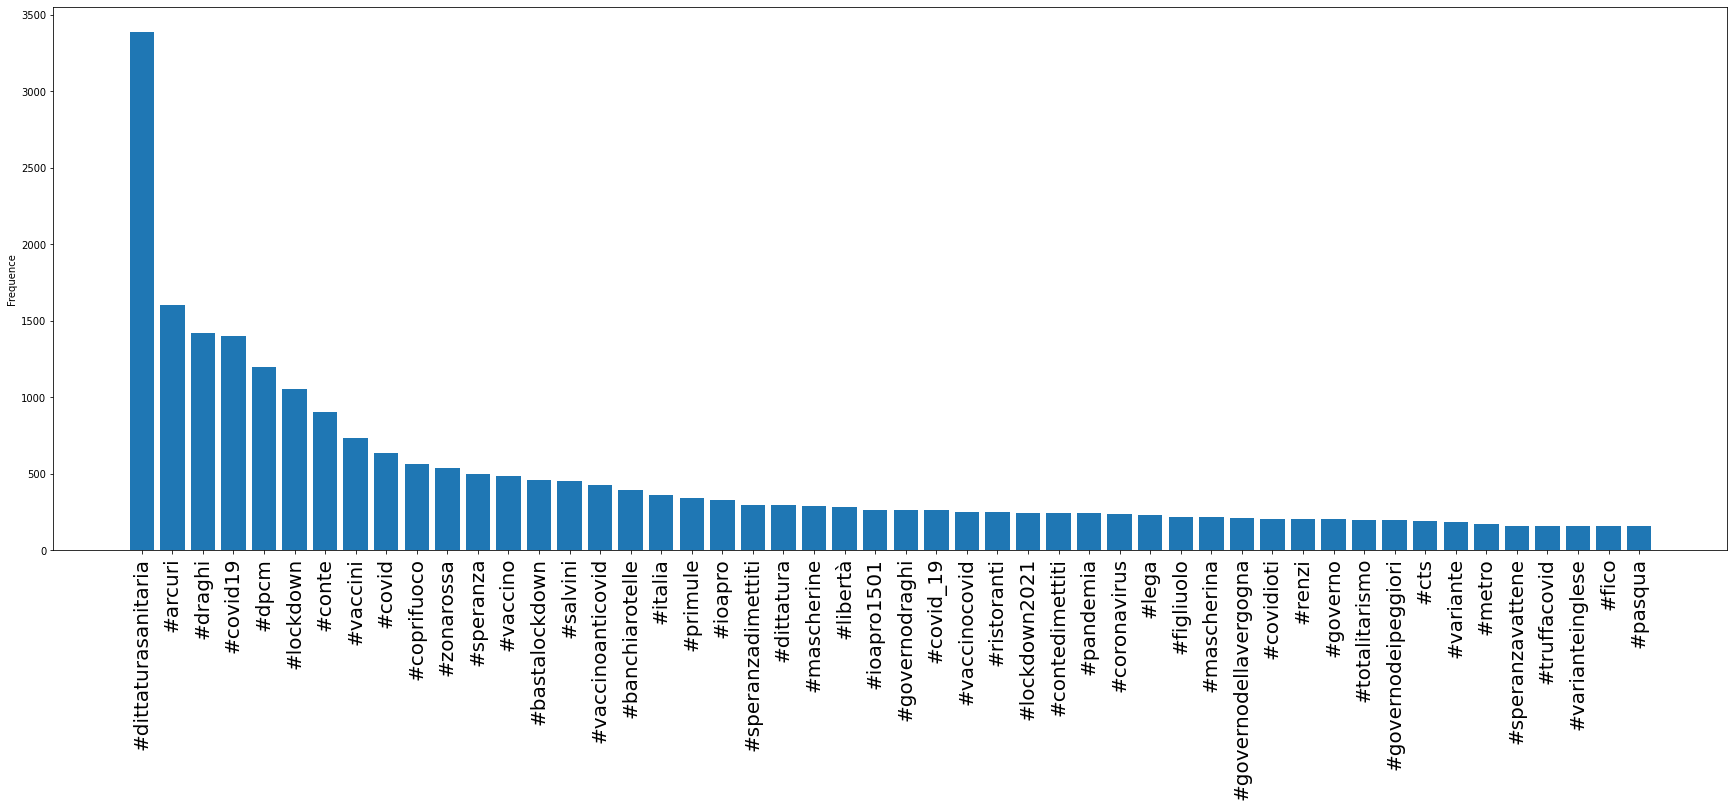

In [ ]:
hashtags = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/freq_hashtag_vaxcamp.csv")
plt.figure(figsize=(30,10))
plt.bar(hashtags[0:50]["Hashtag"],height=hashtags[0:50]["Count"])
plt.xticks(rotation=90,fontsize=20)
plt.ylabel("Frequence")
#plt.xlabel("Nodes")
plt.show()

### Pagerank 

Ascending and descending

	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


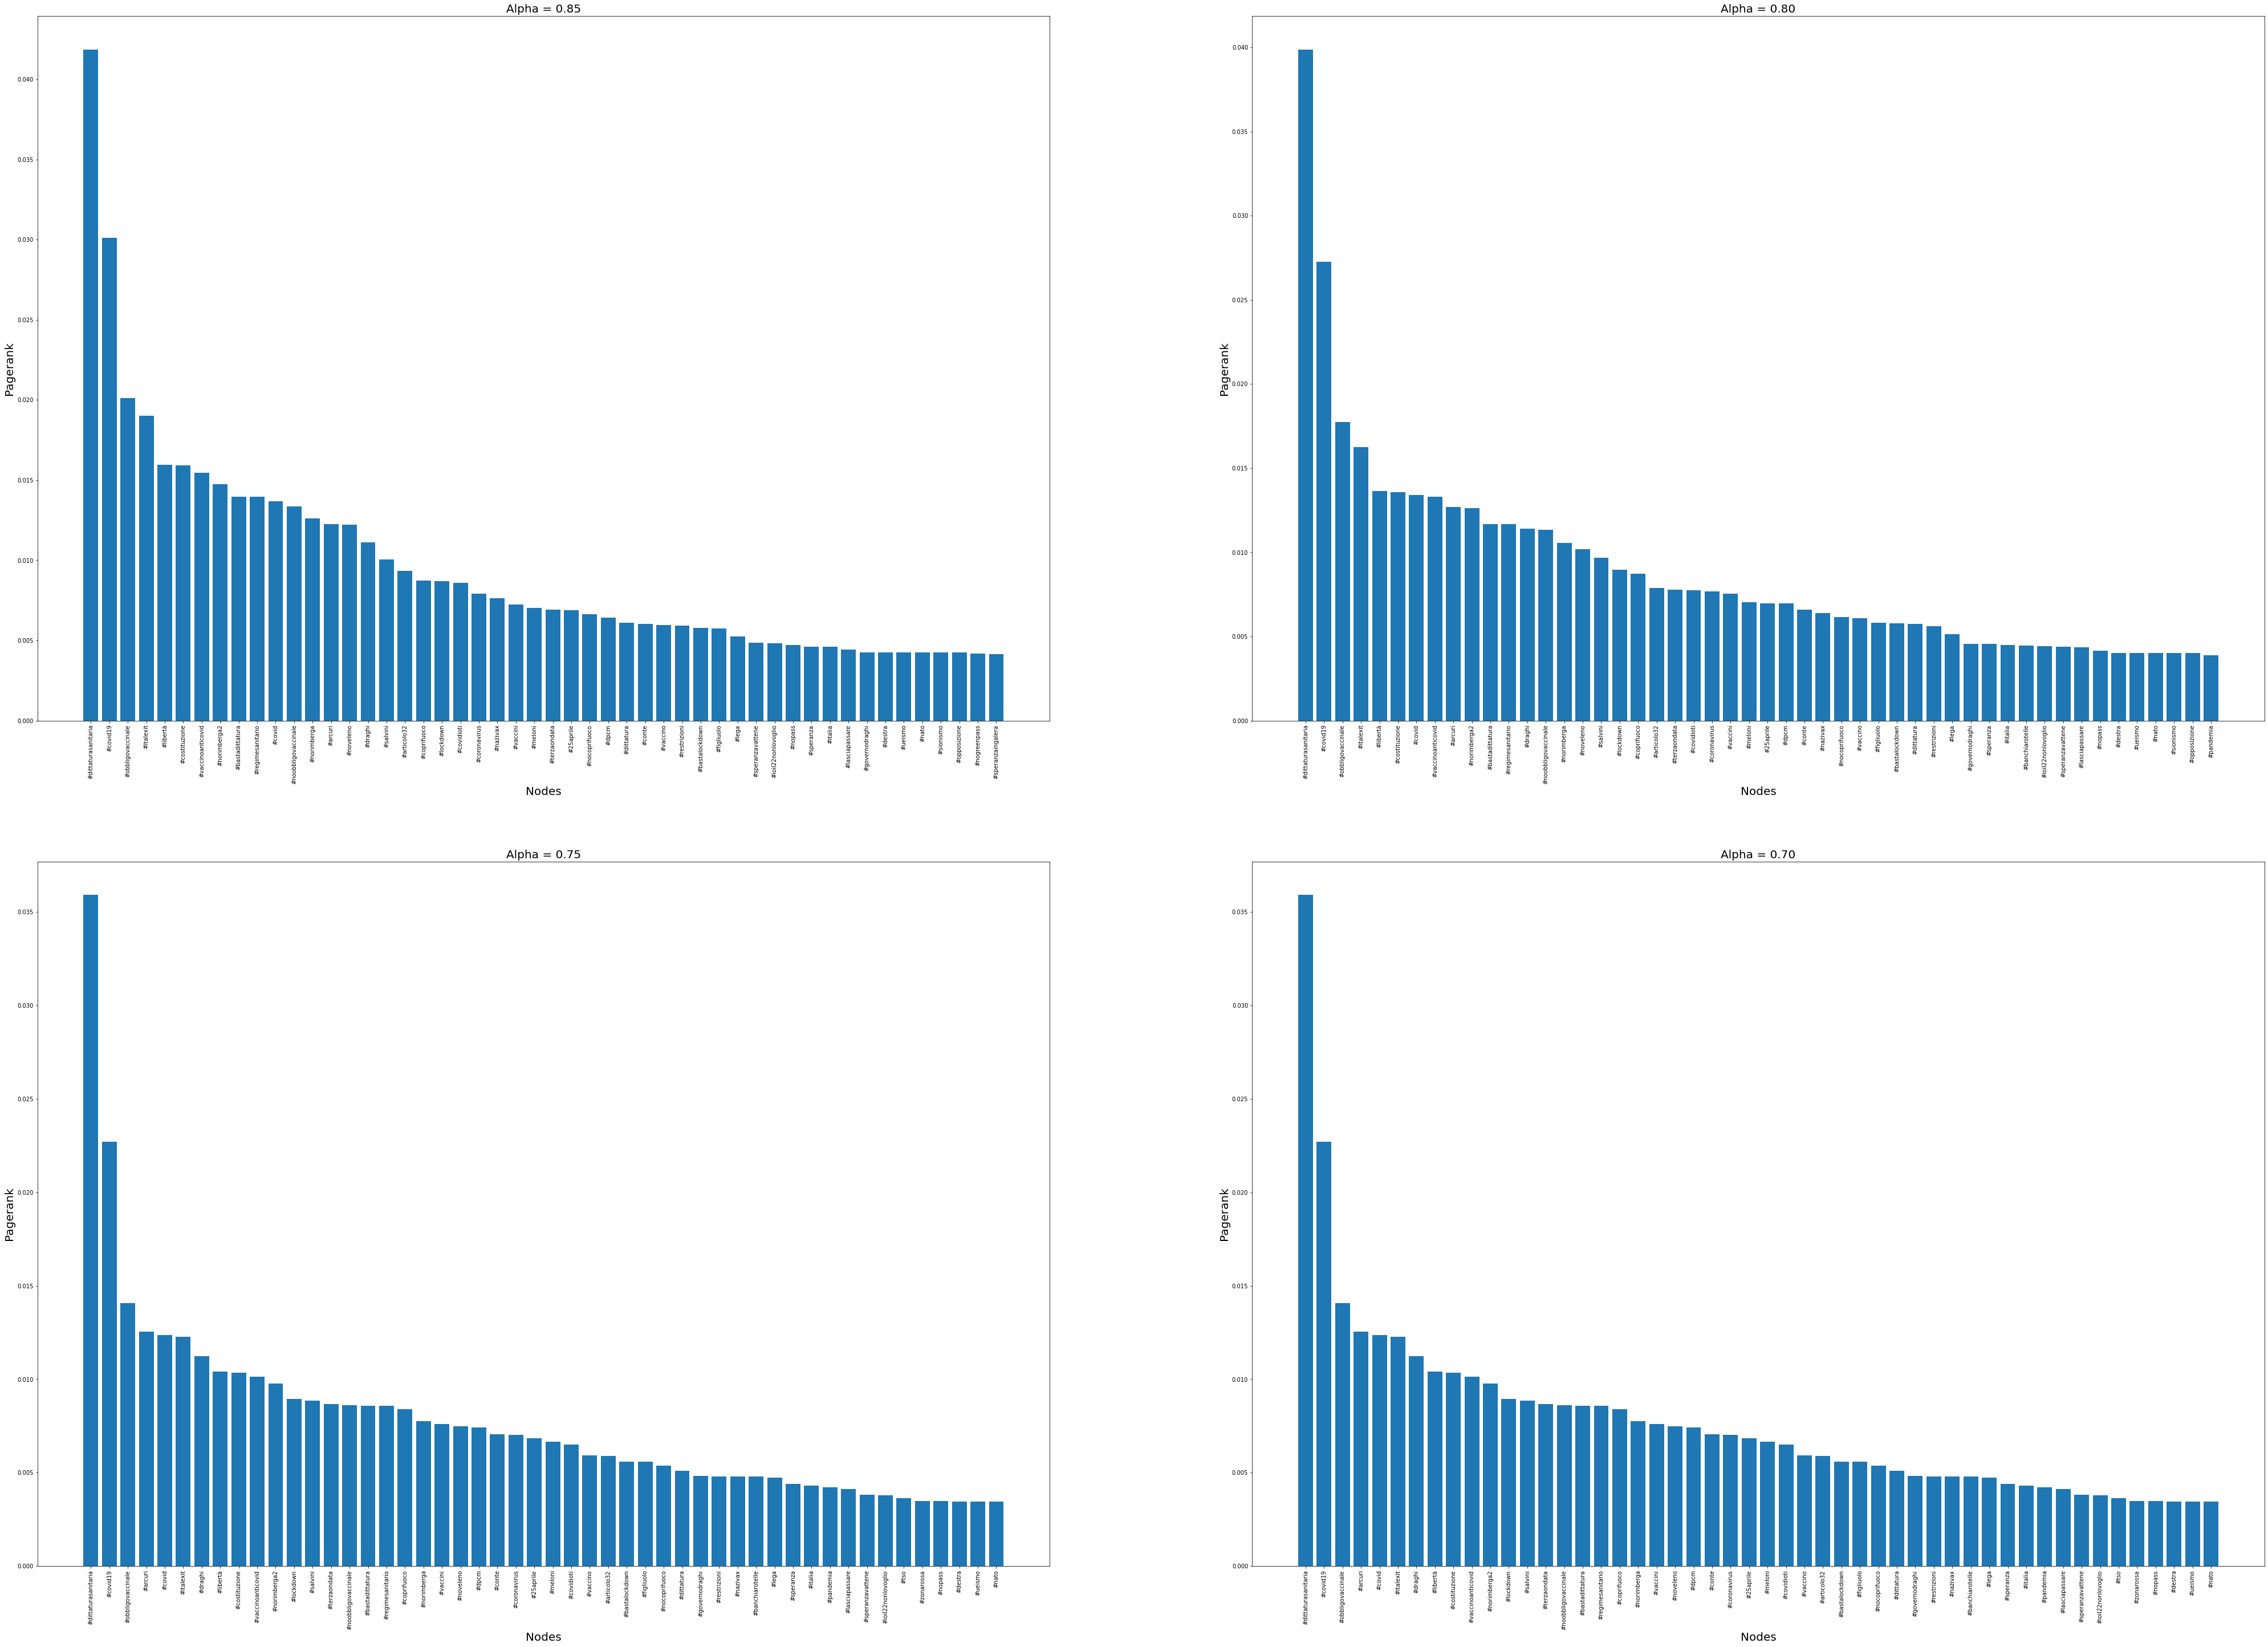

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hashtag,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hashtag,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hashtag,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hashtag,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


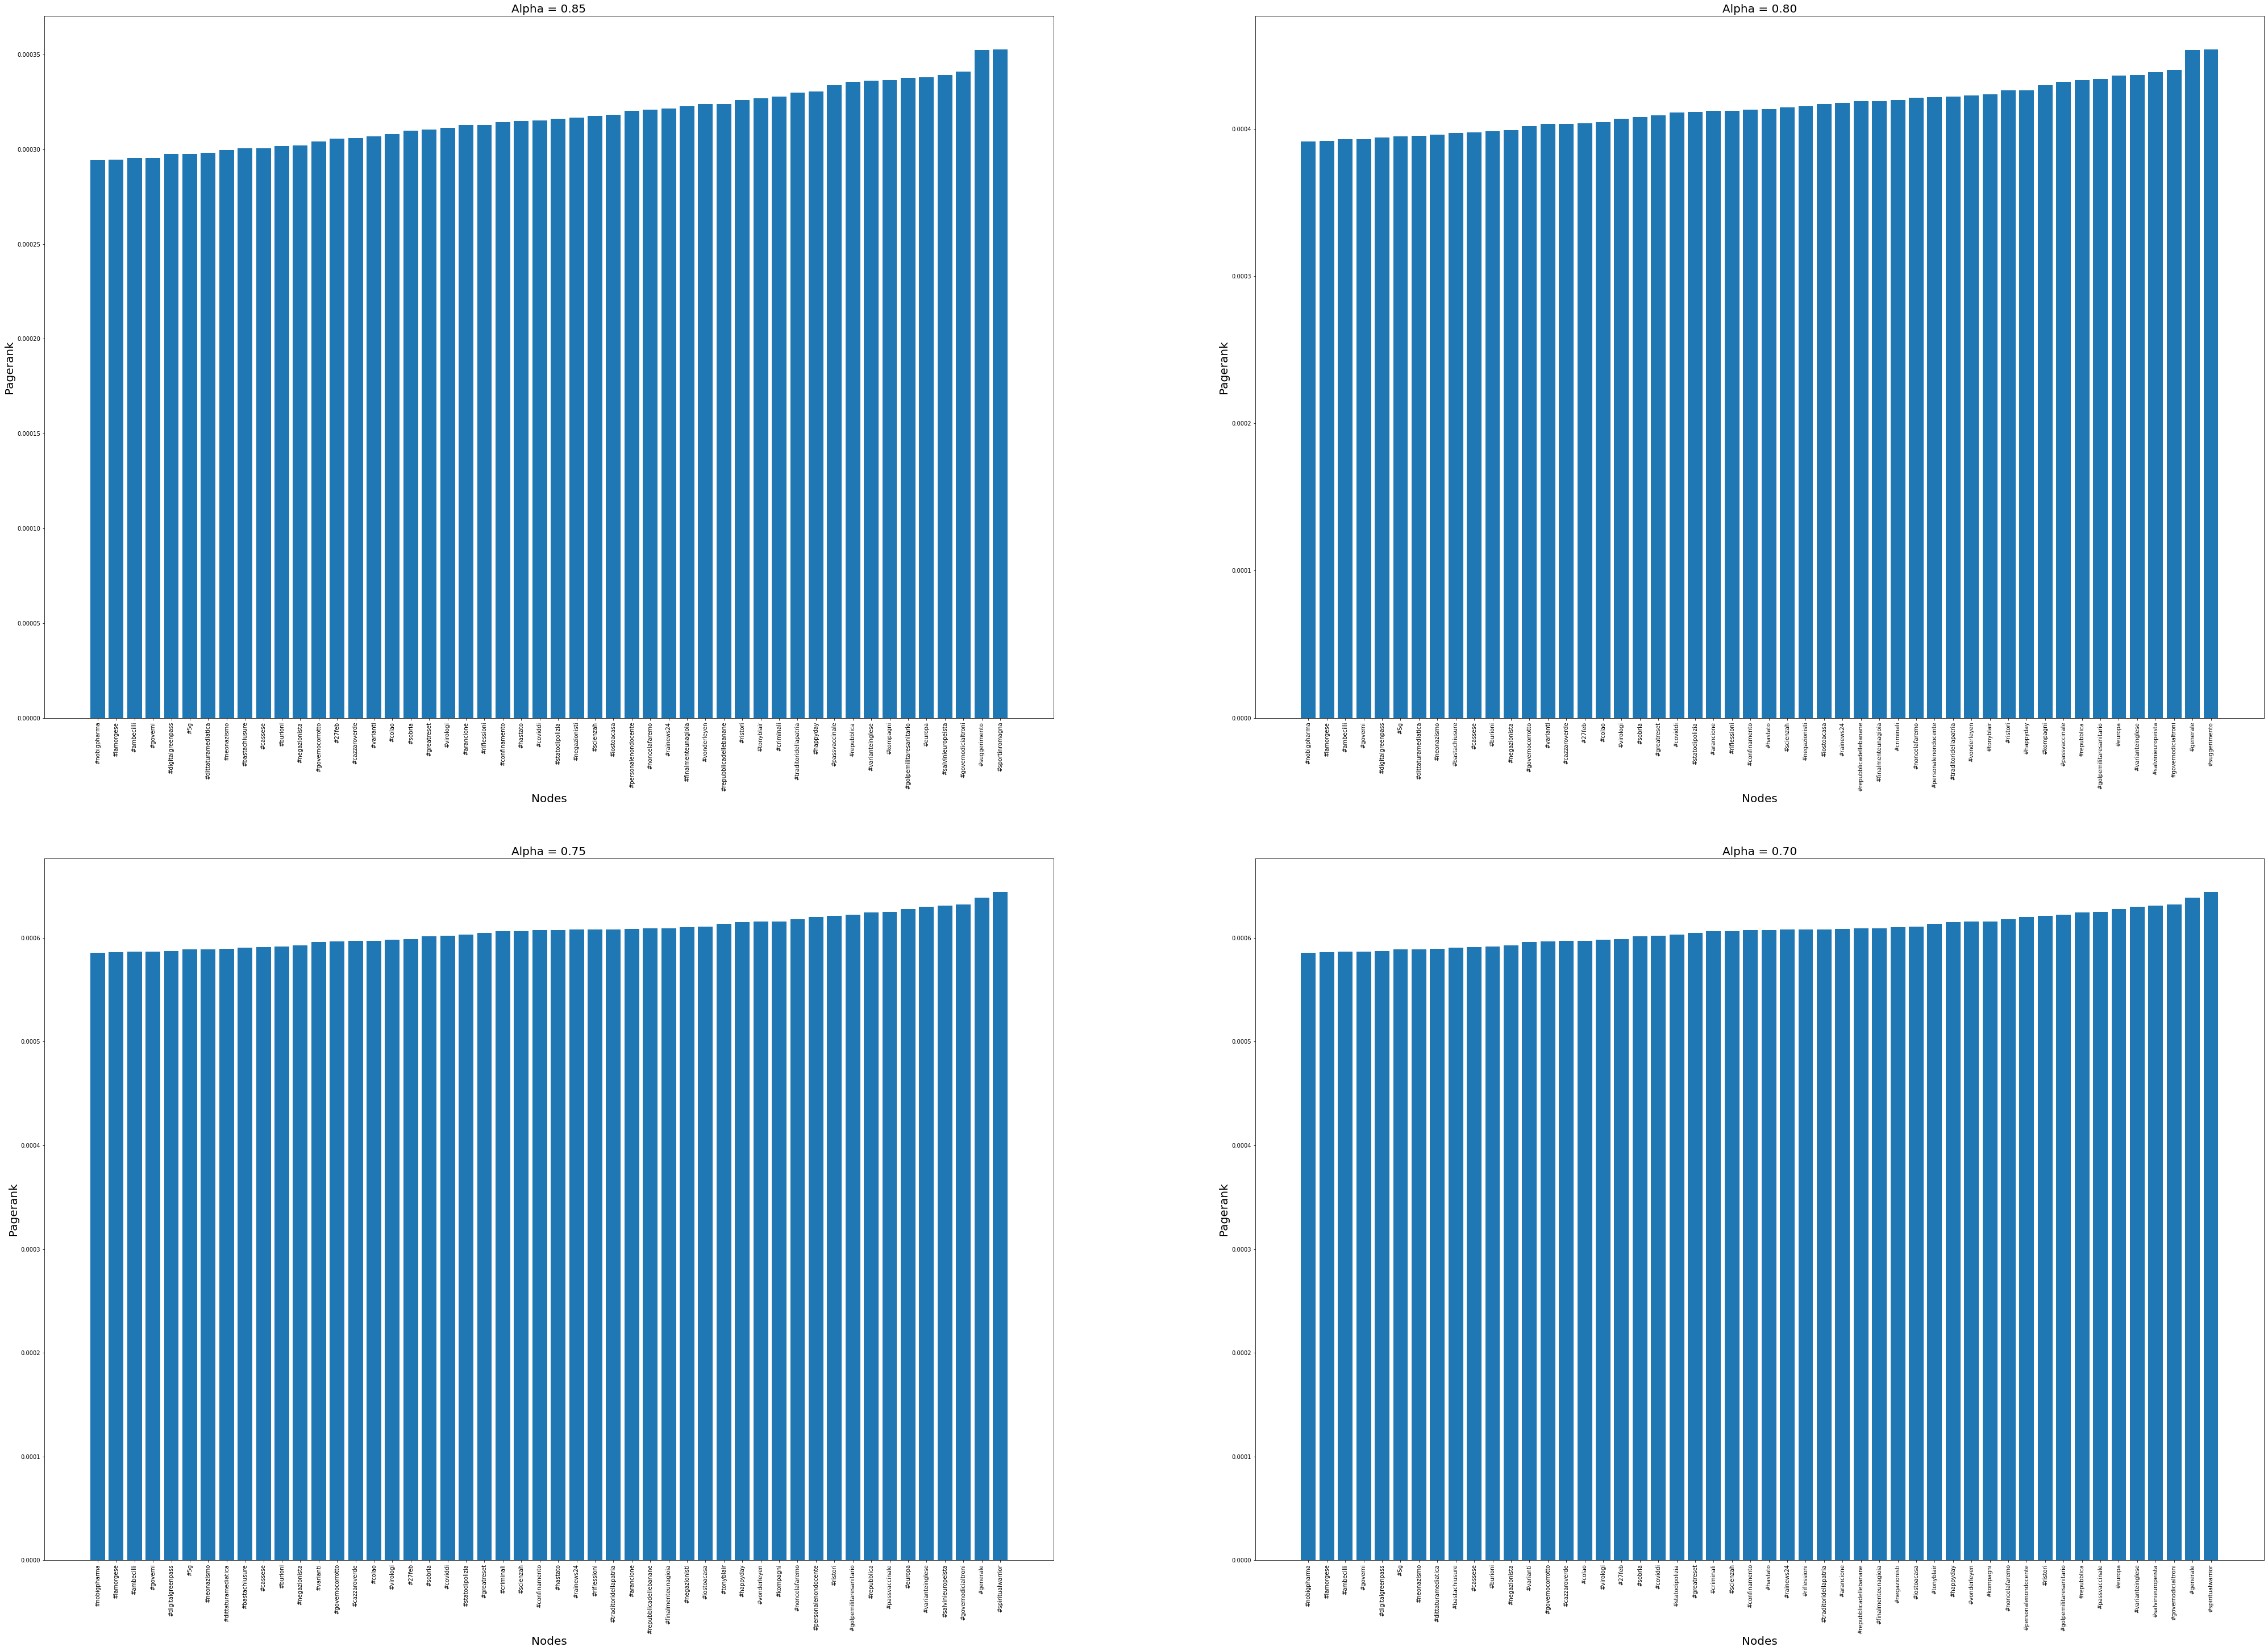

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hashtag,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr75 = nx.pagerank(G_hashtag,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr80 = nx.pagerank(G_hashtag,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = False)}

pr85= nx.pagerank(G_hashtag,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = False)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


### Node degree

Ascending and descending

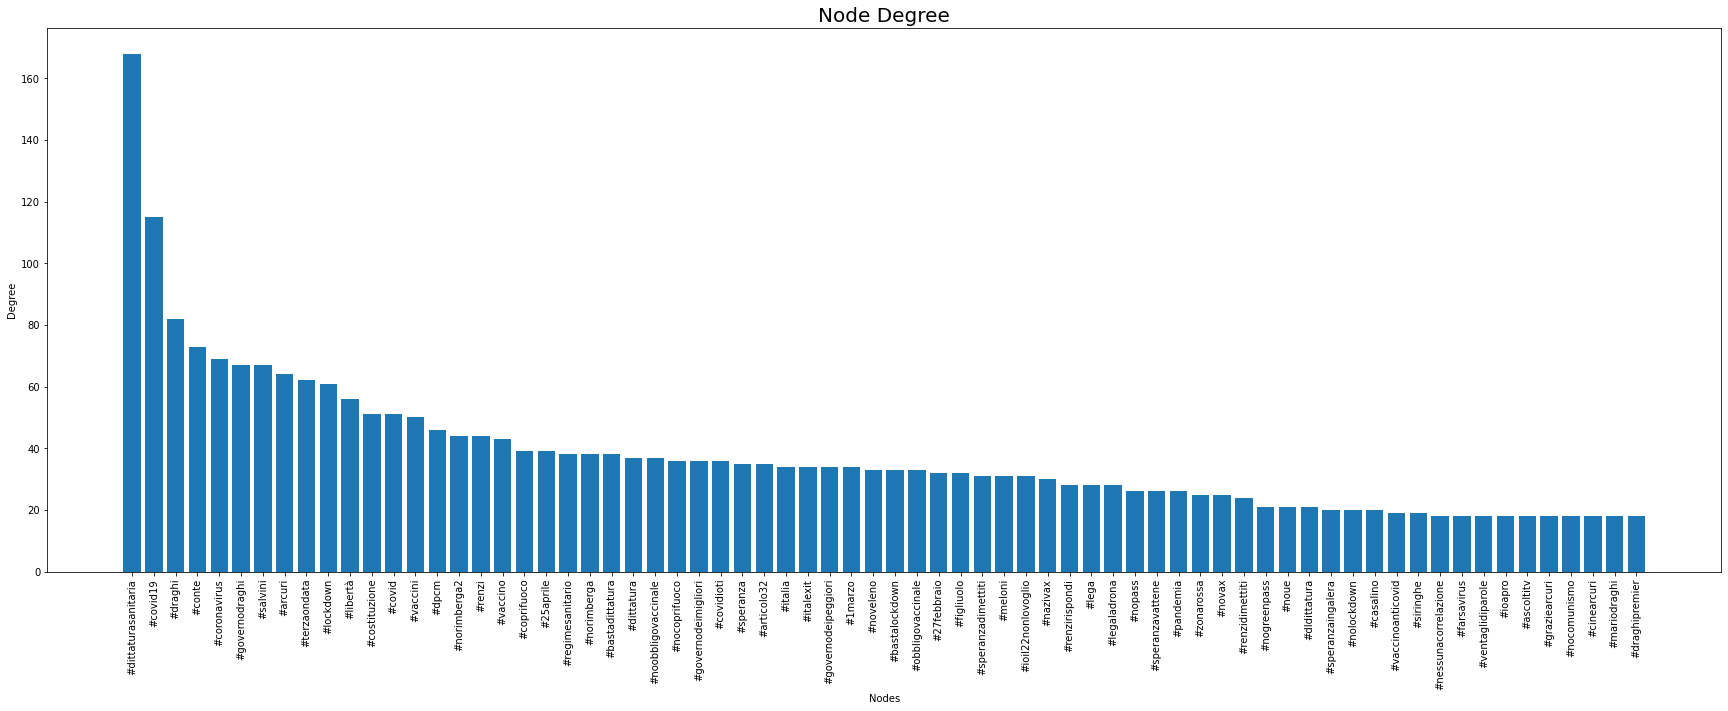

In [ ]:
most_imp = pd.Series(dict(G_hashtag.degree)).sort_values(ascending=False)[:70]
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

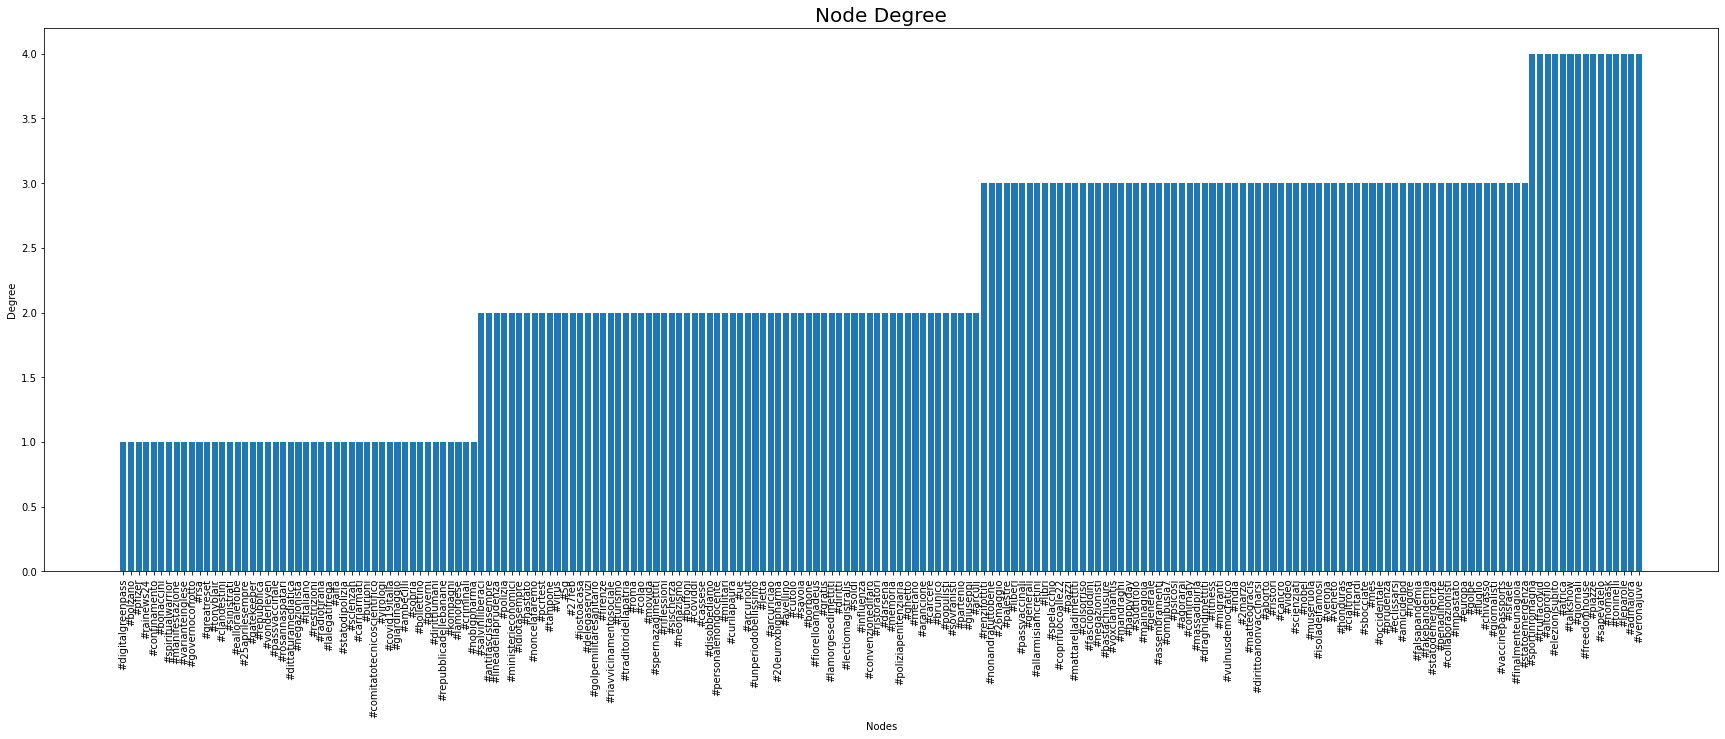

In [ ]:
less_imp = pd.Series(dict(G_hashtag.degree)).sort_values(ascending=True)[:200]
plt.figure(figsize=(30,10))
plt.bar(less_imp.index,height=less_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

In [ ]:
blacklist = list(most_imp[(most_imp>100)].index)
blacklist.extend(list(less_imp[(less_imp<2)].index))
blacklist

['#dittaturasanitaria',
 '#covid19',
 '#digitalgreenpass',
 '#bolzano',
 '#pfizer',
 '#rainews24',
 '#confinamento',
 '#bonaccini',
 '#spiritualwarrior',
 '#manifestazione',
 '#varianteinglese',
 '#governocorrotto',
 '#rsa',
 '#greatreset',
 '#tonyblair',
 '#clandestini',
 '#sinistrati',
 '#ealloralefoibe',
 '#25aprilesempre',
 '#gatekeeper',
 '#repubblica',
 '#vonderleyen',
 '#passvaccinale',
 '#rosannaspatari',
 '#dittaturamediatica',
 '#negazionista',
 '#italiano',
 '#restrizioni',
 '#radiotirana',
 '#lalegatifrega',
 '#aifa',
 '#statodipolizia',
 '#scienzah',
 '#carriarmati',
 '#burioni',
 '#comitatotecnicoscientifico',
 '#virologi',
 '#covid19italia',
 '#giardinaggio',
 '#ambecilli',
 '#sobria',
 '#bollettino',
 '#governi',
 '#dirittiumani',
 '#repubblicadellebanane',
 '#kompagni',
 '#lamorgese',
 '#criminali',
 '#nobigpharma']

## As we can notice the first 2 node have a really high frequqncy, node degree & Pagerank

So we will discard them because think about the com. detect. Also the node with a small degree and 

In [ ]:
up_weighted_hashtag_postgp = []
edge_postgp = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_vaxcamp.csv',header=None)
for i in range(edge_postgp.shape[0]):
  if (edge_postgp.iloc[i,0] not in blacklist) and(edge_postgp.iloc[i,1] not in blacklist):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_postgp.append((edge_postgp.iloc[i,0],edge_postgp.iloc[i,1],edge_postgp.iloc[i,2]))

G_hashtag = nx.Graph()
G_hashtag.add_weighted_edges_from(up_weighted_hashtag_postgp)

NameError: ignored

In [ ]:
filename_postgp = "/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_vaxcamp.csv"
nx.write_weighted_edgelist(G_hashtag, filename_postgp, delimiter=",")

### The network is connected? (If not wich are tha connected componets)

In [ ]:
iG_hashtag = ig.Graph.from_networkx(G_hashtag)
print("\t \t \t \t \t \t  \t \t \t  CONNECTION")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Is the graph connected:","YES" if iG_hashtag.is_connected() else "NO")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("The connected componet are:")
print("\t")
#IF NOT YOU CAN FIND ISOLATED COMPONENENTS
skip = True 
isolated = {}
i = 1
for component in iG_hashtag.components():
  print(component)
  if not skip:
    isolated[i] = component
    i+=1
  skip =False
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  


	 	 	 	 	 	  	 	 	  CONNECTION
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pandas.core.common import flatten
isolated_list = list(flatten(list(isolated.values())))
isolated_list
temp = [len(i) for i in isolated.values()]
find_the_comunities = dict(zip([i+1 for i in range(len(isolated.keys()))],temp))

In [ ]:
counter = 0
find_counter = 1
check_com = 0
isolated = []
print("\t \t \t  Hashtag of the connected component")
print("--------------------------------------------------------------------------------------------")
for vertice in iG_hashtag.vs:
    if counter in isolated_list:
      if check_com==find_the_comunities[find_counter]:
        print("--------------------------------------------------------------------------------------------")
        find_counter+=1
        check_com=0
      isolated.append(vertice.attributes()['_nx_name'])
      print(f" The hashtag {vertice.attributes()['_nx_name'].upper()}, is in the isolated component number: {find_counter}")
      check_com+=1
    counter+=1
print("--------------------------------------------------------------------------------------------")

	 	 	  Hashtag of the connected component
--------------------------------------------------------------------------------------------
 The hashtag #UNPERIODOBELLISSIMO, is in the isolated component number: 1
 The hashtag #LETTA, is in the isolated component number: 1
--------------------------------------------------------------------------------------------
 The hashtag #MERANO, is in the isolated component number: 2
 The hashtag #GHETTO, is in the isolated component number: 2
 The hashtag #MEMORIA, is in the isolated component number: 2
--------------------------------------------------------------------------------------------
 The hashtag #RISTORATORI, is in the isolated component number: 3
 The hashtag #SOLDI, is in the isolated component number: 3
 The hashtag #DIRITTI, is in the isolated component number: 3
--------------------------------------------------------------------------------------------
 The hashtag #ANTIFASCISTASEMPRE, is in the isolated component number: 4
 The ha

In [ ]:
up_weighted_hashtag_connected = []
edge = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_vaxcamp.csv",header=None)
index_comp_con = []
for i in range(edge.shape[0]):
      if (edge.iloc[i,0] not in isolated) and (edge.iloc[i,1] not in isolated) and (edge.iloc[i,2]>0) and not (edge.iloc[i,1] in blacklist) and not (edge.iloc[i,0] in blacklist):
        #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
        #if(network[edge])>1: 
        up_weighted_hashtag_connected.append((edge.iloc[i,0],edge.iloc[i,1],edge.iloc[i,2]))
        index_comp_con.append(i)
      
G_hashtag_connected= nx.Graph()
G_hashtag_connected.add_weighted_edges_from(up_weighted_hashtag_connected)

In [ ]:
edge.iloc[index_comp_con,:].to_csv("//content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_clean_vaxcamp.csv",header=None)

In [ ]:
edge.iloc[index_comp_con,:]

,0,1,2
0,#breakingnews,#coronavirus,129
1,#breakingnews,#lockdown,129
2,#breakingnews,#covid,129
3,#breakingnews,#coronavirusitalia,129
4,#breakingnews,#covidiota,129
...,...,...,...
2234,#flowers,#nature,3
2235,#flowers,#garden,3
2236,#wildflowers,#nature,3
2237,#wildflowers,#garden,3


## Working on the giant Network component

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_postgp = []
edge = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_clean_vaxcamp.csv",header=None).iloc[:,1:]
for i in range(edge.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_postgp.append((edge.iloc[i,0],edge.iloc[i,1],edge.iloc[i,2]))

G_hashtag_connected = nx.Graph()
G_hashtag_connected.add_weighted_edges_from(up_weighted_hashtag_postgp)

In [ ]:
filename_postgp = "/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_hashtag_clean_connected.csv"
nx.write_weighted_edgelist(G_hashtag_connected, filename_postgp, delimiter=",")

In [ ]:
iG_hashtag_connected = ig.Graph.from_networkx(G_hashtag_connected)

<ipython-input-13-e95ae5932e4d>:24: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pow_law2(G_hashtag_connected)),'o')


Text(0, 0.5, 'log(CCDF)')

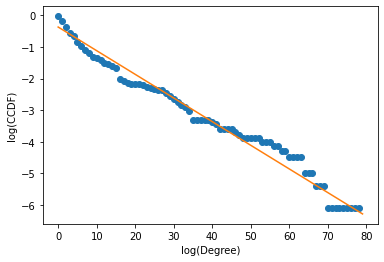

In [ ]:
def pow_law2(g):
  degrees = {}
  for node in g.nodes():
    key = len(list(g.neighbors(node)))
    degrees[key] = degrees.get(key, 0) + 1

  max_degree = max(degrees.keys(), key=int)
  num_nodes = []
  for i in range(1, max_degree + 1):
    num_nodes.append(degrees.get(i, 0))


  cum=[]
  t=0
  for x in num_nodes:
    t+=x
    cum.append(t)

  cum2=[]
  for x in cum:
    cum2.append(1-x/cum[-1])
  return cum2

plt.plot(np.log(pow_law2(G_hashtag_connected)),'o')
plt.plot(np.log([0.928**(x+5)  for x in range(len(pow_law2(G_hashtag_connected))) ]))
plt.xlabel("log(Degree)")
plt.ylabel("log(CCDF)")

#### Network diameter

In [ ]:
# DIAMETER - HOW FAR ARE THE TWO MOST DISTANT NODES

print("Network diameter:", iG_hashtag_connected.diameter(directed=False))

# GET NODES IN THE DIAMETER PATH 
diameter_path = []
d = iG_hashtag_connected.get_diameter()
for i in range(0, iG_hashtag_connected.diameter()):
  diameter_path.append((d[i], d[i+1]))
# GET EDGES IN THE DIAMETER PATH
diameter_edges = iG_hashtag_connected.get_eids(pairs=diameter_path, directed=False)


# AVERAGE PATH LENGTH - HOW CLOSE ARE THE NODES TO EACH OTHER ON AVERAGE

print("Average path length:", iG_hashtag_connected.average_path_length(directed=False))

Network diameter: 7
Average path length: 3.025108930754522


In [ ]:
spl = dict(nx.all_pairs_shortest_path_length(G_hashtag_connected))

In [ ]:
rous = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
u = []
for t in spl.keys():
  a = []
  for j in spl[t].values():
    if j not in a:
      l = len([k for k, v in spl[t].items() if v == j])
    rous[j]+= l
  a.append(j)

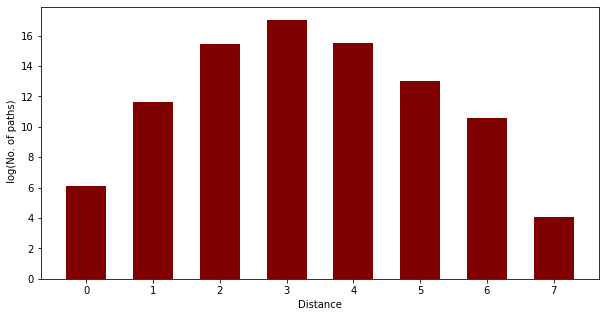

In [ ]:
data = rous
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, np.log(values), color ='maroon',
        width = 0.6)
 
plt.xlabel("Distance")
plt.ylabel(" log(No. of paths)")
#plt.title("Distance Distribution Histogram")
plt.show()

### Node degree

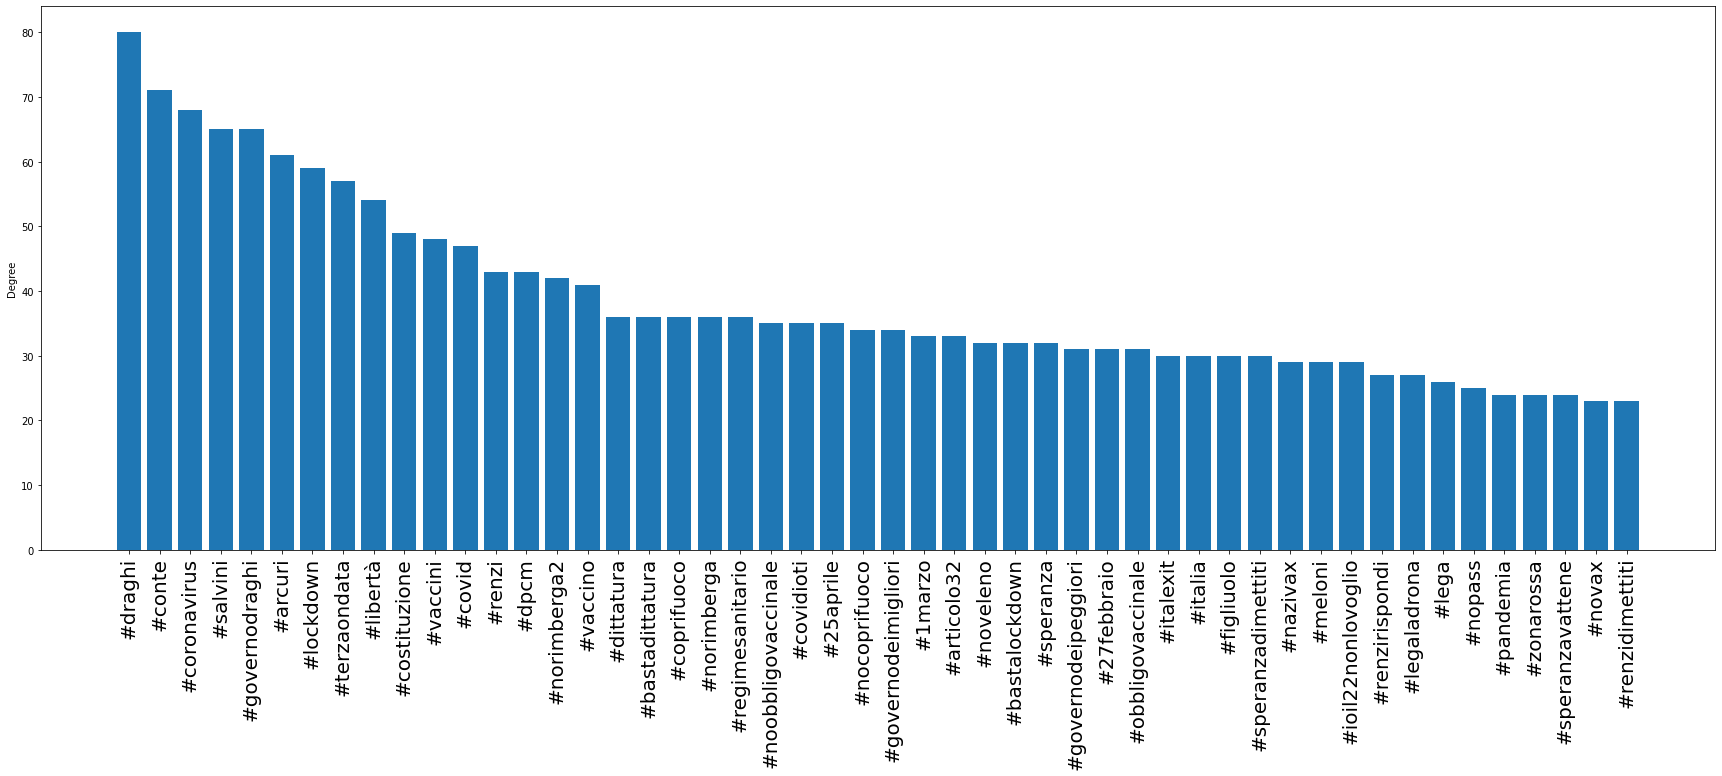

In [ ]:
most_imp = pd.Series(dict(G_hashtag_connected.degree)).sort_values(ascending=False)[:50]
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90,fontsize=20)
#plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
#plt.xlabel("Nodes",fontsize=10)
plt.show()

In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

In [ ]:
# rous is a dictionary where -> keys: degree, values: n° of times that degree appear

rous = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = len([k for k, v in deg_dic.items() if v == j])
    rous[j] = l
  z.append(j)

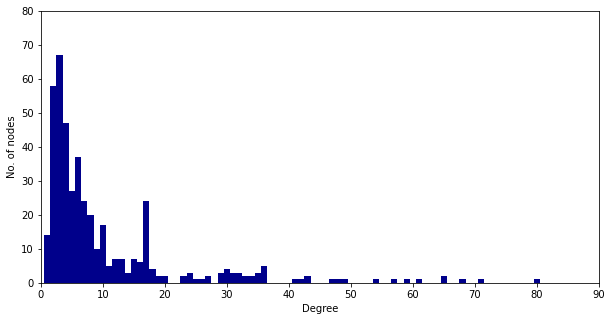

In [ ]:
data = rous
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='darkblue',
        width = 1)
plt.axis([0, 90, 0, 80])
plt.xlabel("Degree")
plt.ylabel("No. of nodes")
#plt.title("Degree Distribution Histogram")
plt.show()

In [ ]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def av_degree(g):
  deg = dict(g.degree)
  av = sum(list(deg.values()))/len(list(deg.keys()))
  return av

# ------------------------------------------------------------

def nth_moment(g,n):
    s = 0
    for node in g.nodes:
        s += g.degree[node] ** n
    return (s/len(g))

# -----------------------------------------------------------

import powerlaw

def pow_law(g):
  degrees = {}
  for node in g.nodes():
    key = len(list(g.neighbors(node)))
    degrees[key] = degrees.get(key, 0) + 1

  max_degree = max(degrees.keys(), key=int)
  num_nodes = []
  for i in range(1, max_degree + 1):
    num_nodes.append(degrees.get(i, 0))

  fit = powerlaw.Fit(num_nodes)
  return fit.power_law.alpha+1

In [ ]:
print(r"The average degree of the Graph is:", av_degree(G_hashtag_connected))
print(r"The second moment Degree is:", nth_moment(G_hashtag_connected,2))
print(r"The third moment Degree is:", nth_moment(G_hashtag_connected,3))
print(r"Max Degree:", pd.Series(dict(G_hashtag_connected.degree)).sort_values(ascending=False)[0])
print(r"Min Degree:", pd.Series(dict(G_hashtag_connected.degree)).sort_values(ascending=False)[-1])

The average degree of the Graph is: 10.105022831050228
The second moment Degree is: 248.92694063926942
The third moment Degree is: 10235.721461187215
Max Degree: 80
Min Degree: 1


### Degree distribution and Gamma estimation

In [ ]:
A = nx.adjacency_matrix(G_hashtag_connected)
d = np.sum(A,1)
d = np.squeeze(np.asarray(d))
d = d[d>0]
k = np.unique(d)
pk = np.histogram(d,k)[0]
pk = pk/np.sum(pk)
Pk = 1-np.cumsum(pk)

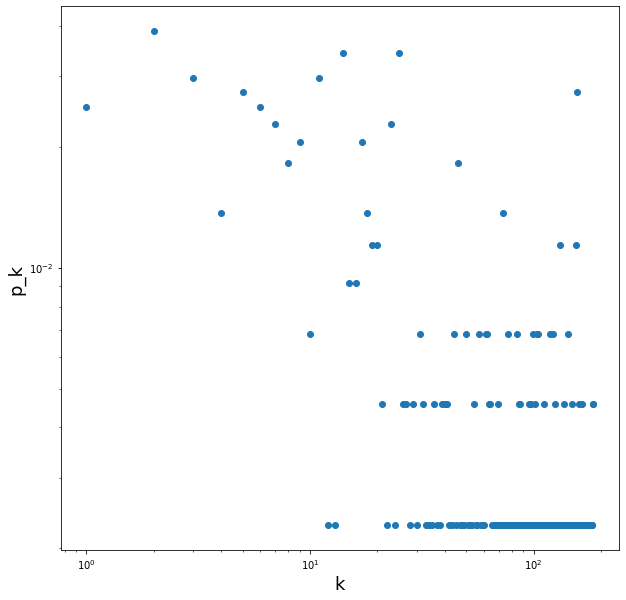

In [ ]:
fig = plt.figure(figsize=(10,10))
x = np.arange(10,150)

plt.loglog(pk,'o')
plt.plto()
#plt.title("Degree Distribution",size=20)
plt.xlabel("k",size=18)
plt.ylabel("p_k",size=18)
plt.show()

In [ ]:
####### Gamma estimation
print("\t \t Gamma estimation (Free scale or random graph")
print("-------------------------------------------------------------------------")
d2 = d[d>=k.min()]
gamma = 1 + np.mean(np.log(d2/k.min()))
print(f"Gamma with the k min selected as the smallest neighbours, so k={k.min()}")
print(f"Gamma = {gamma}")
d2 = d[d>=5e1]
gamma = 1 + np.mean(np.log(d2/7e1))
print("-------------------------------------------------------------------------")
print(f"Gamma with the k min wisely selected, using the plot above, so k={7e1}")
print(f"Gamma = {gamma}")
print("-------------------------------------------------------------------------")

	 	 Gamma estimation (Free scale or random graph
-------------------------------------------------------------------------
Gamma with the k min selected as the smallest neighbours, so k=1
Gamma = 5.348220196611956
-------------------------------------------------------------------------
Gamma with the k min wisely selected, using the plot above, so k=70.0
Gamma = 2.927098566655079
-------------------------------------------------------------------------



### Pagerank 

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hashtag_connected,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hashtag_connected,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hashtag_connected,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hashtag_connected,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


In [ ]:
pr85= nx.pagerank(G_hashtag_connected,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
plt.xticks(rotation=90,fontsize=20)
#plt.title("Betweenes",fontsize=20)
plt.ylabel("PageRank")
#plt.xlabel("Nodes")
plt.show()

In [ ]:
bw = nx.betweenness_centrality(G_hashtag_connected)
bw_sort = {k : v for k, v in sorted(bw.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(bw_sort.keys())[0:50],height=list(bw_sort.values())[0:50])
plt.xticks(rotation=90,fontsize=20)
#plt.title("Betweenes",fontsize=20)
plt.ylabel("Betweenness")
#plt.xlabel("Nodes")
plt.show()

### Betweenes

In [ ]:
pr = nx.pagerank(G_hashtag_connected)
pr_sort = {k : v for k, v in sorted(pr.items(), key = lambda t : t[1], reverse = True)}

bw = nx.betweenness_centrality(G_hashtag_connected)
bw_sort = {k : v for k, v in sorted(bw.items(), key = lambda t : t[1], reverse = True)}

#plt.figure(figsize=(30,10))
#plt.bar(list(bw_sort.keys())[0:50],height=list(bw_sort.values())[0:50])
#plt.xticks(rotation=90)
#plt.title("PageRank",fontsize=20)
#plt.ylabel("PageRank")
#plt.xlabel("Nodes")
#plt.show()


### Closesness

In [ ]:
close = nx.closeness_centrality(G_hashtag_connected)
close_sort = {k : v for k, v in sorted(close.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(close_sort.keys())[0:50],height=list(close_sort.values())[0:50])
plt.xticks(rotation=90,fontsize=20)
#plt.title("Closesness",fontsize=20)
plt.ylabel("Closeness")
#plt.xlabel("Nodes")
plt.show()

### Comparing Closeness, Betweenes and Pagerank

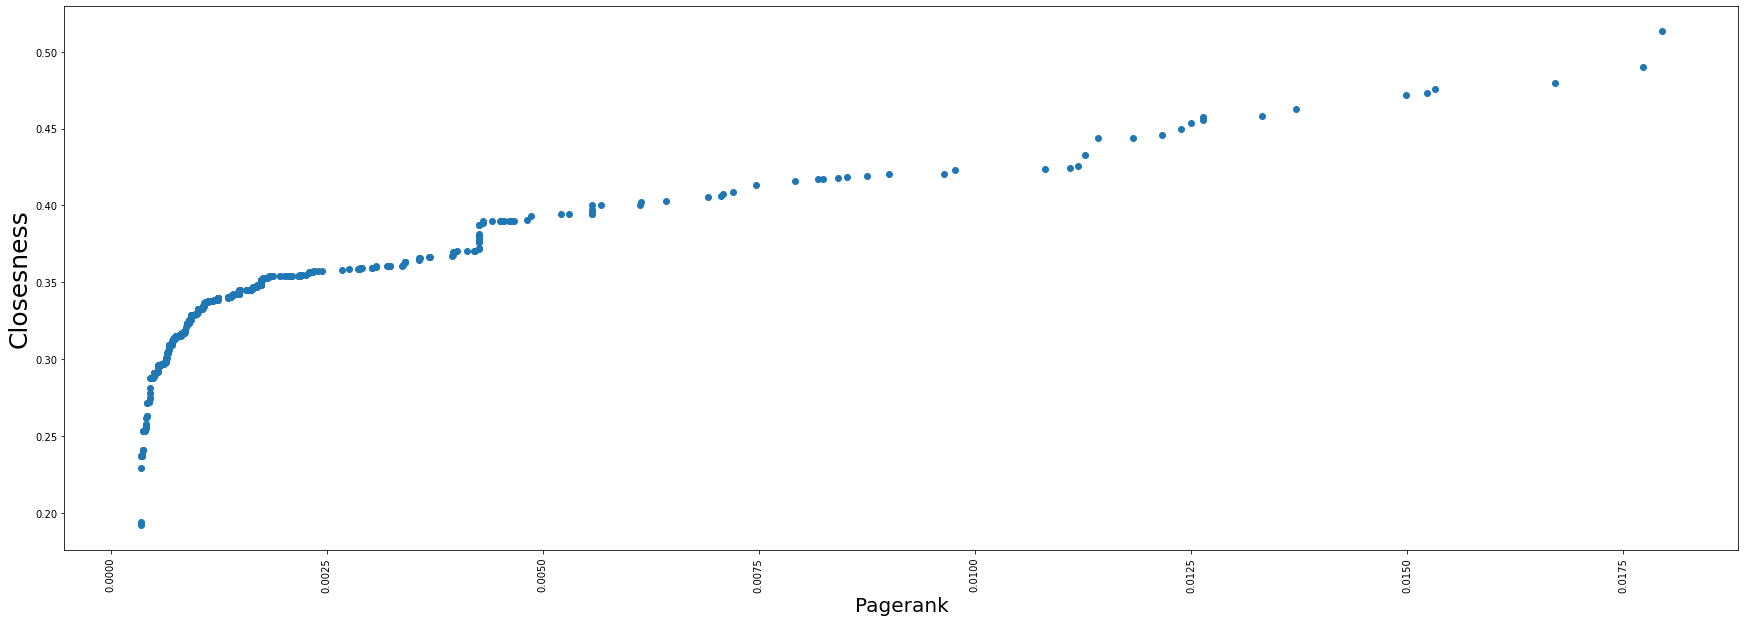

In [ ]:
plt.figure(figsize=(30,10))
plt.scatter(list(pr_sort.values()),list(close_sort.values()))
plt.xticks(rotation=90)
#plt.title("Closeness vs Pagerank85",fontsize=20)
plt.ylabel("Closesness", fontsize=25)
plt.xlabel("Pagerank", fontsize=20)
plt.show()

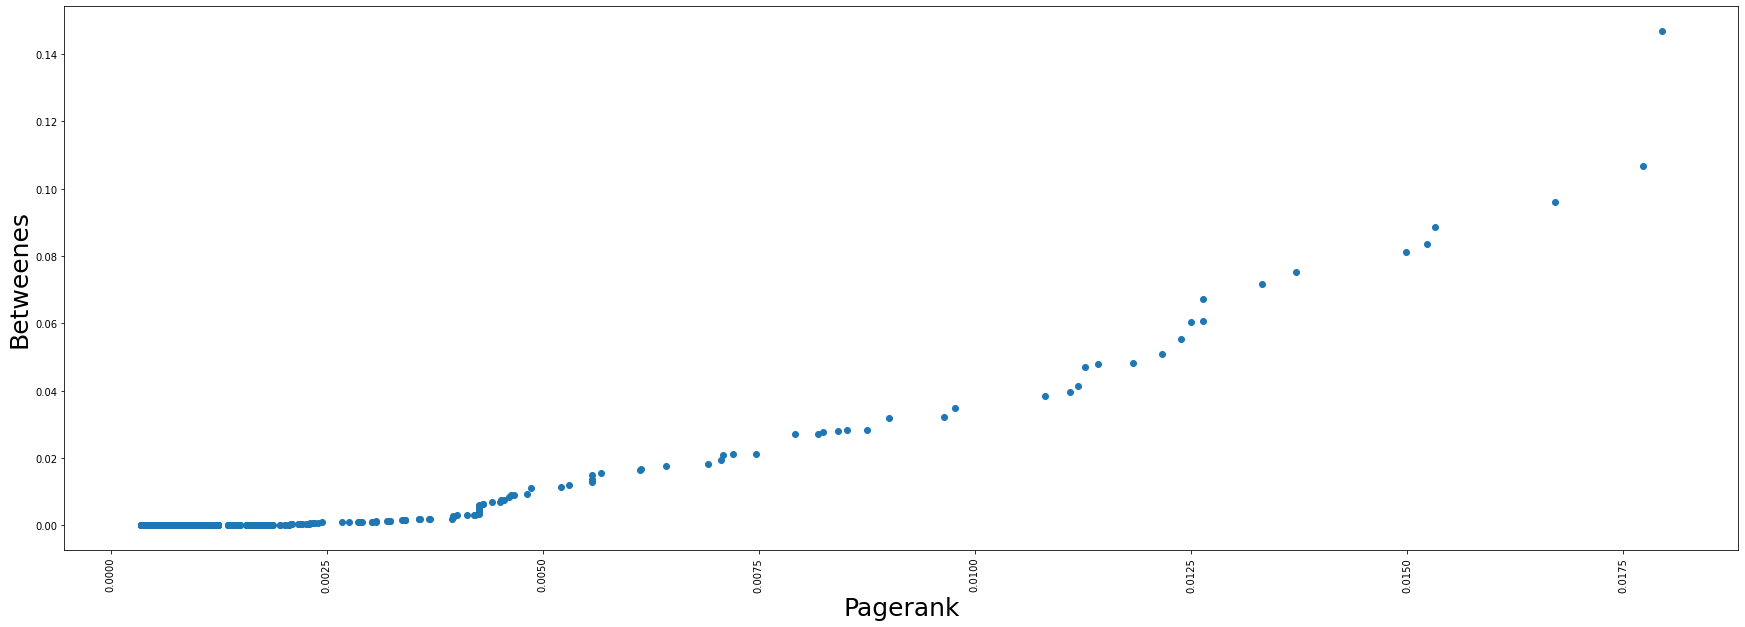

In [ ]:
plt.figure(figsize=(30,10))
plt.scatter(list(pr_sort.values()),list(bw_sort.values()))
plt.xticks(rotation=90)
#plt.title("Betweenes vs Pagerank85",fontsize=20)
plt.ylabel("Betweenes", fontsize=25)
plt.xlabel("Pagerank", fontsize=25)
plt.show()

### Global Clustering coefficient

In [ ]:
print("Global clustering coefficient", iG_hashtag_connected.transitivity_undirected())

Global clustering coefficient 0.38786279683377306


### Local clustering coefficiet 

In [ ]:
# LOCAL CC - ARE THE NEIGHBOURS OF THE NODES ALSO CONNECTED?
import math
print("Local clustering components:")
local_ccs = iG_hashtag_connected.transitivity_local_undirected()
nodes = iG_hashtag_connected.vs()
sum_cc = 0
for local_cc in local_ccs:
    if not math.isnan(local_cc):
        sum_cc += local_cc

for node in nodes:
        
        print("   Local clustering coefficient of node",node.attributes()['_nx_name'],":",local_ccs[node.index])

        
# AVERAGE CC

print("Average clustering component", sum_cc/len(iG_hashtag_connected.vs()))


Local clustering components:
   Local clustering coefficient of node #breakingnews : 1.0
   Local clustering coefficient of node #coronavirus : 0.20983318700614573
   Local clustering coefficient of node #lockdown : 0.14085330216247807
   Local clustering coefficient of node #covid : 0.13598519888991675
   Local clustering coefficient of node #coronavirusitalia : 1.0
   Local clustering coefficient of node #covidiota : 1.0
   Local clustering coefficient of node #tamponi : 1.0
   Local clustering coefficient of node #difettosi : 1.0
   Local clustering coefficient of node #svezia : 1.0
   Local clustering coefficient of node #scoperta : 1.0
   Local clustering coefficient of node #shock : 1.0
   Local clustering coefficient of node #articolo : 1.0
   Local clustering coefficient of node #qui : 1.0
   Local clustering coefficient of node #farsavirus : 1.0
   Local clustering coefficient of node #nocomunismo : 1.0
   Local clustering coefficient of node #covidioti : 0.30756302521008405
 

In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

<ipython-input-37-ed6971748205>:39: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(x_deg), np.log(y_C))
<ipython-input-37-ed6971748205>:40: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(x_deg_mean), np.log(y_C_mean),  alpha=0.9)


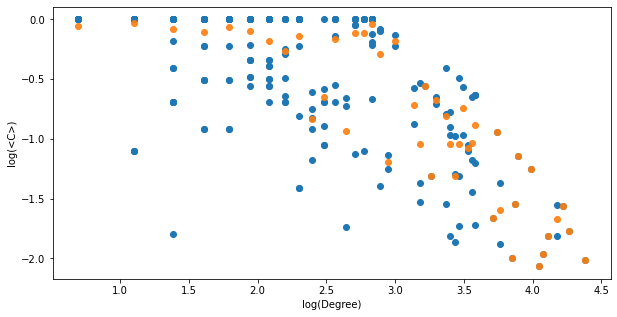

In [ ]:
# create two lists, one for the degree and another for the correspondent local clustering coefficients
local_ccs = iG_hashtag_connected.transitivity_local_undirected()
nodes = iG_hashtag_connected.vs()
x_deg = []
y_C = []
for node in nodes:
  x_deg.append(G_hashtag_connected.degree[node.attributes()['_nx_name']])
  y_C.append(local_ccs[node.index])

#-------------------------------------------------------------------------------

deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

# create a list with the average clustering coeffcients for each degree
y_C_mean = []
for i in range(len(deg_times.keys())):
  y_C_mean.append(nx.average_clustering(G_hashtag_connected, nodes=list(deg_times.values())[i]))

# create a list of the degree that we have in our network
x_deg_mean = []
for i in range(len(deg_times.keys())):
  x_deg_mean.append(list(deg_times.keys())[i])

#-------------------------------------------------------------------------------

# PLOT

fig = plt.figure(figsize = (10, 5))
 
# creating the scatter plot
plt.scatter(np.log(x_deg), np.log(y_C))
plt.scatter(np.log(x_deg_mean), np.log(y_C_mean),  alpha=0.9)

plt.xlabel("log(Degree)")
plt.ylabel("log(<C>)")
#plt.title("Clustering Coefficient")
plt.show()

In [ ]:
print(r"The Average Clustering Coefficient for the G_hashtag_connected is:", nx.average_clustering(G_hashtag_connected))

The Average Clustering Coefficient for the G_hashtag_connected is: 0.8048052146269394


### Assortativity

In [ ]:
print(f"The assortativity of the network: {nx.degree_assortativity_coefficient(G_hashtag_connected)}")

The assortativity of the network: -0.07282782278570939


In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

# make a dictionary with degree:list of hash -> ex. {2:['#something', '#something_else'],...}
deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

In [ ]:
x_degree = []
y_av_neigh = []
for k in deg_times.keys():
  for x in deg_times[k]:
    x_degree.append(k)
    y_av_neigh.append(nx.average_neighbor_degree(G_hashtag_connected)[x])

#-------------------------------------------------------------------------------

x_degree_mean = []
y_av_mean = []
for k in deg_times.keys():
  x_degree_mean.append(k)
  o = []
  for x in deg_times[k]:
    o.append(nx.average_neighbor_degree(G_hashtag_connected)[x])
  y_av_mean.append(np.mean(o))

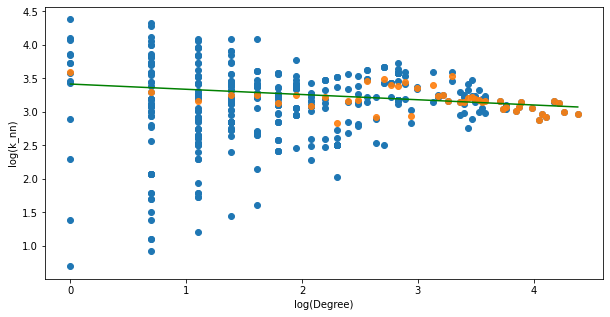

In [ ]:
# PLOT

fig = plt.figure(figsize = (10, 5))
 
# creating the scatter plot
plt.scatter(np.log(x_degree), np.log(y_av_neigh))
plt.scatter(np.log(x_degree_mean), np.log(y_av_mean),  alpha=0.9)

x = np.log(x_degree_mean)
y = np.log(y_av_mean)

m, b = np.polyfit(x, y, 1)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'green')
plt.xlabel("log(Degree)")
plt.ylabel("log(k_nn)")

plt.show()

### Comunities detection

In [ ]:
cummunities = {}
for i in np.linspace(1,60,5):
  cummunities[i] = nx_comm.louvain_communities(G_hashtag_connected,resolution=1,seed=int(i))


In [ ]:
salva = True
for i in cummunities:
  print(len(cummunities[i]))
  if salva:
    best_com = cummunities[i]
    salva = False
  for j in cummunities[i]:
      print(j)
  print("\t")

11
{'#novax', '#ioil22nonlovoglio', '#italia', '#negazionisti', '#shock', '#svezia', '#coronavirus', '#africa', '#arancione', '#ventaglidiparole', '#nocoprifuoco', '#nocomunismo', '#tamponi', '#nochiusure', '#farsavirus', '#scoperta', '#ascoltitv', '#vulnusdemocratico', '#articolo', '#influenza', '#qui', '#freedomhouse', '#difettosi'}
{'#toninelli', '#antonellaelia', '#giornalisti', '#draghi', '#etna', '#governodeimigliori', '#ristori', '#salviniliberaci', '#nature', '#piazzapulita', '#myanmar', '#novanews24', '#mandraghi', '#nuovorinascimento', '#meloni', '#siringhe', '#garden', '#opposizione', '#prudenza', '#dante', '#personalenondocente', '#5stelle', '#disobbediamo', '#convenzionedifaro', '#hastato', '#massadipirla', '#grazierenzi', '#arcuriout', '#delegaservizi', '#vaccini', '#omnibusla7', '#commissario', '#arabia', '#arcuri', '#discontinuità', '#basilicata', '#vaccinazioni', '#berlusconi', '#renzi', '#contedimettiti', '#mascherine', '#carcere', '#sischerza', '#mainagioia', '#agora

In [ ]:
for i in cummunities:
      print("Modularity:")
      print(nx_comm.modularity(G_hashtag_connected,cummunities[i]))
      print("\t")


Modularity:
0.546427702348123
	
Modularity:
0.5462854068839769
	
Modularity:
0.546564743130074
	
Modularity:
0.5463914193328775
	
Modularity:
0.5463587973834101
	


### Make the pagerank on the single comunities and analyze the tweets

In [ ]:
best_com
comunity_network = {}
counter = 1
for i in best_com:
  comm = list(i)
  up_weighted_hashtag_postgp = []
  for i in range(edge_postgp.shape[0]):
    if (edge_postgp.iloc[i,0] in comm) and (edge_postgp.iloc[i,1] in comm):
      up_weighted_hashtag_postgp.append((edge_postgp.iloc[i,0],edge_postgp.iloc[i,1],edge_postgp.iloc[i,2]))
  G_com = nx.Graph()
  G_com.add_weighted_edges_from(up_weighted_hashtag_postgp)
  pr = nx.pagerank(G_com)
  pr = list({k : v for k, v in sorted(pr.items(), key = lambda t : t[1], reverse = True)}.keys())
  comunity_network[counter] = pr
  counter +=1

In [ ]:
pd.Series(comunity_network).to_csv("/content/drive/MyDrive/Network_Science_covid_project/An_com/hashtag_vaxcamp.csv")

In [ ]:
counter = 1
list_of_text_com = []
for i in comunity_network.values():
    for index, row in tweets_filtered.iterrows():
      if type(row["hashtags"]) is list:
        for j in row["hashtags"]:
          if j in i:
            list_of_text_com.append({"comunità":counter,"text":row["text"]})
      if type(row["hashtags"]) is str:
        if row["hashtags"]==j:
          list_of_text_com.append({"comunità":counter,"text":row["text"]})
    counter+=1

In [ ]:
test_comunity_text = pd.DataFrame(list_of_text_com,index=[i for i in range(len(list_of_text_com))])

In [ ]:
test_comunity_text.drop_duplicates(inplace=True)

In [ ]:
test_comunity_text.to_csv("/content/drive/MyDrive/Network_Science_covid_project/An_com/text_vaxcamp_hashtag.csv")

### Robustness (if we are able)

In [ ]:
negemo = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/robusto/novdic_negemo.csv",header=None).iloc[1:,1:]
negemo

,1,2
1,#green,0.3993266761768901
2,#pass,0.3991655936131857
3,#lavoro,0.3991655936131857
4,#contagi,0.3991655936131857
5,#lavorare,0.3991655936131857
...,...,...
593,#azitromicina,1.0024561403508772
594,#omiodiocheglidiciamo,0.4388209606986899
595,#20dicembre,0.4388209606986899
596,#sdeng,0.3993266761768901


In [ ]:
negemo[2].unique()

array(['0.3993266761768901', '0.3991655936131857', '0.45296139359698684',
       '0.41055038335158817', '0.5048382352941176', '0.44782735208535407',
       '0.42390171699230317', '0.5720566631689401', '0.45371498172959807',
       '1.0024561403508772', '0.4388209606986899', '0.8883185840707966',
       '2.2542857142857144', '0.8202181818181818', '1.5844444444444445',
       '1.0925', '0.48011799410029493', '2.7525'], dtype=object)

In [ ]:
negemo_sort = negemo.sort_values(by=[2], ascending=False)
negemo_sort.reset_index(drop=True, inplace=True)

negemo_sort

,1,2
0,#azioni,2.7525
1,#manolas,2.7525
2,#investimenti,2.7525
3,#spidermannowayhome,2.7525
4,#borsa,2.7525
...,...,...
592,#draghipagliaccio,0.3991655936131857
593,#fateschifo,0.3991655936131857
594,#salvinivergognati,0.3991655936131857
595,#nonscherziamo,0.3991655936131857


In [ ]:
negemo_sort[1][0]

'#azioni'

In [ ]:
neg_dic = {}
for i in range(negemo_sort.shape[0]):
  neg_dic[negemo_sort[1][i]] = float(negemo_sort[2][i])

In [ ]:
neg_dic

{'#azioni': 2.7525,
 '#manolas': 2.7525,
 '#investimenti': 2.7525,
 '#spidermannowayhome': 2.7525,
 '#borsa': 2.7525,
 '#masterchef': 2.7525,
 '#titoli': 2.7525,
 '#tg5': 2.2542857142857144,
 '#pfizergates': 2.2542857142857144,
 '#pfizer': 2.2542857142857144,
 '#tg1': 2.2542857142857144,
 '#tgla7': 2.2542857142857144,
 '#pfizergate': 2.2542857142857144,
 '#pfizerbooster': 2.2542857142857144,
 '#tg': 2.2542857142857144,
 '#quirinale': 1.5844444444444445,
 '#nogreenpas': 1.5844444444444445,
 '#fotografia': 1.5844444444444445,
 '#repubblica': 1.5844444444444445,
 '#presidente': 1.5844444444444445,
 '#mattarella': 1.5844444444444445,
 '#preside': 1.5844444444444445,
 '#razzismo': 1.0925,
 '#antirazzismo': 1.0925,
 '#equality': 1.0925,
 '#vaccinonontitemo': 1.0925,
 '#gender': 1.0925,
 '#noncedete': 1.0024561403508772,
 '#libertà': 1.0024561403508772,
 '#tamponale': 1.0024561403508772,
 '#vaccinale': 1.0024561403508772,
 '#demagogiasolidale': 1.0024561403508772,
 '#democraziavirale': 1.0024

In [ ]:
len(neg_dic)

597

In [ ]:
most_imp = pd.Series(neg_dic).sort_values(ascending=False)
most_imp

#azioni                2.752500
#investimenti          2.752500
#spidermannowayhome    2.752500
#borsa                 2.752500
#masterchef            2.752500
                         ...   
#vaccinepassports      0.399166
#governodraghi         0.399166
#nosupergreenpass      0.399166
#nonovax               0.399166
#report                0.399166
Length: 597, dtype: float64

In [ ]:
def neg_attack(g, neg_dic):

    most_imp = pd.Series(neg_dic).sort_values(ascending=False)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = most_imp.index[x]
        comps = list(nx.connected_components(g_remove_most_important))
        giant_comp = max(comps, key=len)
        comp_nodes_number = len(giant_comp)
        comp_len = len(comps)

        list_giantcomponentnodes.append(comp_nodes_number)
        list_components.append(comp_len)
        list_removed.append(x)
        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes

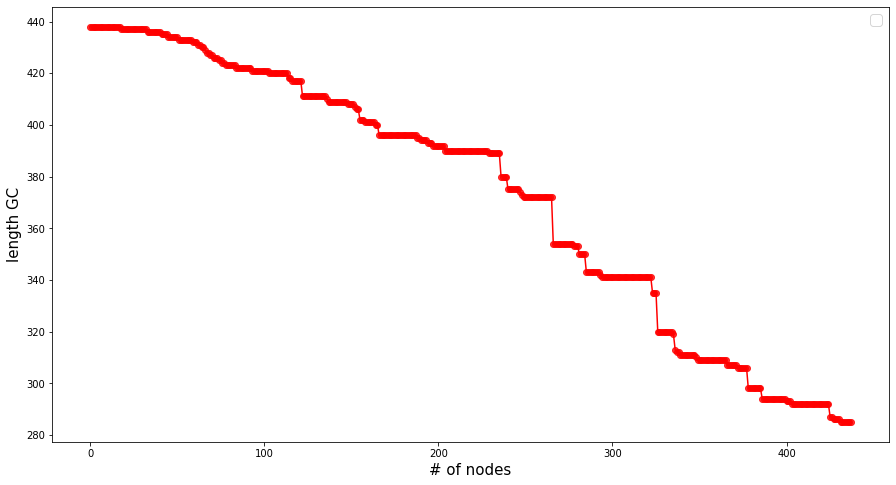

In [ ]:
#x_rob, y_rob = robustness(G_hashtag_connected)
#x_att, y_att = attack(G_hashtag_connected)
x_neg, y_neg = neg_attack(G_hashtag_connected, neg_dic)


fig = plt.figure(figsize=(15,8))
ran = plt.scatter(x=x_neg, y=y_neg, 
                 color='red', alpha=0.8)
plt.plot(x_neg, y_neg, color='red')

#plt.title('Robustness October postGP', fontsize=25)
plt.xlabel("# of nodes", fontsize=15)
plt.ylabel("length GC", fontsize=15)
plt.legend(prop={'size': 15})

In [ ]:
import random

def robustness(g):

    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    luppolo=0

    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = random.choice(best_node2)

        if x % 5 == 0:
          luppolo +=1
          comps = list(nx.connected_components(g_remove_most_important))
          
          giant_comp = max(comps, key=len)
          comp_nodes_number = len(giant_comp)
          comp_len = len(comps)

          list_giantcomponentnodes.append(comp_nodes_number)
          list_components.append(comp_len)
          list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes




def attack(g):

    most_imp = pd.Series(dict(g.degree)).sort_values(ascending=False)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = most_imp.index[x]
        comps = list(nx.connected_components(g_remove_most_important))
        giant_comp = max(comps, key=len)
        comp_nodes_number = len(giant_comp)
        comp_len = len(comps)

        list_giantcomponentnodes.append(comp_nodes_number)
        list_components.append(comp_len)
        list_removed.append(x)
        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes



def neg_attack(g, neg_dic):

    most_imp = pd.Series(neg_dic).sort_values(ascending=False)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = most_imp.index[x]
        comps = list(nx.connected_components(g_remove_most_important))
        giant_comp = max(comps, key=len)
        comp_nodes_number = len(giant_comp)
        comp_len = len(comps)

        list_giantcomponentnodes.append(comp_nodes_number)
        list_components.append(comp_len)
        list_removed.append(x)
        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes

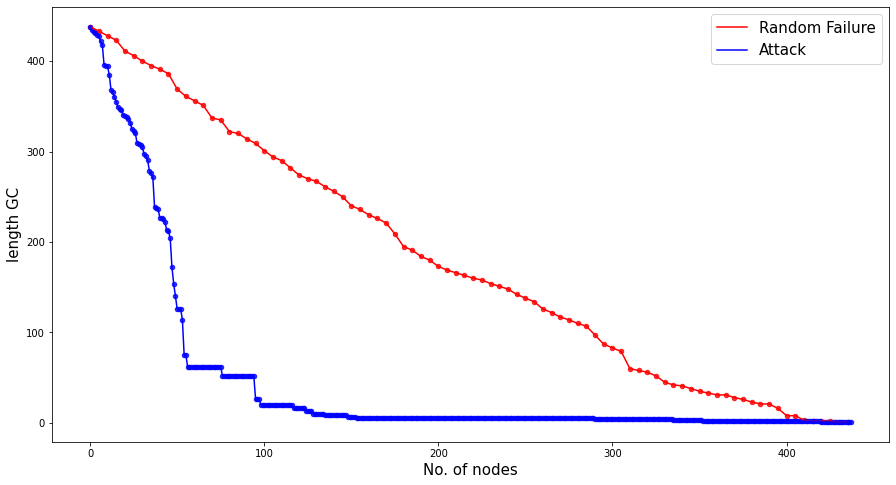

In [ ]:
x_rob, y_rob = robustness(G_hashtag_connected)
x_att, y_att = attack(G_hashtag_connected)
#x_neg, y_neg = neg_attack(G_hashtag_connected, neg_dic)



fig = plt.figure(figsize=(15,8))
ran = plt.scatter(x=x_rob, y=y_rob, 
                 color='red', alpha=0.8, s=20, marker='o')
plt.plot(x_rob, y_rob, color='red', label='Random Failure')
  
att = plt.scatter(x=x_att, y=y_att, 
                 color='blue', alpha=0.8, s=20, marker='o')
plt.plot(x_att, y_att, color='blue', label='Attack')

#neg = plt.scatter(x=x_neg, y=y_neg, 
#                 color='green', alpha=0.8, s=20, marker='o')
#plt.plot(x_neg, y_neg, color='green', label='Negemo')
#plt.title('Robustness October postGP', fontsize=25)
plt.xlabel("No. of nodes", fontsize=15)
plt.ylabel("length GC", fontsize=15)
plt.legend(prop={'size': 15})

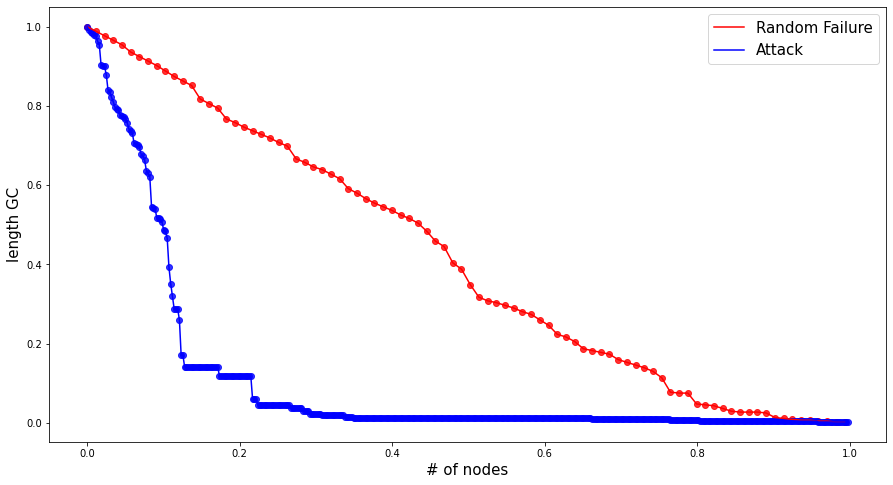

In [ ]:
x_rob, y_rob = robustness(G_hashtag_connected)
x_att, y_att = attack(G_hashtag_connected)

x_att = np.array(x_att)/G_hashtag_connected.number_of_nodes()
x_rob = np.array(x_rob)/G_hashtag_connected.number_of_nodes()
y_rob = np.array(y_rob)/G_hashtag_connected.number_of_nodes()
y_att = np.array(y_att)/G_hashtag_connected.number_of_nodes()



fig = plt.figure(figsize=(15,8))
ran = plt.scatter(x=x_rob, y=y_rob, 
                 color='red', alpha=0.8)
plt.plot(x_rob, y_rob, color='red', label='Random Failure')
  
att = plt.scatter(x=x_att, y=y_att, 
                 color='blue', alpha=0.8)
plt.plot(x_att, y_att, color='blue', label='Attack')
#plt.title('Robustness October postGP', fontsize=25)
plt.xlabel("# of nodes", fontsize=15)
plt.ylabel("length GC", fontsize=15)
plt.legend(prop={'size': 15})

# *Working on Network, words* 

In this part we will start analyzing the netwrok propiety


## We really need all the nodes? Probably not but let's see 

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_postgp = []
edge_words = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_vaxcamp.csv',header=None)
for i in range(edge_words.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_postgp.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))

G_hybrid = nx.Graph()
G_hybrid.add_weighted_edges_from(up_weighted_hashtag_postgp)

### Pagerank 

Ascending and descending

	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


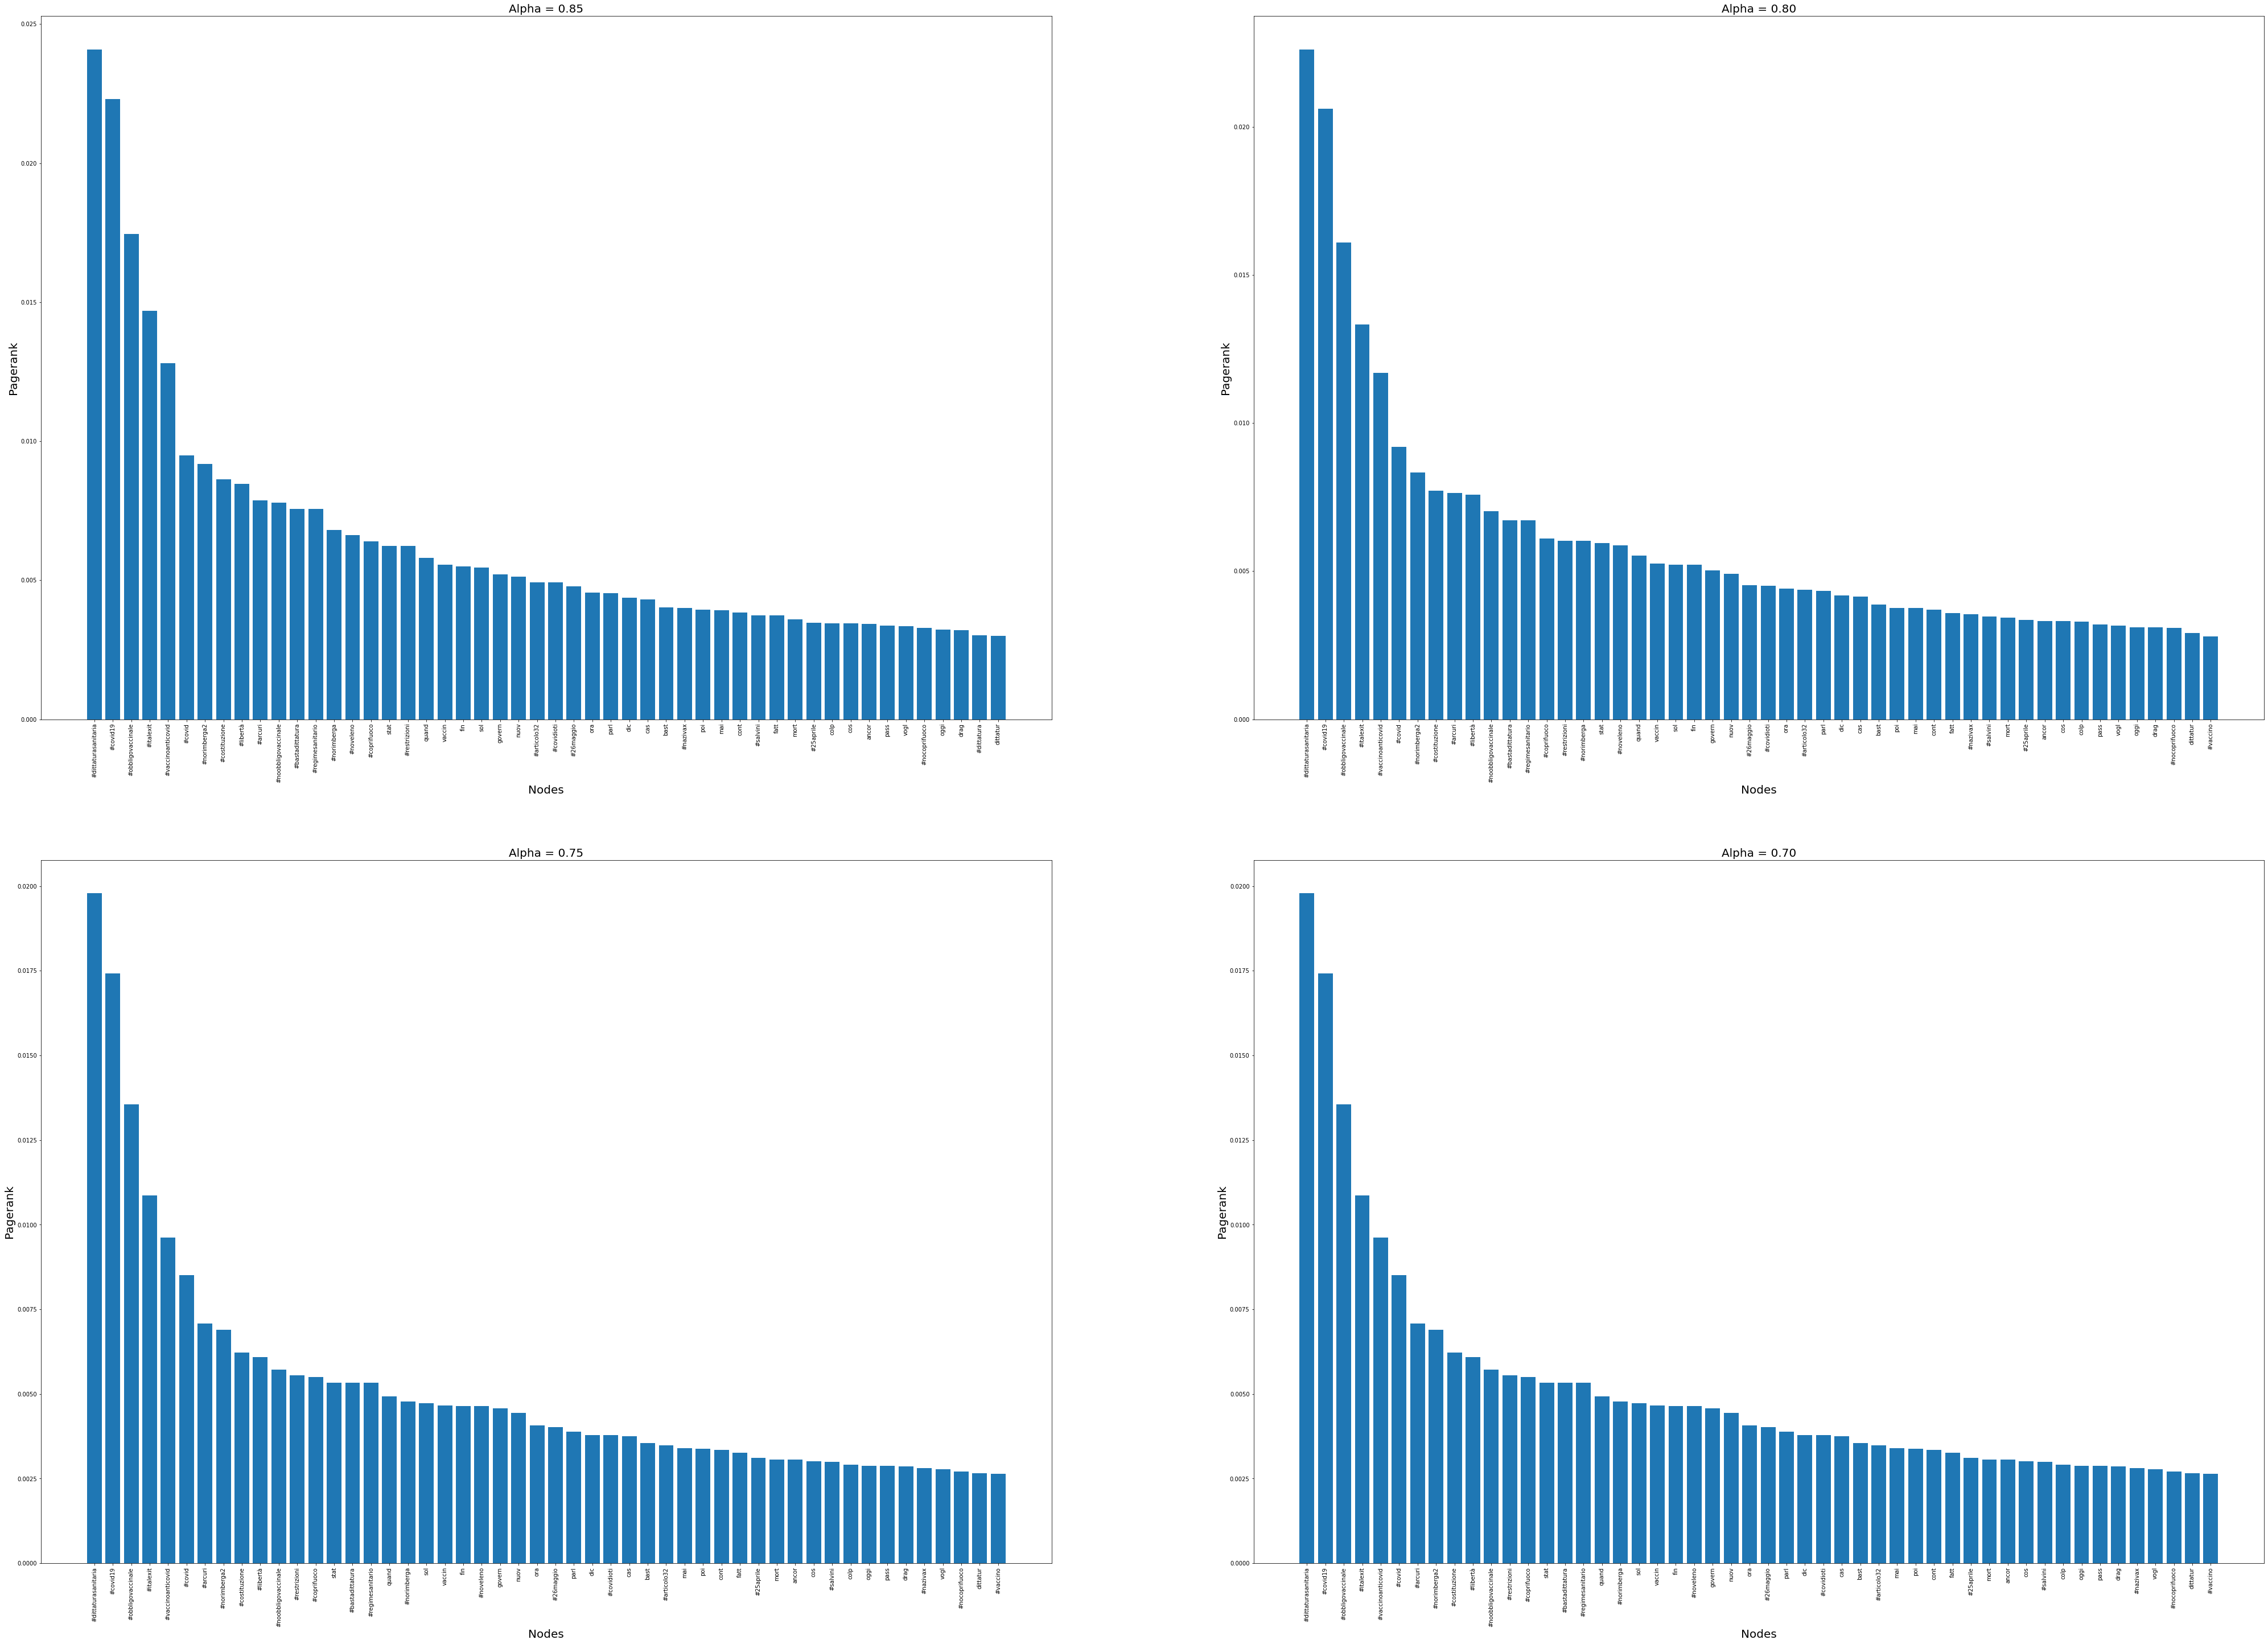

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hybrid,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hybrid,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hybrid,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hybrid,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


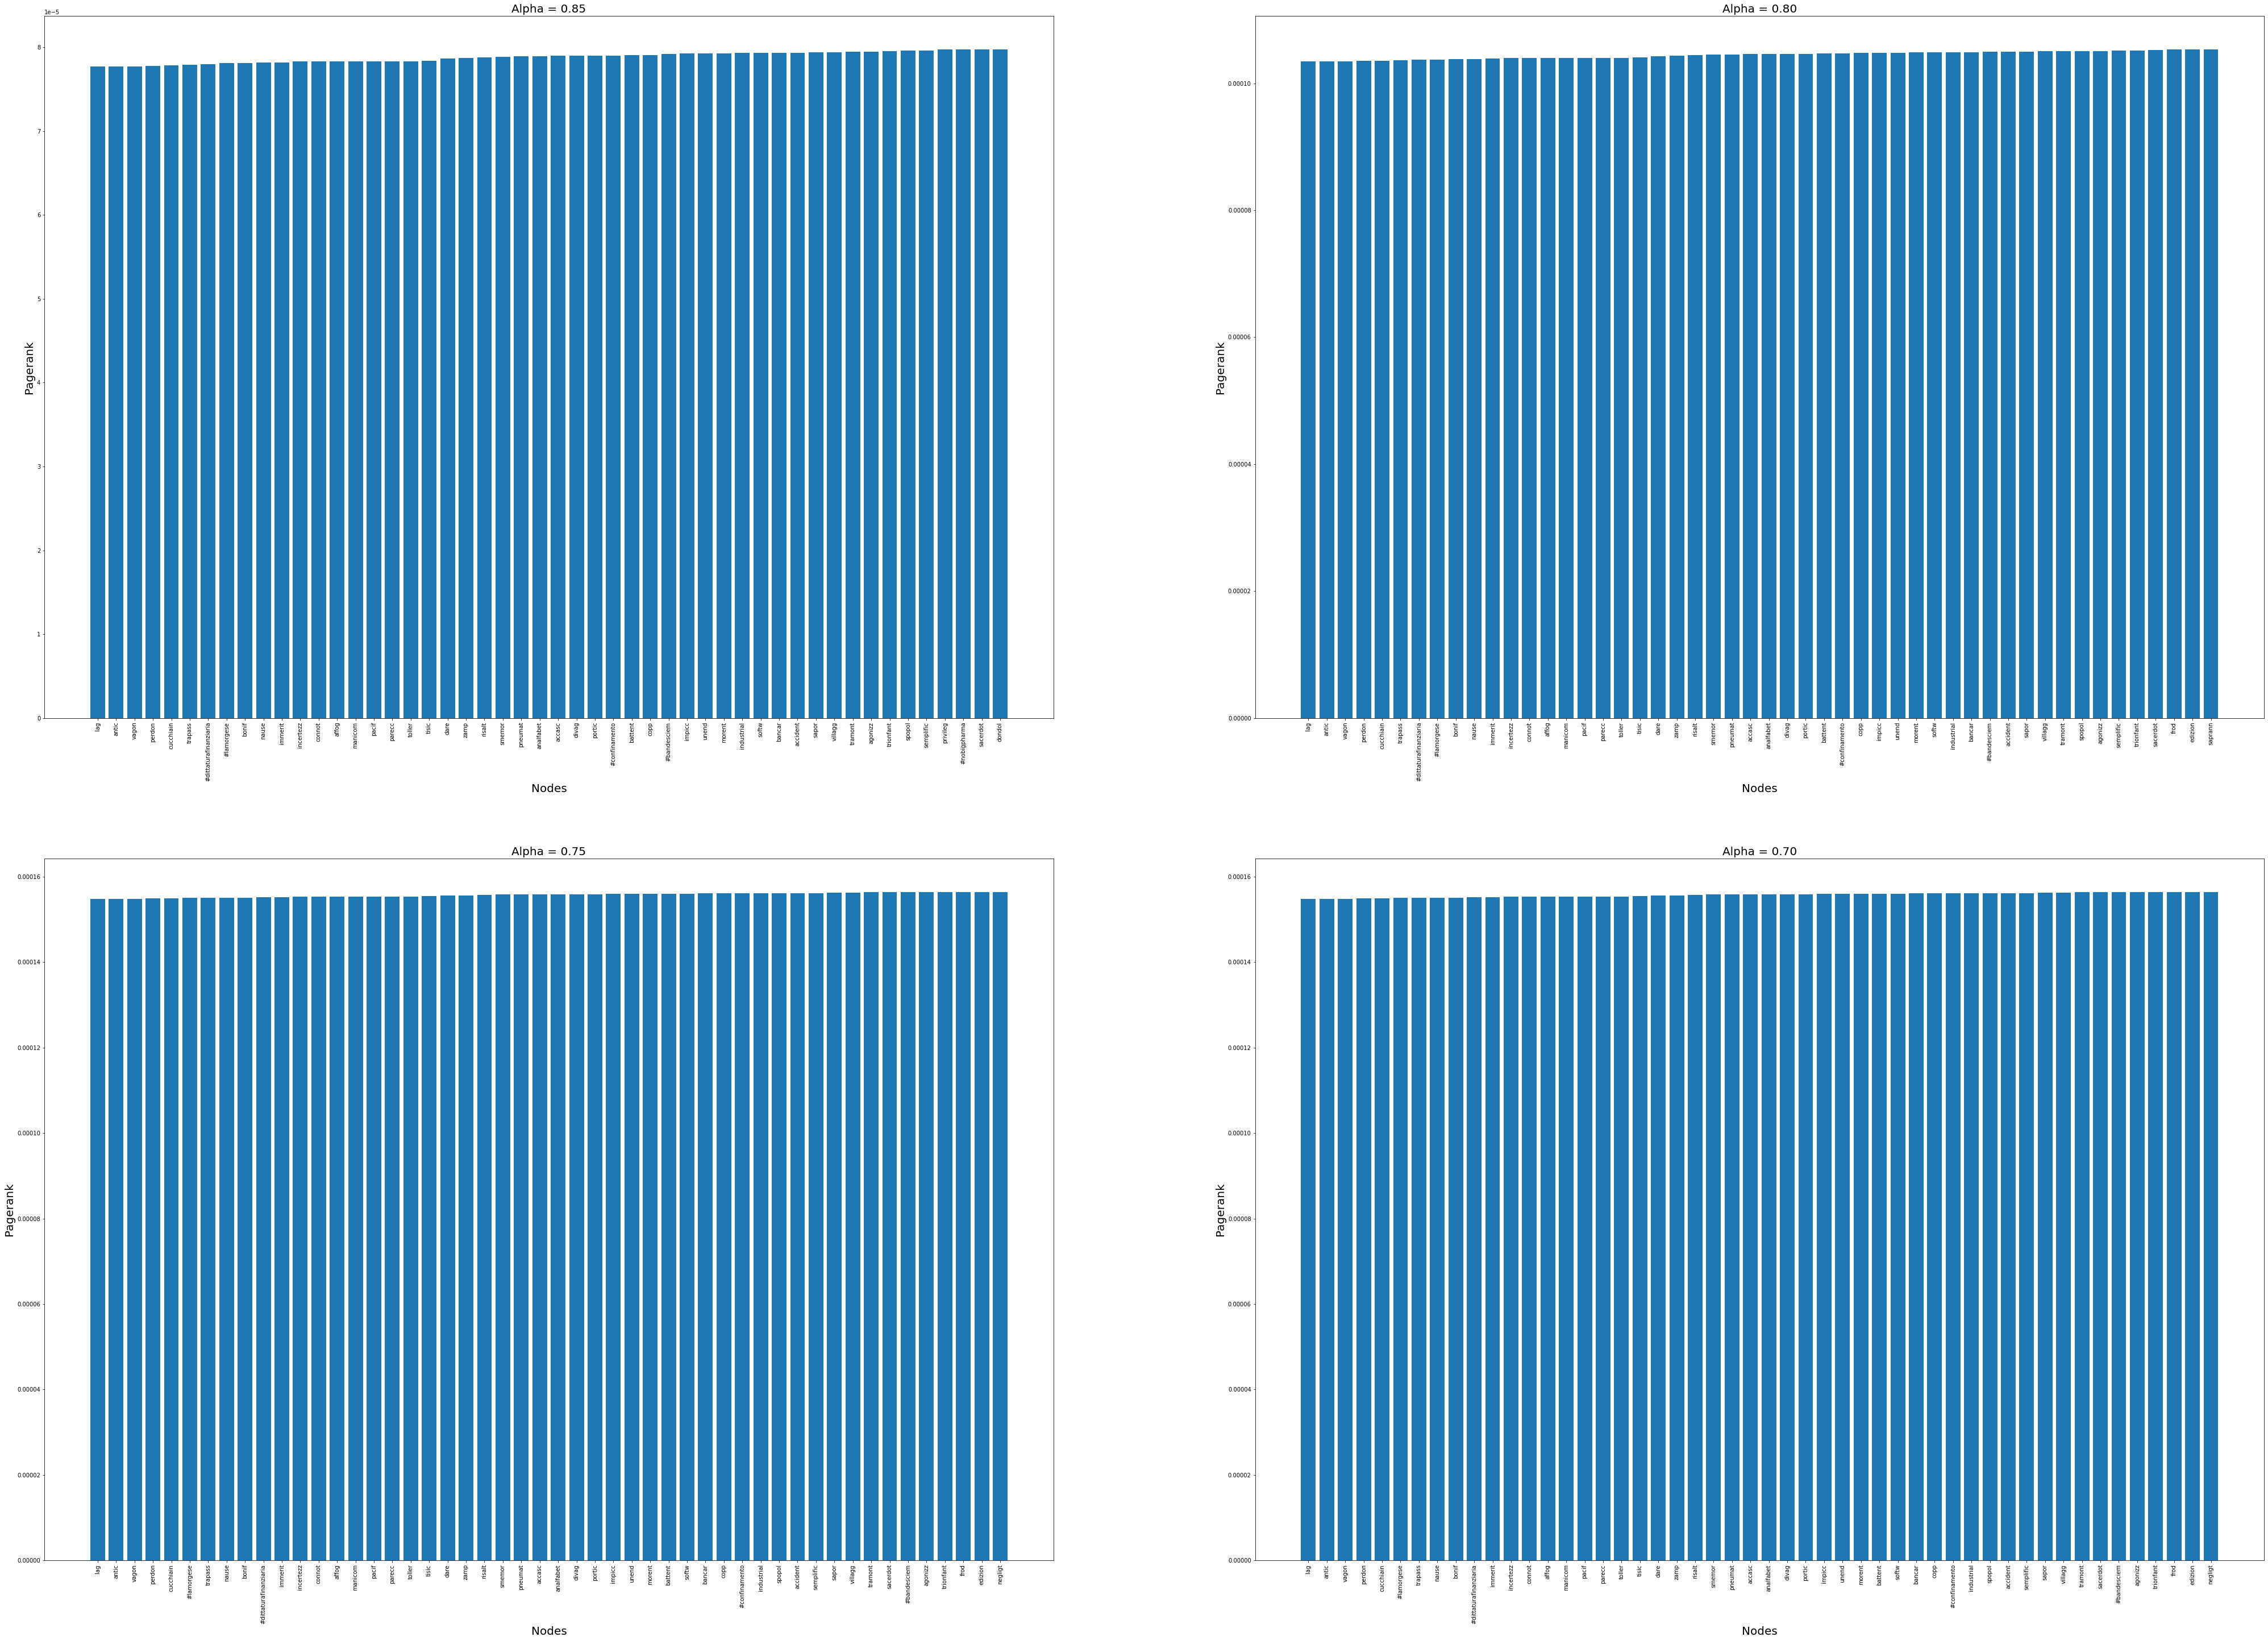

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hybrid,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr75 = nx.pagerank(G_hybrid,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr80 = nx.pagerank(G_hybrid,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = False)}

pr85= nx.pagerank(G_hybrid,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = False)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


### Node degree

Ascending and descending

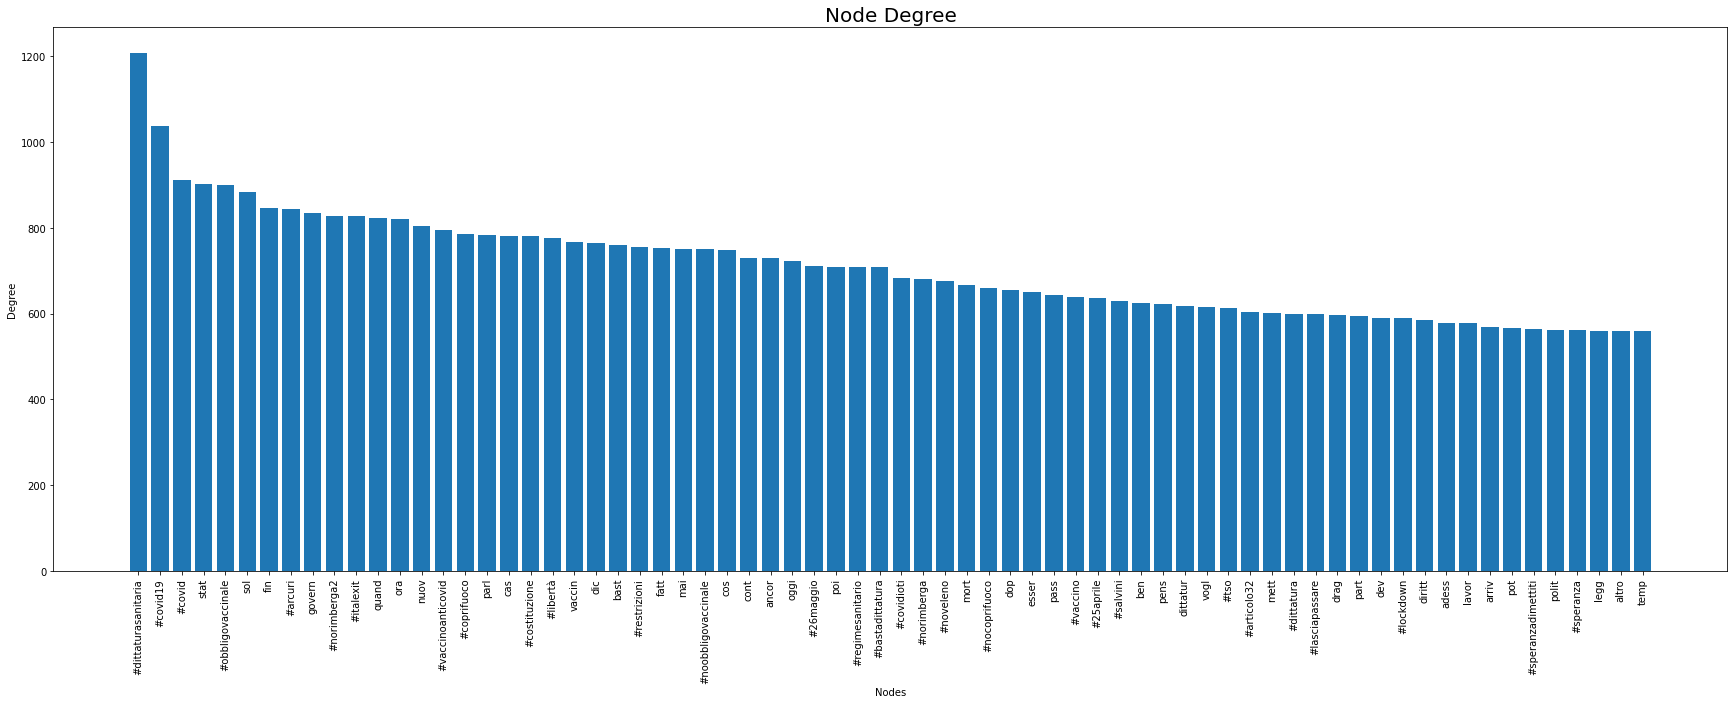

In [ ]:
most_imp = pd.Series(dict(G_hybrid.degree)).sort_values(ascending=False)[:70]
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

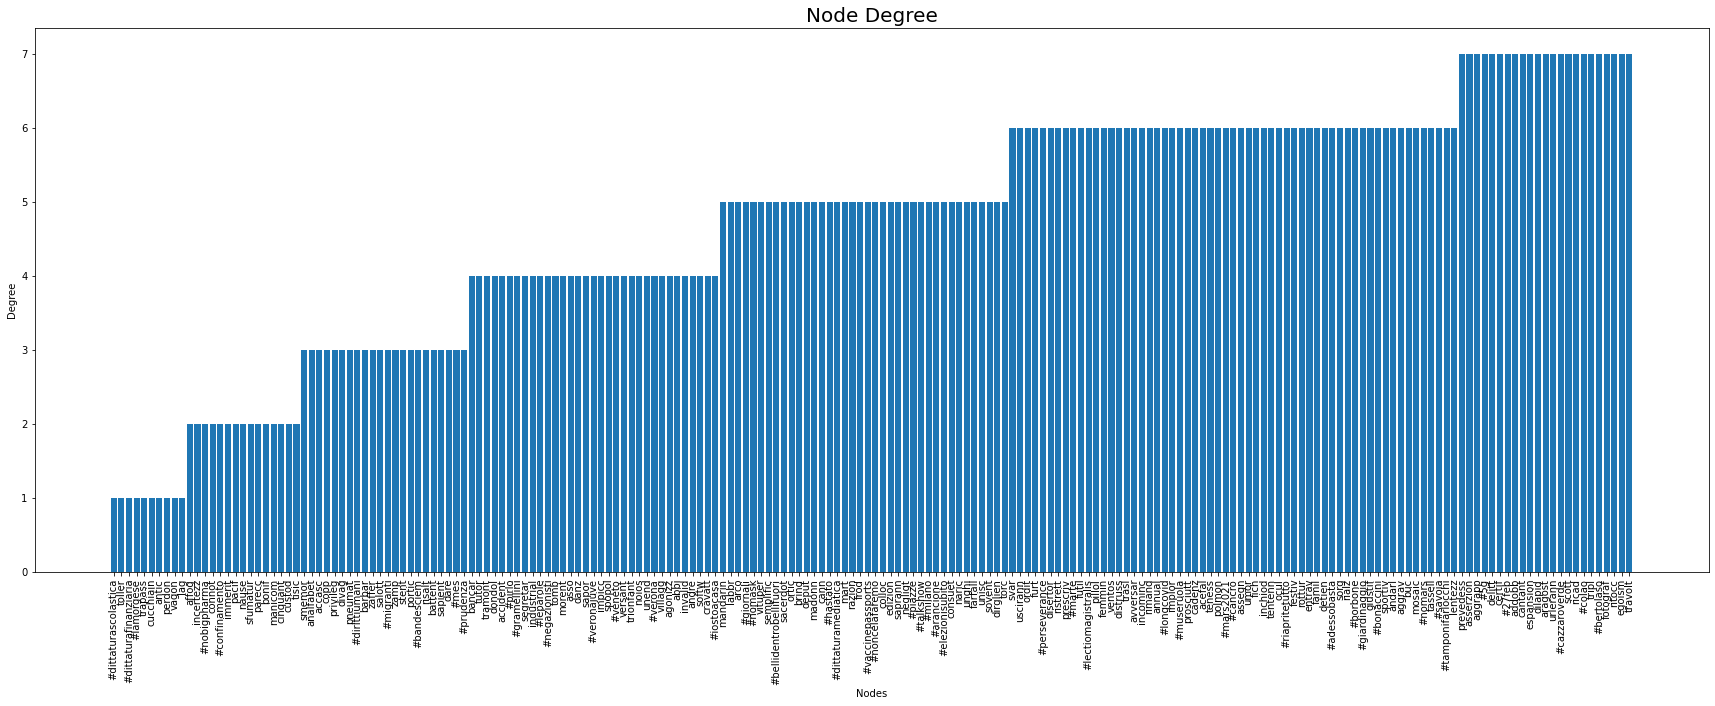

In [ ]:
less_imp = pd.Series(dict(G_hybrid.degree)).sort_values(ascending=True)[:200]
plt.figure(figsize=(30,10))
plt.bar(less_imp.index,height=less_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

In [ ]:
blacklist = list(most_imp[(most_imp>1100)].index)
blacklist.extend(list(less_imp[(less_imp<2)].index))
blacklist

['#dittaturasanitaria',
 '#dittaturascolastica',
 'toller',
 '#dittaturafinanziaria',
 '#lamorgese',
 'trapass',
 'cucchiain',
 'antic',
 'perdon',
 'vagon',
 'lag']

## As we can notice the first 2 node have a really high frequqncy, node degree & Pagerank

So we will discard them because think about the com. detect. Also the node with a small degree and 

In [ ]:
up_weighted_hashtag_postgp = []
edge_words = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_vaxcamp.csv',header=None)
for i in range(edge_words.shape[0]):
  if (edge_words.iloc[i,0] not in blacklist) and(edge_words.iloc[i,1] not in blacklist):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_postgp.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))

G_hybrid = nx.Graph()
G_hybrid.add_weighted_edges_from(up_weighted_hashtag_postgp)

NameError: ignored

In [ ]:
filename_postgp = "/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_vaxcamp.csv"
nx.write_weighted_edgelist(G_hybrid, filename_postgp, delimiter=",")

### The network is connected? (If not wich are tha connected componets)

In [ ]:
iG_postgp = ig.Graph.from_networkx(G_hybrid)
print("\t \t \t \t \t \t  \t \t \t  CONNECTION")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Is the graph connected:","YES" if iG_postgp.is_connected() else "NO")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("The connected componet are:")
print("\t")
#IF NOT YOU CAN FIND ISOLATED COMPONENENTS
skip = True 
isolated = {}
i = 1
for component in iG_postgp.components():
  print(component)
  if not skip:
    isolated[i] = component
    i+=1
  skip =False
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  


	 	 	 	 	 	  	 	 	  CONNECTION
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pandas.core.common import flatten
isolated_list = list(flatten(list(isolated.values())))
isolated_list
temp = [len(i) for i in isolated.values()]
find_the_comunities = dict(zip([i+1 for i in range(len(isolated.keys()))],temp))

In [ ]:
counter = 0
find_counter = 1
check_com = 0
isolated = []
print("\t \t \t  Hashtag of the connected component")
print("--------------------------------------------------------------------------------------------")
for vertice in iG_postgp.vs:
    if counter in isolated_list:
      if check_com==find_the_comunities[find_counter]:
        print("--------------------------------------------------------------------------------------------")
        find_counter+=1
        check_com=0
      isolated.append(vertice.attributes()['_nx_name'])
      print(f" The hashtag {vertice.attributes()['_nx_name'].upper()}, is in the isolated component number: {find_counter}")
      check_com+=1
    counter+=1
print("--------------------------------------------------------------------------------------------")

	 	 	  Hashtag of the connected component
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


In [ ]:
up_weighted_hashtag_connected = []
edge_words = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_vaxcamp.csv",header=None)
index_comp_con = []
for i in range(edge_words.shape[0]):
      if (edge_words.iloc[i,0] not in isolated) and (edge_words.iloc[i,1] not in isolated) and (edge_words.iloc[i,2]>0) and not (edge_words.iloc[i,1] in blacklist) and not (edge_words.iloc[i,0] in blacklist):
        #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
        #if(network[edge])>1: 
        up_weighted_hashtag_connected.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))
        index_comp_con.append(i)
      
G_hybrid_connected= nx.Graph()
G_hybrid_connected.add_weighted_edges_from(up_weighted_hashtag_connected)

In [ ]:
edge_words.iloc[index_comp_con,:].to_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_clean_vaxcamp.csv",header=None)

In [ ]:
edge_words.iloc[index_comp_con,:]

,0,1,2
0,#breakingnews,#coronavirus,129
1,#breakingnews,#lockdown,129
2,#breakingnews,#covid,129
3,#breakingnews,#coronavirusitalia,129
4,#breakingnews,#covidiota,129
...,...,...,...
131678,#pirlo,#veronajuve,2
131679,#gramellini,#leparole,2
131680,#gramellini,#veronajuve,1
131681,#leparole,#veronajuve,1


## Working on the giant Network component

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_postgp = []
edge_words = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_clean_vaxcamp.csv",header=None).iloc[:,1:]
for i in range(edge_words.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_postgp.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))

G_hybrid_connected = nx.Graph()
G_hybrid_connected.add_weighted_edges_from(up_weighted_hashtag_postgp)

In [ ]:
filename_postgp = "/content/drive/MyDrive/Network_Science_covid_project/Vaxcamp/edge_words_clean_connected.csv"
nx.write_weighted_edgelist(G_hybrid_connected, filename_postgp, delimiter=",")

In [ ]:
iG_hybrid_connected = ig.Graph.from_networkx(G_hybrid_connected)

#### Network diameter

In [ ]:
# DIAMETER - HOW FAR ARE THE TWO MOST DISTANT NODES

print("Network diameter:", iG_hybrid_connected.diameter(directed=False))

# GET NODES IN THE DIAMETER PATH 
diameter_path = []
d = iG_hybrid_connected.get_diameter()
for i in range(0, iG_hybrid_connected.diameter()):
  diameter_path.append((d[i], d[i+1]))
# GET EDGES IN THE DIAMETER PATH
diameter_edges = iG_hybrid_connected.get_eids(pairs=diameter_path, directed=False)


# AVERAGE PATH LENGTH - HOW CLOSE ARE THE NODES TO EACH OTHER ON AVERAGE

print("Average path length:", iG_hybrid_connected.average_path_length(directed=False))

Network diameter: 4
Average path length: 2.101210592618259


### Node degree

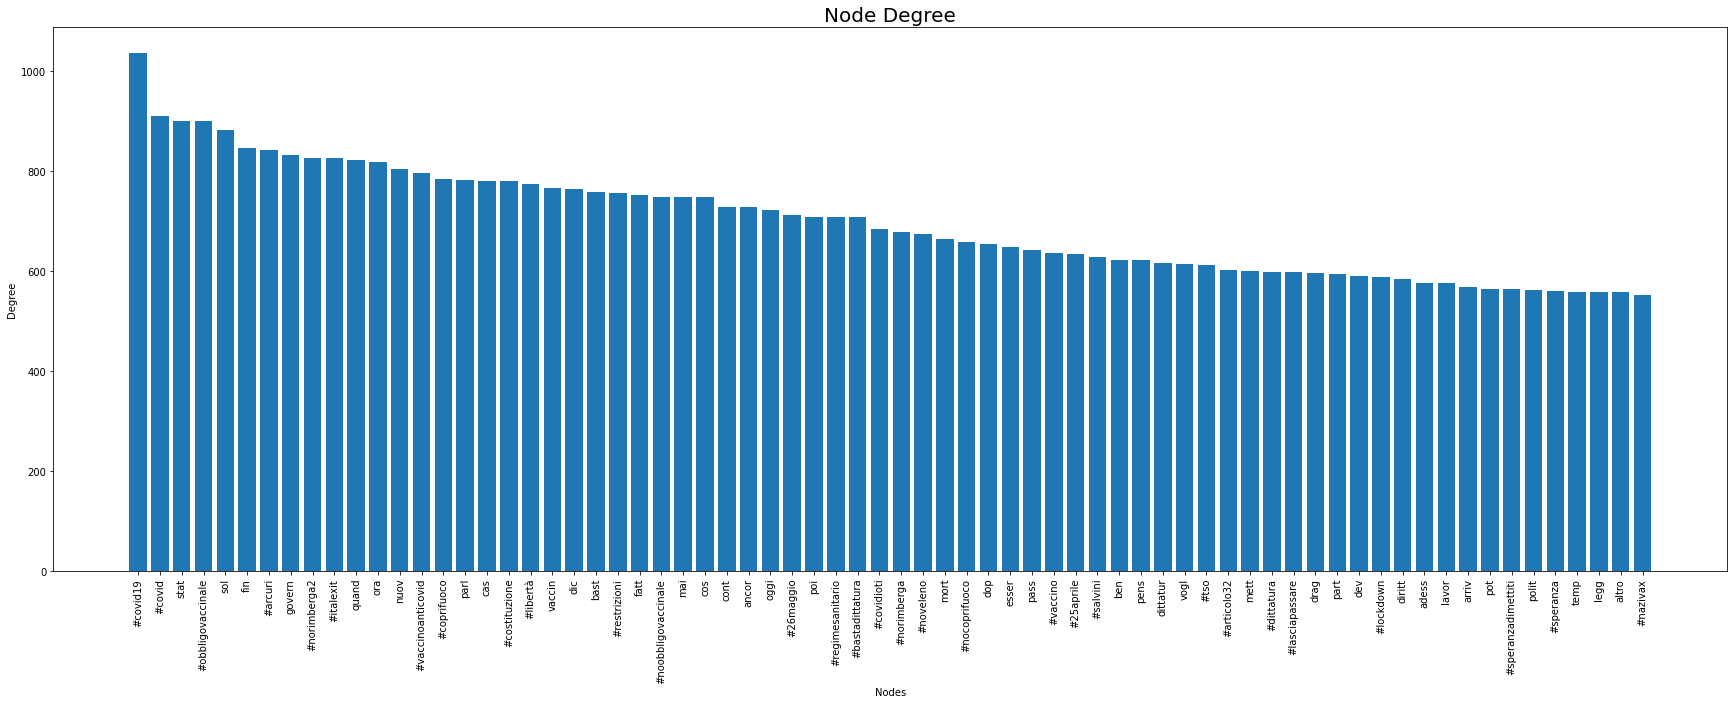

In [ ]:
most_imp = pd.Series(dict(G_hybrid_connected.degree)).sort_values(ascending=False)[:70]
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

### Degree distribution and Gamma estimation

In [ ]:
A = nx.adjacency_matrix(G_hybrid_connected)
d = np.sum(A,1)
d = np.squeeze(np.asarray(d))
d = d[d>0]
k = np.unique(d)
pk = np.histogram(d,k)[0]
pk = pk/np.sum(pk)
Pk = 1-np.cumsum(pk)

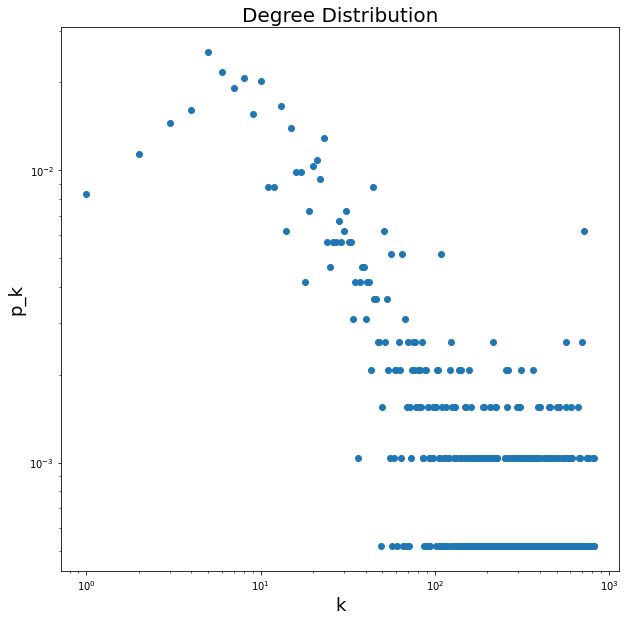

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.loglog(pk,'o')
plt.title("Degree Distribution",size=20)
plt.xlabel("k",size=18)
plt.ylabel("p_k",size=18)
plt.show()

In [ ]:
####### Gamma estimation
print("\t \t Gamma estimation (Free scale or random graph")
print("-------------------------------------------------------------------------")
d2 = d[d>=k.min()]
gamma = 1 + np.mean(np.log(d2/k.min()))
print(f"Gamma with the k min selected as the smallest neighbours, so k={k.min()}")
print(f"Gamma = {gamma}")
d2 = d[d>=5e1]
gamma = 1 + np.mean(np.log(d2/3e1))
print("-------------------------------------------------------------------------")
print(f"Gamma with the k min wisely selected, using the plot above, so k={3e1}")
print(f"Gamma = {gamma}")
print("-------------------------------------------------------------------------")

	 	 Gamma estimation (Free scale or random graph
-------------------------------------------------------------------------
Gamma with the k min selected as the smallest neighbours, so k=1
Gamma = 5.739083924312815
-------------------------------------------------------------------------
Gamma with the k min wisely selected, using the plot above, so k=30.0
Gamma = 3.848966738315624
-------------------------------------------------------------------------



### Pagerank 

	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


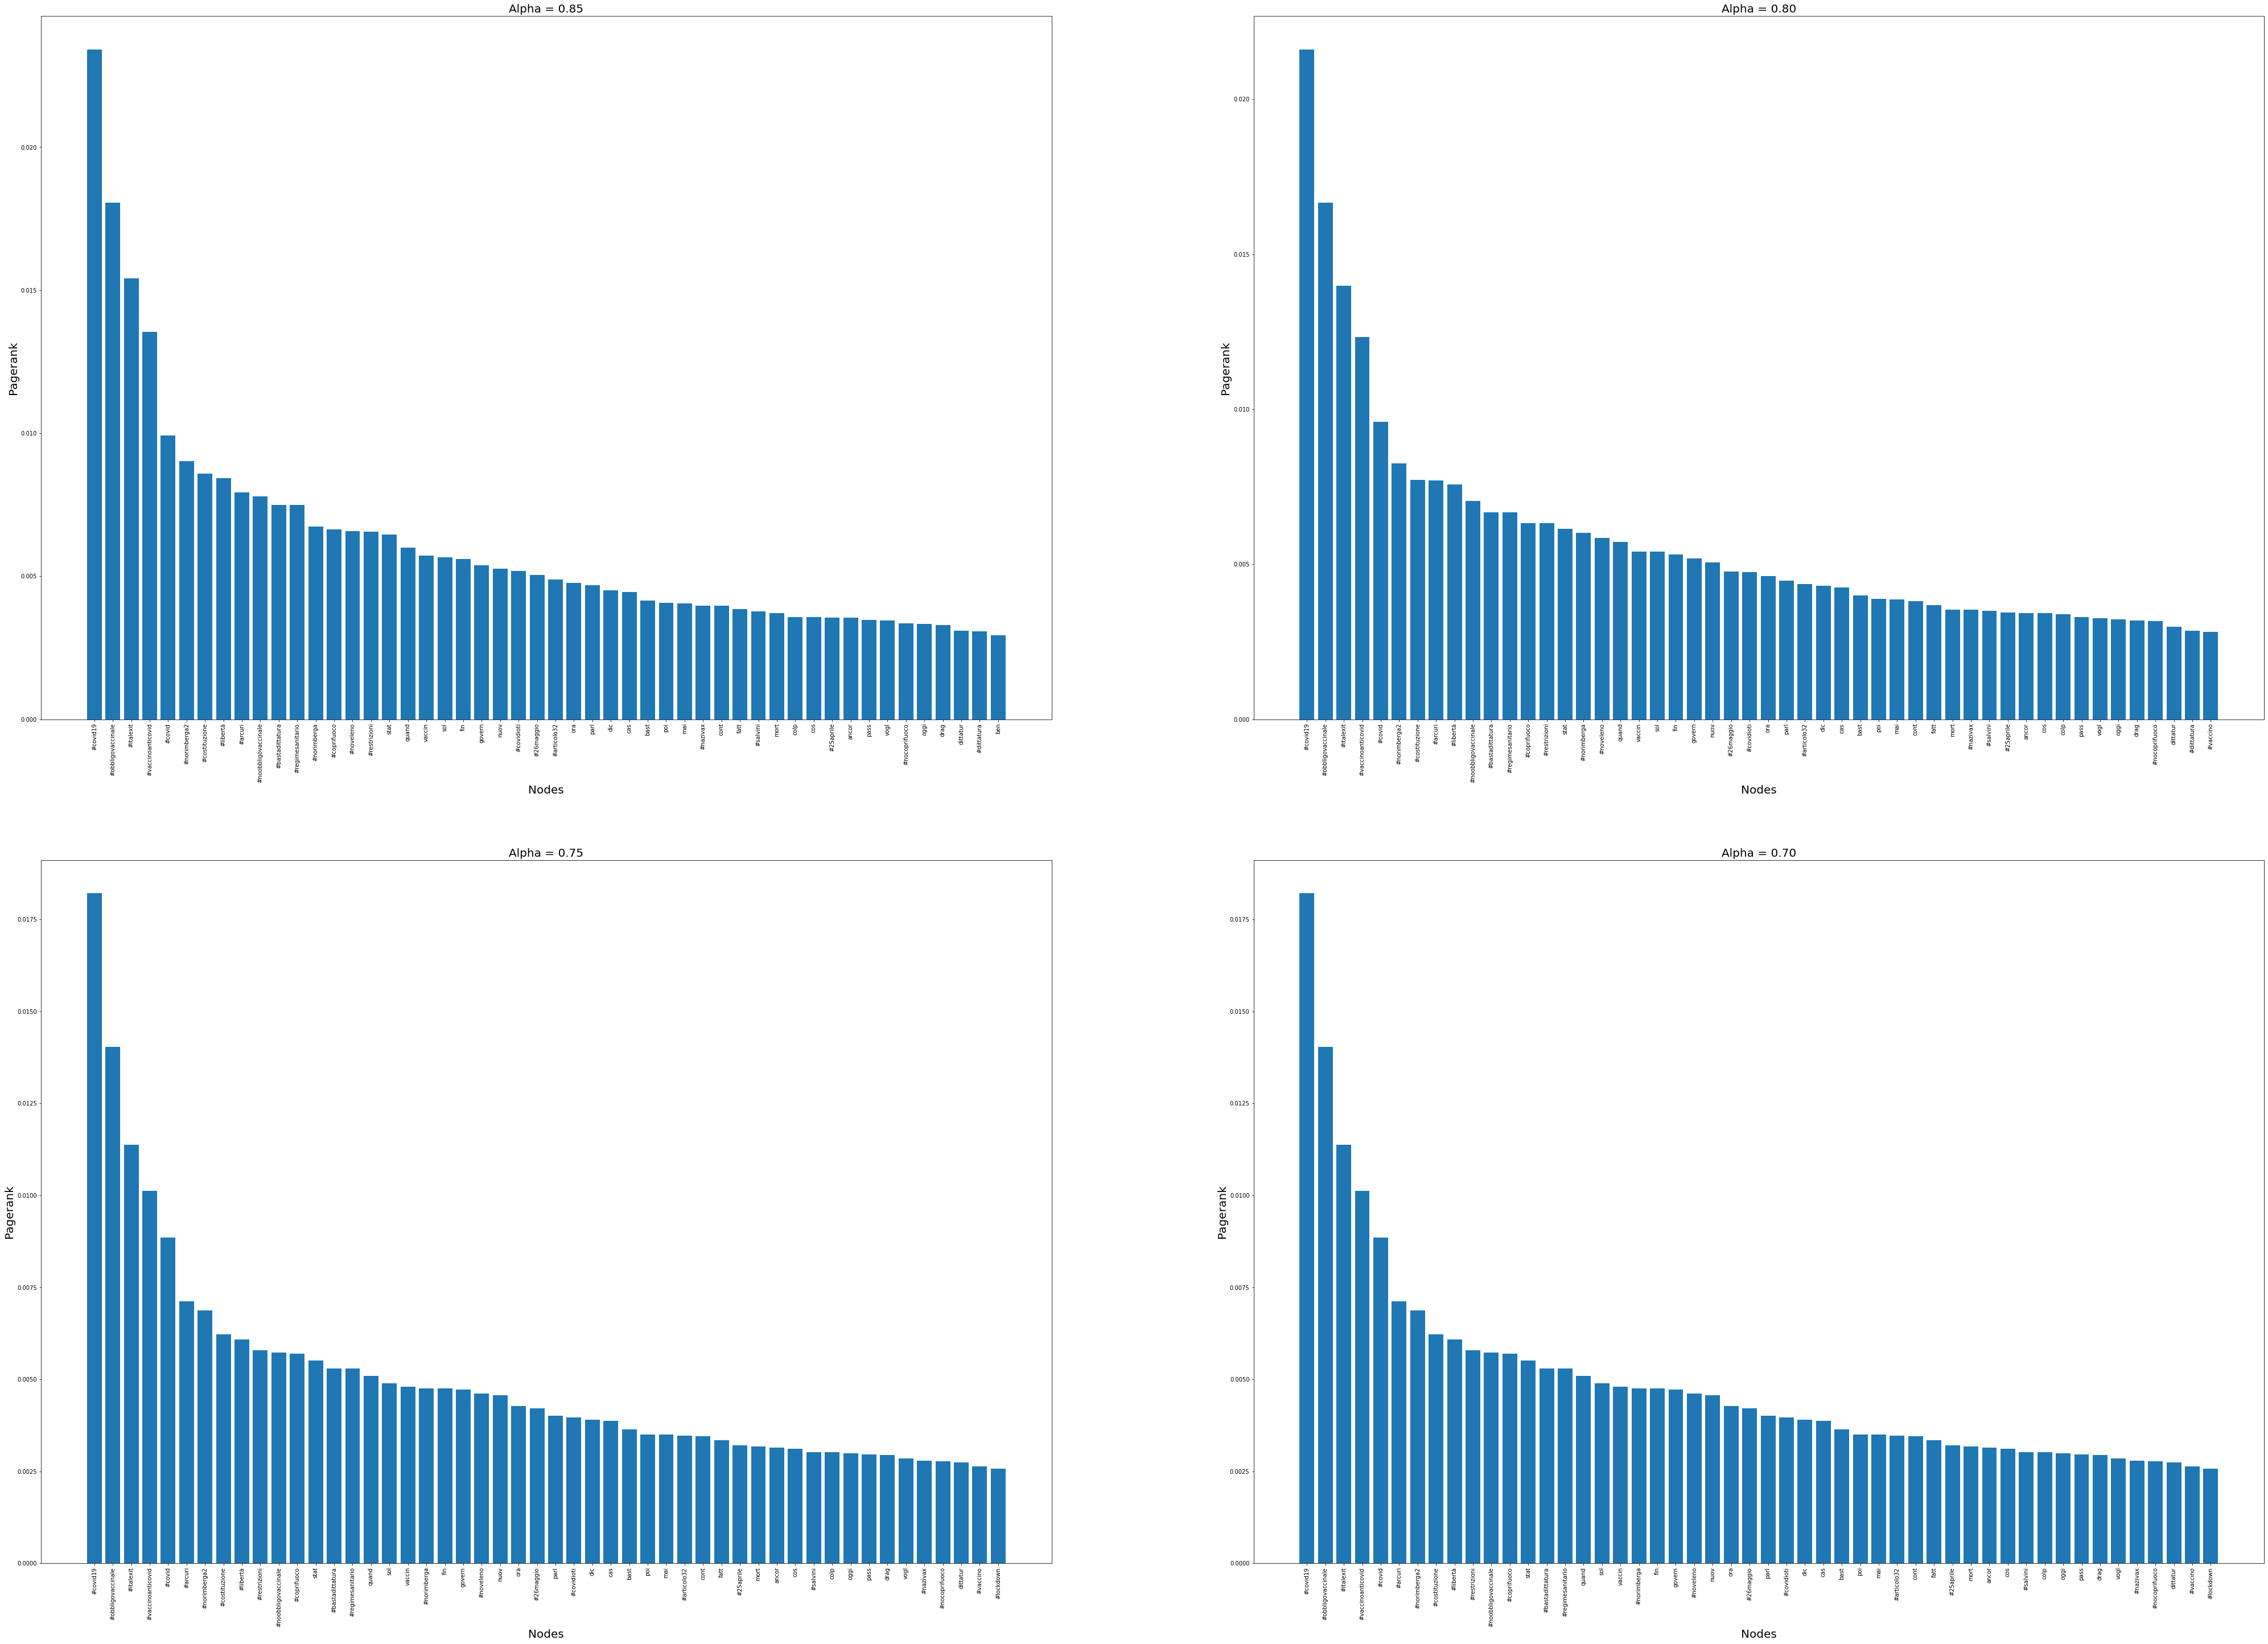

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hybrid_connected,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hybrid_connected,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hybrid_connected,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hybrid_connected,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


### Betweenes

In [ ]:
bw = nx.betweenness_centrality(G_hybrid_connected)
bw_sort = {k : v for k, v in sorted(bw.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(bw_sort.keys())[0:50],height=list(bw_sort.values())[0:50])
plt.xticks(rotation=90)
plt.title("Betweenes",fontsize=20)
plt.ylabel("Betweenes")
plt.xlabel("Nodes")
plt.show()


### Closesness

In [ ]:
close = nx.closeness_centrality(G_hybrid_connected)
close_sort = {k : v for k, v in sorted(close.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(close_sort.keys())[0:50],height=list(close_sort.values())[0:50])
plt.xticks(rotation=90)
plt.title("Closesness",fontsize=20)
plt.ylabel("Closesness")
plt.xlabel("Nodes")
plt.show()

### Global Clustering coefficient

In [ ]:
print("Global clustering coefficient", iG_hybrid_connected.transitivity_undirected())

Global clustering coefficient 0.3562968038235133


### Local clustering coefficiet 

In [ ]:
# LOCAL CC - ARE THE NEIGHBOURS OF THE NODES ALSO CONNECTED?
import math
print("Local clustering components:")
local_ccs = iG_hybrid_connected.transitivity_local_undirected()
nodes = iG_hybrid_connected.vs()
sum_cc = 0
for local_cc in local_ccs:
    if not math.isnan(local_cc):
        sum_cc += local_cc

for node in nodes:
        
        print("   Local clustering coefficient of node",node.attributes()['_nx_name'],":",local_ccs[node.index])

        
# AVERAGE CC

print("Average clustering component", sum_cc/len(iG_hybrid_connected.vs()))


Local clustering components:
   Local clustering coefficient of node #breakingnews : 0.3999726663933306
   Local clustering coefficient of node #coronavirus : 0.28227169655741086
   Local clustering coefficient of node #lockdown : 0.24205866332904544
   Local clustering coefficient of node #covid : 0.13644029601198004
   Local clustering coefficient of node #coronavirusitalia : 0.3999726663933306
   Local clustering coefficient of node #covidiota : 0.3960737812911726
   Local clustering coefficient of node mai : 0.27996835828161126
   Local clustering coefficient of node temp : 0.3572969272696744
   Local clustering coefficient of node primaver : 0.5261048304213772
   Local clustering coefficient of node dov : 0.4109240834723666
   Local clustering coefficient of node usar : 0.5748073345734787
   Local clustering coefficient of node farc : 0.5511171293161815
   Local clustering coefficient of node fors : 0.44334047013693745
   Local clustering coefficient of node cas : 0.27560975609756

### Assortativity

In [ ]:
print(f"The assortativity of the network: {nx.degree_assortativity_coefficient(G_hybrid_connected)}")

The assortativity of the network: -0.24443261316054243


### Comunities detection

In [ ]:
cummunities = {}
for i in np.linspace(1,60,5):
  cummunities[i] = nx_comm.louvain_communities(G_hybrid_connected,resolution=1,seed=int(i))


In [ ]:
salva = True
for i in cummunities:
  print(len(cummunities[i]))
  if salva:
    best_com = cummunities[i]
    salva = False
  for j in cummunities[i]:
      print(j)
  print("\t")

12
{'incompres', 'ritir', 'ritien', '#spernazadimettiti', '#libri', 'dicon', 'ultim', '#speranza', '#articolo32', '#iprofessionistidellinformazione', '#speranzaingalera', '#traditoridellapatria', 'restant', '#bastadittatura', 'singhiozz', 'timor', 'agi', '#dittatura', '#costituzione', 'topp', 'penn', 'pend', 'sincer', 'oppressor', 'aquil', 'segreghin', 'odor', '#speranzavattene', '#libertà', 'edific', 'infettin', 'intervien', '#riavvicinamentosociale', 'notiz', 'panc', 'mettetel', '#palombelli', '#salvini', 'ren', '#curilapaura', 'esegu', 'sfacc', 'regist', '#nopass', 'pols', 'elog', 'facolt', 'elicotter', '#speranzavergognati', 'dimm', 'truff', 'muscol', 'disc', 'percors', 'sciocc', '#carlonegri', 'spes', 'stad', '#partitounicoliberale', '#scuole', 'elegg', 'micidial', 'razz', '#motoreitalia', 'orfan', 'ritorn', 'industrial', '#regimesanitario', '#nogreenpass', '#norimberga', '#deluca', 'incolp', 'piov', 'incominc', 'atlet', '#ms49', 'prender', '#campania', '#rigore', 'inferm', 'sces'

In [ ]:
for i in cummunities:
      print("Modularity:")
      print(nx_comm.modularity(G_hybrid_connected,cummunities[i]))
      print("\t")


Modularity:
0.31579955962590356
	
Modularity:
0.31135323197297365
	
Modularity:
0.3124770010884112
	
Modularity:
0.31213746361515415
	
Modularity:
0.31401787213044213
	


### Make the pagerank on the single comunities and analyze the tweets

In [ ]:
best_com = cummunities[60]
comunity_network = {}
counter = 1
for i in best_com:
  comm = list(i)
  up_weighted_hashtag_postgp = []
  for i in range(edge_words.shape[0]):
    if (edge_words.iloc[i,0] in comm) and (edge_words.iloc[i,1] in comm):
      up_weighted_hashtag_postgp.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))
  G_com = nx.Graph()
  G_com.add_weighted_edges_from(up_weighted_hashtag_postgp)
  pr = nx.pagerank(G_com)
  pr = list({k : v for k, v in sorted(pr.items(), key = lambda t : t[1], reverse = True)}.keys())
  comunity_network[counter] = pr
  counter +=1

In [ ]:
pd.Series(comunity_network).to_csv("/content/drive/MyDrive/Network_Science_covid_project/ex_burlone/words_vaxcamp_4.csv")

In [ ]:
counter = 1
list_of_text_com = []
for i in comunity_network.values():
    for index, row in tweets_filtered.iterrows():
      if type(row["hashtags"]) is list:
        for j in row["hashtags"]:
          if j in i:
            list_of_text_com.append({"comunità":counter,"text":row["text"]})
      if type(row["hashtags"]) is str:
        if row["hashtags"]==j:
          list_of_text_com.append({"comunità":counter,"text":row["text"]})
      for l in i:
        if l in row["clean_text"]:
          list_of_text_com.append({"comunità":counter,"text":row["text"]})
    counter+=1

TypeError: ignored

In [ ]:
test_comunity_text = pd.DataFrame(list_of_text_com,index=[i for i in range(len(list_of_text_com))])

In [ ]:
test_comunity_text.drop_duplicates(inplace=True)

In [ ]:
test_comunity_text.to_csv("/content/drive/MyDrive/Network_Science_covid_project/An_com/text_vaxcamp_words_2.csv")

### Robustness (if we are able)

In [ ]:
import random

def robustness(g):

    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    luppolo=0

    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = random.choice(best_node2)

        if x % 5 == 0:
          luppolo +=1
          comps = list(nx.connected_components(g_remove_most_important))
          
          giant_comp = max(comps, key=len)
          comp_nodes_number = len(giant_comp)
          comp_len = len(comps)

          list_giantcomponentnodes.append(comp_nodes_number)
          list_components.append(comp_len)
          list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes




def attack(g):

    most_imp = pd.Series(dict(g.degree)).sort_values(ascending=False)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = most_imp.index[x]
        comps = list(nx.connected_components(g_remove_most_important))
        giant_comp = max(comps, key=len)
        comp_nodes_number = len(giant_comp)
        comp_len = len(comps)

        list_giantcomponentnodes.append(comp_nodes_number)
        list_components.append(comp_len)
        list_removed.append(x)
        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes

In [ ]:
x_rob, y_rob = robustness(G_hybrid_connected)
x_att, y_att = attack(G_hybrid_connected)

fig = plt.figure(figsize=(15,8))
ran = plt.scatter(x=x_rob, y=y_rob, 
                 color='red', alpha=0.8)
plt.plot(x_rob, y_rob, color='red', label='Random Failure')
  
att = plt.scatter(x=x_att, y=y_att, 
                 color='blue', alpha=0.8)
plt.plot(x_att, y_att, color='blue', label='Attack')
plt.title('Robustness October postGP', fontsize=25)
plt.xlabel("# of nodes", fontsize=15)
plt.ylabel("length GC", fontsize=15)
plt.legend(prop={'size': 15})

## LIWC

In [ ]:
list_orig_1 = ['#coronavirus', '#italia', '#novax', '#nocoprifuoco', '#ioil22nonlovoglio', '#tamponi', '#difettosi', '#svezia', '#scoperta', '#shock', '#articolo', '#qui', '#farsavirus', '#nocomunismo', '#ascoltitv', '#ventaglidiparole', '#nochiusure', '#africa', '#influenza', '#vulnusdemocratico', '#arancione', '#negazionisti']

In [ ]:
list_mod_1 = ['coronavirus', 'italia', 'no vax', 'no coprifuoco', 'io il 22 non lo voglio', 'tamponi', 'difettosi', 'svezia', 'scoperta', 'shock', 'articolo', 'qui', 'farsa virus', 'no comunismo', 'ascolti tv', 'ventagli di parole', 'no chiusure', 'africa', 'influenza', 'vulnus democratico', 'arancione', 'negazionisti']

In [ ]:
list_orig_2 = ['#arcuri', '#draghi', '#figliuolo', '#vaccini', '#meloni', '#conte', '#militari', '#destra', '#ueismo', '#nato', '#sionismo', '#opposizione', '#banchiarotelle', '#video', '#scienziati', '#nobel', '#mascherine', '#1marzo', '#renzi', '#pennivendoli', '#contedimettiti', '#pianovaccinale', '#dittaturamilitare', '#governodeimigliori', '#admaiora', '#hastatolaraggi', '#siringhe', '#renzirispondi', '#graziearcuri', '#cinearcuri', '#mariodraghi', '#draghipremier', '#grillo', '#travaglio', '#discontinuità', '#commissario', '#primulavulgaris', '#fiorispontanei', '#giardino', '#fiori', '#marzo', '#flowers', '#wildflowers', '#nature', '#garden', '#renzidimettiti', '#spelacchio', '#prudenza', '#primule', '#arabiaviva', '#europeisti', '#nonelarena', '#piazzapulita', '#5stelle', '#astrazeneca', '#novanews24', '#gfvip', '#antonellaelia', '#signorini', '#pietrodellepiane', '#italy', '#gossip', '#responsabili', '#recoveryplan', '#grazierenzi', '#tajani', '#partitimafiosidelinquenti', '#monopattini', '#azzolina', '#toninelli', '#isoladeifamosi', '#honduras', '#cialtrona', '#report', '#myanmar', '#nuovorinascimento', '#vaccinocovid', '#ritardi', '#sbocciate', '#salviniliberaci', '#ottoemezzola7', '#ditturamilitare', '#ministerieconomici', '#delegaservizi', '#populisti', '#sovranisti', '#buonsabato', '#clubhouse', '#etna', '#iostocontommaso', '#zorzi', '#berlusconi', '#agorarai', '#omnibusla7', '#tagada', '#arabia', '#benotti', '#leghista', '#dante', '#ministrodellistruzione', '#lapeggioredestradisempre', '#sottosegretari', '#ue', '#giuseppi', '#arculi', '#vaccinazioni', '#basilicata', '#arcuriout', '#arcuriciao', '#massadipirla', '#carcere', '#poliziapenitenziaria', '#nwo', '#sischerza', '#giornalisti', '#zone', '#lineadellaprudenza', '#altoprofilo', '#mandraghi', '#dimaio', '#draghisantosubito', '#disobbediamo', '#lectiomagistralis', '#generale', '#golpemilitaresanitario', '#convenzionedifaro', '#europa', '#happyday', '#salvinieuropeista', '#ristori', '#mainagioia', '#personalenondocente', '#hastato', '#finalmenteunagioia', '#governodicialtroni', '#colao']

In [ ]:
list_mod_2 = ['arcuri', 'draghi', 'figliuolo', 'vaccini', 'meloni', 'conte', 'militari', 'destra', 'ueismo', 'nato', 'sionismo', 'opposizione', 'banchi a rotelle', 'video', 'scienziati', 'nobel', 'mascherine', '1 marzo', 'renzi', 'pennivendoli', 'conte dimettiti', 'piano vaccinale', 'dittatura militare', 'governo dei migliori', 'ad maiora', 'ha stato la raggi', 'siringhe', 'renzi rispondi', 'grazie arcuri', 'cine arcuri', 'mario draghi', 'draghi premier', 'grillo', 'travaglio', 'discontinuità', 'commissario', 'primula vulgaris', 'fiori spontanei', 'giardino', 'fiori', 'marzo', 'flowers', 'wild flowers', 'nature', 'garden', 'renzi dimettiti', 'spelacchio', 'prudenza', 'primule', 'arabia viva', 'europeisti', 'non e l arena', 'piazza pulita', '5 stelle', 'astrazeneca', 'no va news 24', 'gf vip', 'antonella elia', 'signorini', 'pietro delle piane', 'italy', 'gossip', 'responsabili', 'recoveryplan', 'grazie renzi', 'tajani', 'partiti mafiosi delinquenti', 'monopattini', 'azzolina', 'toninelli', 'isola dei famosi', 'honduras', 'cialtrona', 'report', 'myanmar', 'nuovo rinascimento', 'vaccino covid', 'ritardi', 'sbocciate', 'salvini liberaci', 'otto e mezzo la7', 'dittura militare', 'ministeri economici', 'delega servizi', 'populisti', 'sovranisti', 'buon sabato', 'club house', 'etna', 'io sto con tommaso', 'zorzi', 'berlusconi', 'agora rai', 'omnibus la7', 'tagada', 'arabia', 'benotti', 'leghista', 'dante', 'ministro dell istruzione', 'la peggiore destra di sempre', 'sottosegretari', 'ue', 'giuseppi', 'arculi', 'vaccinazioni', 'basilicata', 'arcuri out', 'arcuri ciao', 'massa di pirla', 'carcere', 'polizia penitenziaria', 'nwo', 'si scherza', 'giornalisti', 'zone', 'linea della prudenza', 'alto profilo', 'ma draghi', 'di maio', 'draghi santo subito', 'disobbediamo', 'lectio magistralis', 'generale', 'golpe militare sanitario', 'convenzione di faro', 'europa', 'happy day', 'salvini europeista', 'ristori', 'mai na gioia', 'personale non docente', 'ha stato', 'finalmente una gioia', 'governo di cialtroni', 'colao']

In [ ]:
list_orig_3 = ['#coprifuoco', '#lockdown', '#covid', '#lega', '#lasciapassare', '#vaccino', '#dpcm', '#salvini', '#terzaondata', '#riaperture', '#nolasciapassare', '#breakingnews', '#coronavirusitalia', '#covidiota', '#zonarossa', '#governodraghi', '#pandemia', '#fdi', '#fi', '#liberazione', '#bellaciao', '#aborto', '#dirittoanonvaccinarsi', '#25aprile2021', '#innonazionale', '#obbligo', '#pasqua', '#27febbraio', '#turismo', '#agnelli', '#delazione', '#neolingua', '#fascismo', '#coprifuocoalle22', '#liberi', '#passaportovaccinale', '#democrazia', '#variante', '#india', '#occidentale', '#dittaturadigitale', '#pirlo', '#zonaarancione', '#nicolaporro', '#virus', '#arancionerafforzato', '#regione', '#darsena', '#gramellini', '#leparole', '#casalino', '#sapevatelo', '#satira', '#vignetta', '#vukic', '#passvaccinali', '#lombardia', '#lockdown4', '#perseverance', '#marte', '#mars2021', '#nomars', '#bertolaso', '#decretocovid', '#zonarancione', '#coerenzamediatica', '#veronajuve', '#covidvaccine', '#ricciardi', '#cessodestra', '#49milioni', '#fratellidindrangheta', '#forzamafia', '#barlusconi', '#firenze', '#tampone', '#pcrtest', '#roma', '#movida', '#22febbraio', '#ilvocio', '#governoregioni', '#colsorriso', '#renzifottiti', '#nonandratuttobene', '#neoeuropeismo', '#siria', '#portarelapace', '#sietetuttirenzi', '#matteogracis', '#2marzo', '#nevedremodellebelle', '#èsololinizio', '#thegoodlist', '#paolocrepet', '#podcast', '#spotify', '#palestre', '#fitness', '#abbracciauncinese', '#campania', '#deluca', '#scuole', '#mes', '#migranti', '#savoia', '#borbone', '#amicidelpd', '#veneto', '#verona', '#pienipoteri', '#figliulo', '#israele', '#vaccinepassports', '#congiuntifuoriregione', '#suggerimento', '#sportinromagna', '#noncelafaremo', '#facciamorete', '#coviddi', '#iostoacasa', '#riflessioni', '#cazzaroverde', '#varianti', '#5g']

In [ ]:
list_mod_3 = ['coprifuoco', 'lockdown', 'covid', 'lega', 'lascia passare', 'vaccino', 'dpcm', 'salvini', 'terza ondata', 'riaperture', 'no lascia passare', 'breaking news', 'coronavirus italia', 'covidiota', 'zona rossa', 'governo draghi', 'pandemia', 'fdi', 'fi', 'liberazione', 'bella ciao', 'aborto', 'diritto a non vaccinarsi', '25 aprile 2021', 'inno nazionale', 'obbligo', 'pasqua', '27 febbraio', 'turismo', 'agnelli', 'delazione', 'neolingua', 'fascismo', 'coprifuoco alle 22', 'liberi', 'passaporto vaccinale', 'democrazia', 'variante', 'india', 'occidentale', 'dittatura digitale', 'pirlo', 'zona arancione', 'nicola porro', 'virus', 'arancione rafforzato', 'regione', 'darsena', 'gramellini', 'le parole', 'casalino', 'sapevatelo', 'satira', 'vignetta', 'vukic', 'pass vaccinali', 'lombardia', 'lockdown 4', 'perseverance', 'marte', 'mars 2021', 'no mars', 'bertolaso', 'decreto covid', 'zona arancione', 'coerenza mediatica', 'verona juve', 'covid vaccine', 'ricciardi', 'cesso destra', '49 milioni', 'fratelli di ndrangheta', 'forza mafia', 'barlusconi', 'firenze', 'tampone', 'pcr test', 'roma', 'movida', '22 febbraio', 'il vocio', 'governo regioni', 'col sorriso', 'renzi fottiti', 'non andra tutto bene', 'neo europeismo', 'siria', 'portare la pace', 'siete tutti renzi', 'matteo gracis', '2 marzo', 'ne vedremo delle belle', 'è solo l inizio', 'the good list', 'paolo crepet', 'podcast', 'spotify', 'palestre', 'fitness', 'abbraccia un cinese', 'campania', 'de luca', 'scuole', 'mes', 'migranti', 'savoia', 'borbone', 'amici del pd', 'veneto', 'verona', 'pieni poteri', 'figliulo', 'israele', 'vaccine passports', 'congiunti fuori regione', 'suggerimento', 'sport in romagna', 'non ce la faremo', 'facciamo rete', 'coviddi', 'io sto a casa', 'riflessioni', 'cazzaro verde', 'varianti', '5g']

In [ ]:
list_orig_4 = ['#costituzione', '#norimberga2', '#libertà', '#bastadittatura', '#regimesanitario', '#noobbligovaccinale', '#norimberga', '#noveleno', '#articolo32', '#nazivax', '#nopass', '#nogreenpass', '#noue', '#speranzavattene', '#speranzaingalera', '#iprofessionistidellinformazione', '#28maggio', '#legaladrona', '#speranza', '#partitodemocratico', '#comunismo', '#sinistra', '#partitounicoliberale', '#emiliaromagna', '#nessunacorrelazione', '#speranzavergognati', '#oms', '#mainstream', '#terapiedomiciliaricovid19', '#motoreitalia', '#carlonegri', '#palombelli', '#curilapaura', '#spernazadimettiti', '#26maggio', '#riavvicinamentosociale', '#20euroxbigpharma']

In [ ]:
list_mod_4 = ['costituzione', 'norimberga 2', 'libertà', 'basta dittatura', 'regime sanitario', 'no obbligo vaccinale', 'norimberga', 'no veleno', 'articolo 32', 'nazi vax', 'no pass', 'no green pass', 'no ue', 'speranza vattene', 'speranza in galera', 'i professionisti dell informazione', '28 maggio', 'lega ladrona', 'speranza', 'partito democratico', 'comunismo', 'sinistra', 'partito unico liberale', 'emilia romagna', 'nessuna correlazione', 'speranza vergognati', 'oms', 'mainstream', 'terapie domiciliari covid 19', 'motore italia', 'carlo negri', 'palombelli', 'curi la paura', 'spernaza dimettiti', '26 maggio', 'riavvicinamento sociale', '20 euro x big pharma']

In [ ]:
list_orig_5 = ['#25aprile', '#nolockdown', '#dittatura', '#ioapro', '#antifascistisempre', '#governodeipeggiori', '#festadellaliberazione', '#liberitutti', '#politicamentecorretto', '#ideologiagender', '#teoriagender', '#governo', '#dittaturafarmaceutica', '#liberta', '#mattarella', '#resistenza', '#zonagialla', '#regioni', '#25aprire', '#fasciopiddini', '#vogliamovotare', '#elezionisubito', '#congiuntifuoricomune', '#statodemergenza', '#cts', '#stopchiusure', '#traditoridellapatria', '#27feb']

In [ ]:
list_mod_5 = ['25 aprile', 'no lockdown', 'dittatura', 'io apro', 'antifascisti sempre', 'governo dei peggiori', 'festa della liberazione', 'liberi tutti', 'politicamente corretto', 'ideologia gender', 'teoria gender', 'governo', 'dittatura farmaceutica', 'liberta', 'mattarella', 'resistenza', 'zona gialla', 'regioni', '25 aprire', 'fascio piddini', 'vogliamo votare', 'elezioni subito', 'congiunti fuori comune', 'stato di emergenza', 'cts', 'stop chiusure', 'traditori della patria', '27 febbraio']

In [ ]:
list_orig_6 = ['#bastalockdown', '#ioesco', '#torniamoliberi', '#ribelliamoci', '#apritetutto', '#bastacoprifuoco', '#sardegna', '#zonabianca', '#covidー19', '#nazifascismo', '#governocriminale', '#apriresenzacondizioni', '#ultimora', '#apriretutto', '#aveterottoilcaxxo', '#stoplockdown', '#pazzi', '#mattarelladimettiti', '#riapritetutto', '#bastachiusure']

In [ ]:
list_mod_6 = ['basta lockdown', 'io esco', 'torniamo liberi', 'ribelliamoci', 'aprite tutto', 'basta coprifuoco', 'sardegna', 'zona bianca', 'covid 19', 'nazi fascismo', 'governo criminale', 'aprire senza condizioni', 'ultima ora', 'aprire tutto', 'avete rotto il cazzo', 'stop lockdown', 'pazzi', 'mattarella dimettiti', 'riaprite tutto', 'basta chiusure']

In [ ]:
list_orig_7 = ['#libri', '#eclissarsi', '#rigore']

In [ ]:
list_mod_7 = ['libri', 'eclissarsi', 'rigore']

In [ ]:
list_orig_8 = ['#tso', '#fano', '#mascherina', '#speranzadimettiti', '#ddlzan', '#iostoconrosanna', '#fatemiuntso', '#dldittatura', '#salvinipagliaccio', '#chivasso', '#imbavagliati', '#bambini', '#magistrati', '#greenpass', '#gulag', '#sudtirolo', '#brunico', '#pd', '#m5s', '#rosanna', '#bufalacovid', '#draghiout', '#stopcoprifuoco', '#svoltaautoritaria', '#zannatadittatura', '#zan', '#impastato', '#fedez', '#buffoni', '#lamorgesedimettiti', '#museruola', '#cancro', '#generali', '#allarmisiamcretini', '#draghidimettiti']

In [ ]:
list_mod_8 = ['tso', 'fano', 'mascherina', 'speranza dimettiti', 'ddl zan', 'io sto con rosanna', 'fatemi un tso', 'dittatura', 'salvini pagliaccio', 'chivasso', 'imbavagliati', 'bambini', 'magistrati', 'green pass', 'gulag', 'sud tirolo', 'brunico', 'pd', 'm5s', 'rosanna', 'bufala covid', 'draghi out', 'stop coprifuoco', 'svolta autoritaria', 'dittatura', 'zan', 'impastato', 'fedez', 'buffoni', 'lamorgese dimettiti', 'museruola', 'cancro', 'generali', 'alle armi siam cretini', 'draghi dimettiti']

In [ ]:
list_orig_9 = ['#obbligovaccinale', '#vaccinoanticovid', '#italexit', '#covidioti', '#falsapandemia', '#fakepandemia', '#ufos', '#obama', '#extraterrestri', '#borghi', '#bagnai', '#bellavite', '#voxclamantis', '#assembramenti', '#psicosi', '#covid_19', '#fakenews', '#milanolibera', '#neonazismo']

In [ ]:
list_mod_9 = ['obbligo vaccinale', 'vaccino anti covid', 'italexit', 'covidioti', 'falsa pandemia', 'fake pandemia', 'ufos', 'obama', 'extraterrestri', 'borghi', 'bagnai', 'bellavite', 'vox clamantis', 'assembramenti', 'psicosi', 'covid 19', 'fake news', 'milano libera', 'neonazismo']

In [ ]:
list_orig_10 = ['#penadimorte', '#collaborazionisti']

In [ ]:
list_mod_10 = ['pena di morte', 'collaborazionisti']

In [ ]:
list_orig_11 = ['#truffacovid', '#polizia', '#sanremo2021', '#fiorelloamadeus', '#gratis']

In [ ]:
list_mod_11 = ['truffa covid', 'polizia', 'sanremo 2021', 'fiorello amadeus', 'gratis']

In [ ]:
list_orig = list_orig_1 + list_orig_2 + list_orig_3 + list_orig_4 + list_orig_5 + list_orig_6 + list_orig_7 + list_orig_8 + list_orig_9 + list_orig_10 + list_orig_11

In [ ]:
list_mod = list_mod_1 + list_mod_2 + list_mod_3 + list_mod_4 + list_mod_5 + list_mod_6 + list_mod_7 + list_mod_8 + list_mod_9 + list_mod_10 + list_mod_11

In [ ]:
dic = {}
for i in range(len(list_orig)):
  dic[list_orig[i]] = list_mod[i]
dic

In [ ]:
pip install googletrans==3.1.0a0

In [ ]:
pip install demoji

In [ ]:
from googletrans import Translator
import demoji

In [ ]:
tweets_df = tweets_df.reset_index(drop=True)

In [ ]:
def translate_emoji(df):
  translator = Translator()
  df['emoji'] = 0
  for i in range(df.shape[0]):
    dem = demoji.findall(df['text'][i])
    emo_list = list(dem.values())
    final = []
    for n in emo_list:
      res = translator.translate(n, dest='it')
      z = res.text
      final.append(z)
    df['emoji'][i] = ", ".join(w for w in final)
  return df

In [ ]:
import re

In [ ]:
def dictionary(twe):
  s = ''
  for word in re.findall(r"[\w\#']+|[.,!?;]", twe):
    if word in list(dic.keys()):
      a = dic.get(word)
    else:
      a = word
    s += ' ' + a
  return s

In [ ]:
def cleaner_luke(tweet):
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  tweet = str.lower(tweet)
  tweet = re.sub(emoj, '', tweet)
  tweet = re.sub("@+","",tweet) # remove mentions
  tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
  tweet = re.sub(r'http\S+', '', tweet)
  tweet = dictionary(tweet)
  tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
  tweet = re.sub("_+", " ",tweet)
  tweet = re.sub(r"\n+","",tweet)
  tweet= tweet.split(' ')
  tweet = [i for i in tweet if i not in ['RT', 'rt', ':']]
  tweet = ' '.join(tweet)
  return tweet

In [ ]:
translate_emoji(tweets_df)
tweets_df["luke_text"] = tweets_df["text"].map(cleaner_luke)
tweets_df["luke_text"] = tweets_df["luke_text"] + tweets_df["emoji"]